In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Load the data
outfield_data = pd.read_csv('../data/processed/outfielders.csv')
goalkeeper_data = pd.read_csv('../data/processed/goalkeepers.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Identify the IDs of players who have inf values in any column
inf_ids = outfield_data[outfield_data.isin([np.inf, -np.inf]).any(axis=1)]['ID'].unique()

# Exclude all rows that have these IDs
outfield_data = outfield_data[~outfield_data['ID'].isin(inf_ids)]

# Impute the value in PPM entry that is null
impute_value = outfield_data[(outfield_data['Team'] == 'Girona') & (outfield_data['Season'] == '2017/2018')]['PPM'].iloc[3]
outfield_data['PPM'] = outfield_data['PPM'].fillna(impute_value)

# Impute 0 in Press%, Drib%, SoT%, ADuel% and On-Off
outfield_data['Press%'] = outfield_data['Press%'].fillna(0)
outfield_data['Drib%'] = outfield_data['Drib%'].fillna(0)
outfield_data['SoT%'] = outfield_data['SoT%'].fillna(0)
outfield_data['ADuel%'] = outfield_data['ADuel%'].fillna(0)
outfield_data['On-Off'] = outfield_data['On-Off'].fillna(0)

In [5]:
# Imputing CS%
goalkeeper_data.loc[goalkeeper_data['CS%'].isnull(), 'CS%'] = 100

# Imputing CrossStop%
cross_stop_mean = goalkeeper_data['CrossStop%'].mean()
goalkeeper_data['CrossStop%'] = goalkeeper_data['CrossStop%'].fillna(cross_stop_mean)

# Impute 0 in PK% and On-Off
goalkeeper_data['PKSave%'] = goalkeeper_data['PKSave%'].fillna(0)
goalkeeper_data['On-Off'] = goalkeeper_data['On-Off'].fillna(0)

In [6]:
def calculate_attempts(df):
    # Calculate DribAtt
    df['DribAtt'] = df.apply(lambda row: row['DribSucc'] / (row['Drib%'] / 100) if row['Drib%'] != 0 else 0, axis=1)
    
    # Calculate PressAtt
    df['PressAtt'] = df.apply(lambda row: row['PressSucc'] / (row['Press%'] / 100) if row['Press%'] != 0 else 0, axis=1)
    
    # Calculate ADuelAtt
    df['ADuelAtt'] = df.apply(lambda row: row['ADuelWon'] / (row['ADuel%'] / 100) if row['ADuel%'] != 0 else 0, axis=1)
    
    # Round the results to the nearest integer
    df['DribAtt'] = df['DribAtt'].round().astype(int)
    df['PressAtt'] = df['PressAtt'].round().astype(int)
    df['ADuelAtt'] = df['ADuelAtt'].round().astype(int)
    
    return df

In [7]:
def calculate_missing_variables(df):
    # Scale percentage columns
    df['CS_Scaled'] = df['CS%'] / 100
    df['Save_Scaled'] = df['Save%'] / 100
    df['CrossStop_Scaled'] = df['CrossStop%'] / 100
    df['PKSave_Scaled'] = df['PKSave%'] / 100
    
    # Calculate metrics using vectorized operations
    df['GamesCS'] = (df['CS_Scaled'] * df['MP']).round().astype(int)
    df['Saves'] = (df['Save_Scaled'] * df['SoTA']).round().astype(int)
    df['CrossInt'] = (df['CrossStop_Scaled'] * df['CrossAtt']).round().astype(int)
    df['PKSaved'] = (df['PKSave_Scaled'] * df['PKAtt']).round().astype(int)
    
    # Drop scaled columns
    df.drop(['CS_Scaled', 'Save_Scaled', 'CrossStop_Scaled', 'PKSave_Scaled'], axis=1, inplace=True)
    
    return df

In [8]:
outfield_data = calculate_attempts(outfield_data)
goalkeeper_data = calculate_missing_variables(goalkeeper_data)

In [9]:
# Create a dataframe for each position
position_df = {}
for position in outfield_data['Position'].unique():
    position_df[position] = outfield_data[outfield_data['Position'] == position].copy()

In [10]:
outfield_metrics_dict = {
    'SoT': {'success': 'SoT', 'attempt': 'Sh'},
    'Drib': {'success': 'DribSucc', 'attempt': 'DribAtt'},
    'Pass': {'success': 'PassCmp', 'attempt': 'PassAtt'},
    'Press': {'success': 'PressSucc', 'attempt': 'PressAtt'},
    'ADuel': {'success': 'ADuelWon', 'attempt': 'ADuelAtt'}
}

goalkeeper_metrics_dict = {
    'CS': {'success': 'GamesCS', 'attempt': 'MP'},
    'Save': {'success': 'Saves', 'attempt': 'SoTA'},
    'PKSaved': {'success': 'PKSaved', 'attempt': 'PKAtt'},
    'SPass': {'success': 'SPassCmp', 'attempt': 'SPassAtt'},
    'LPass': {'success': 'LPassCmp', 'attempt': 'LPassAtt'}
}

def transform_metrics(df, metrics_dict):
    df_copy = df.copy()
    
    for metric, columns in metrics_dict.items():
        success_col = columns['success']
        attempt_col = columns['attempt']
        
        # Ensure proportion is in 0 to 1 range
        df_copy[f'{metric}_Prop'] = df_copy[success_col] / df_copy[attempt_col]
        df_copy[f'{metric}_Prop'] = df_copy[f'{metric}_Prop'].replace([np.inf, -np.inf], np.nan).fillna(0)
        
        # Calculate weighted mean and variance
        weights = df_copy[attempt_col]
        mean = np.average(df_copy[f'{metric}_Prop'], weights=weights)
        var = np.average((df_copy[f'{metric}_Prop'] - mean) ** 2, weights=weights)
        
        common_factor = mean * (1 - mean) / var - 1
        alpha_prior = mean * common_factor
        beta_prior = (1 - mean) * common_factor
        
        # Posterior parameters
        df_copy[f'{metric}_alpha_post'] = df_copy[success_col] + alpha_prior
        df_copy[f'{metric}_beta_post'] = df_copy[attempt_col] - df_copy[success_col] + beta_prior
        
        # Empirical Bayes estimate
        df_copy[f'{metric}_Prop_EB'] = df_copy[f'{metric}_alpha_post'] / (df_copy[f'{metric}_alpha_post'] + df_copy[f'{metric}_beta_post'])
        
        # Apply condition and convert to percentage in a single step
        df_copy[f'{metric}%_EB'] = np.where(
            df_copy[success_col] == 0,
            0,
            (df_copy[f'{metric}_Prop_EB'] * 100).round(2)
        )
    
        # Drop intermediate columns
        df_copy = df_copy.drop(columns=[f'{metric}_Prop', f'{metric}_alpha_post', f'{metric}_beta_post', f'{metric}_Prop_EB'])
    
    return df_copy

In [11]:
# Apply transform_metrics to each position DataFrame
for position, df in position_df.items():
    position_df[position] = transform_metrics(df, outfield_metrics_dict)

# Apply transform_metrics to goalkeeper_data separately
goalkeeper_data = transform_metrics(goalkeeper_data, goalkeeper_metrics_dict)

In [12]:
# Metrics to be adjusted
outfield_metrics_to_adjust = ['npG','npG-npxG', 'Sh', 'SCA', 'GCA', 'DribSucc', 'PassCmp', 'PrgPass', 'PrgPassRec', 'TklW', 'Int', 'Clr', 'Recov', 'PressSucc', 'ADuelWon']
goalkeeper_metrics_to_adjust = ['GA', 'PSxG-GA', 'Saves', 'PKAtt', 'CrossInt','ActOutPA', 'SPassCmp', 'LPassCmp']

def empirical_bayes_transform(df, metrics):
    df_copy = df.copy()
    df_copy['Exposure'] = df_copy['90s']

    for metric in metrics:
        # Total metric value and total exposure
        total_metric = df_copy[metric].sum()
        total_exposure = df_copy['Exposure'].sum()

        # Global rate (metric per 90 minutes)
        global_rate = total_metric / total_exposure

        # Individual rates
        df_copy['Rate'] = df_copy[metric] / df_copy['Exposure']

        # Sample mean and variance of the rates
        mean_rate = df_copy['Rate'].mean()
        var_rate = df_copy['Rate'].var()

        alpha_prior = (mean_rate**2) / var_rate
        beta_prior = mean_rate / var_rate

        # Posterior parameters
        df_copy['alpha_post'] = df_copy[metric] + alpha_prior
        df_copy['beta_post'] = df_copy['Exposure'] + beta_prior

        # Empirical Bayes estimate of the rate
        df_copy['EB_Rate'] = df_copy['alpha_post'] / df_copy['beta_post']

        # Apply the condition element-wise using numpy.where()
        df_copy[f'{metric}/90_EB'] = np.where(df_copy[metric] > 0, (df_copy['EB_Rate']).round(2), 0)

        # Drop intermediate columns
        df_copy = df_copy.drop(columns=['Rate', 'alpha_post', 'beta_post', 'EB_Rate'])

    # Drop the Exposure column after processing all metrics
    df_copy = df_copy.drop(columns=['Exposure'])

    return df_copy

In [13]:
# Apply empirical Bayes transform to each position DataFrame
for position, df in position_df.items():
    position_df[position] = empirical_bayes_transform(df, outfield_metrics_to_adjust)

# Apply empirical Bayes transform to goalkeeper_data separately
goalkeeper_data = empirical_bayes_transform(goalkeeper_data, goalkeeper_metrics_to_adjust)

In [14]:
outfield_columns_to_drop = [
    'npG', 'npG/90', 'npG-npxG', 'Sh', 'SoT', 'SoT%', 'Sh/90', 'SoT/90', 'SCA',
    'GCA', 'SCA/90', 'GCA/90', 'DribSucc', 'DribSucc/90', 'Drib%',
    'PassCmp', 'PassCmp/90', 'PassAtt', 'PassAtt/90', 'Pass%', 'PrgPass',
    'PrgPass/90', 'PrgPassRec', 'PrgPassRec/90', 'Tkl', 'Tkl/90', 'TklW',
    'TklW/90', 'Int', 'Int/90', 'Clr', 'Clr/90', 'Recov', 'Recov/90',
    'PressSucc', 'PressSucc/90', 'Press%', 'ADuelWon', 'ADuelWon/90',
    'ADuel%', 'Touches', 'Touches/90', 'DribAtt','PressAtt', 'ADuelAtt'
]

goalkeeper_columns_to_drop = [
    'GA', 'GA/90', 'SoTA', 'SoTA/90', 'PSxG-GA', 'PSxG-GA/90', 'Save%', 'CS%', 'CrossAtt',
    'CrossAtt/90', 'CrossStop%', 'PKAtt', 'PKAtt/90', 'PKSave%', 'ActOutPA',
    'ActOutPA/90', 'SPassAtt', 'SPassAtt/90', 'SPassCmp', 'SPassCmp/90',
    'LPassAtt', 'LPassAtt/90', 'LPassCmp', 'LPassCmp/90', 'SPass%',
    'LPass%', 'GamesCS', 'Saves', 'CrossInt', 'PKSaved'
]

# Drop the columns from the dataframes
for position, df in position_df.items():
    df.drop(columns=outfield_columns_to_drop, inplace=True)
    df.columns = df.columns.str.replace('_EB', '')


goalkeeper_data.drop(columns=goalkeeper_columns_to_drop, inplace=True)
goalkeeper_data.columns = goalkeeper_data.columns.str.replace('_EB', '')

In [15]:
goalkeeper_model_metrics = [
    'GA/90','PSxG-GA/90', 'Saves/90', 'PKAtt/90', 'CrossInt/90',
    'ActOutPA/90','SPassCmp/90', 'LPassCmp/90', 'CS%', 'Save%',
    'PKSaved%', 'SPass%', 'LPass%', 'PPM', 'On-Off'
]

outfield_model_metrics = [
    'npG/90', 'npG-npxG/90', 'Sh/90', 'SCA/90', 'GCA/90', 'DribSucc/90',
    'PassCmp/90', 'PrgPass/90', 'PrgPassRec/90', 'TklW/90',
    'Int/90', 'Clr/90', 'Recov/90', 'PressSucc/90', 'ADuelWon/90',
    'SoT%', 'Drib%', 'Pass%', 'Press%', 'ADuel%', 'PPM', 'On-Off'
]

In [16]:
X_gk = goalkeeper_data[goalkeeper_model_metrics]

# Standardize the data
scaler = StandardScaler()

X_scaled_gk = scaler.fit_transform(X_gk)

# Convert the scaled array back to a DataFrame with the original column names
X_scaled_gk = pd.DataFrame(X_scaled_gk, columns=X_gk.columns, index=X_gk.index)

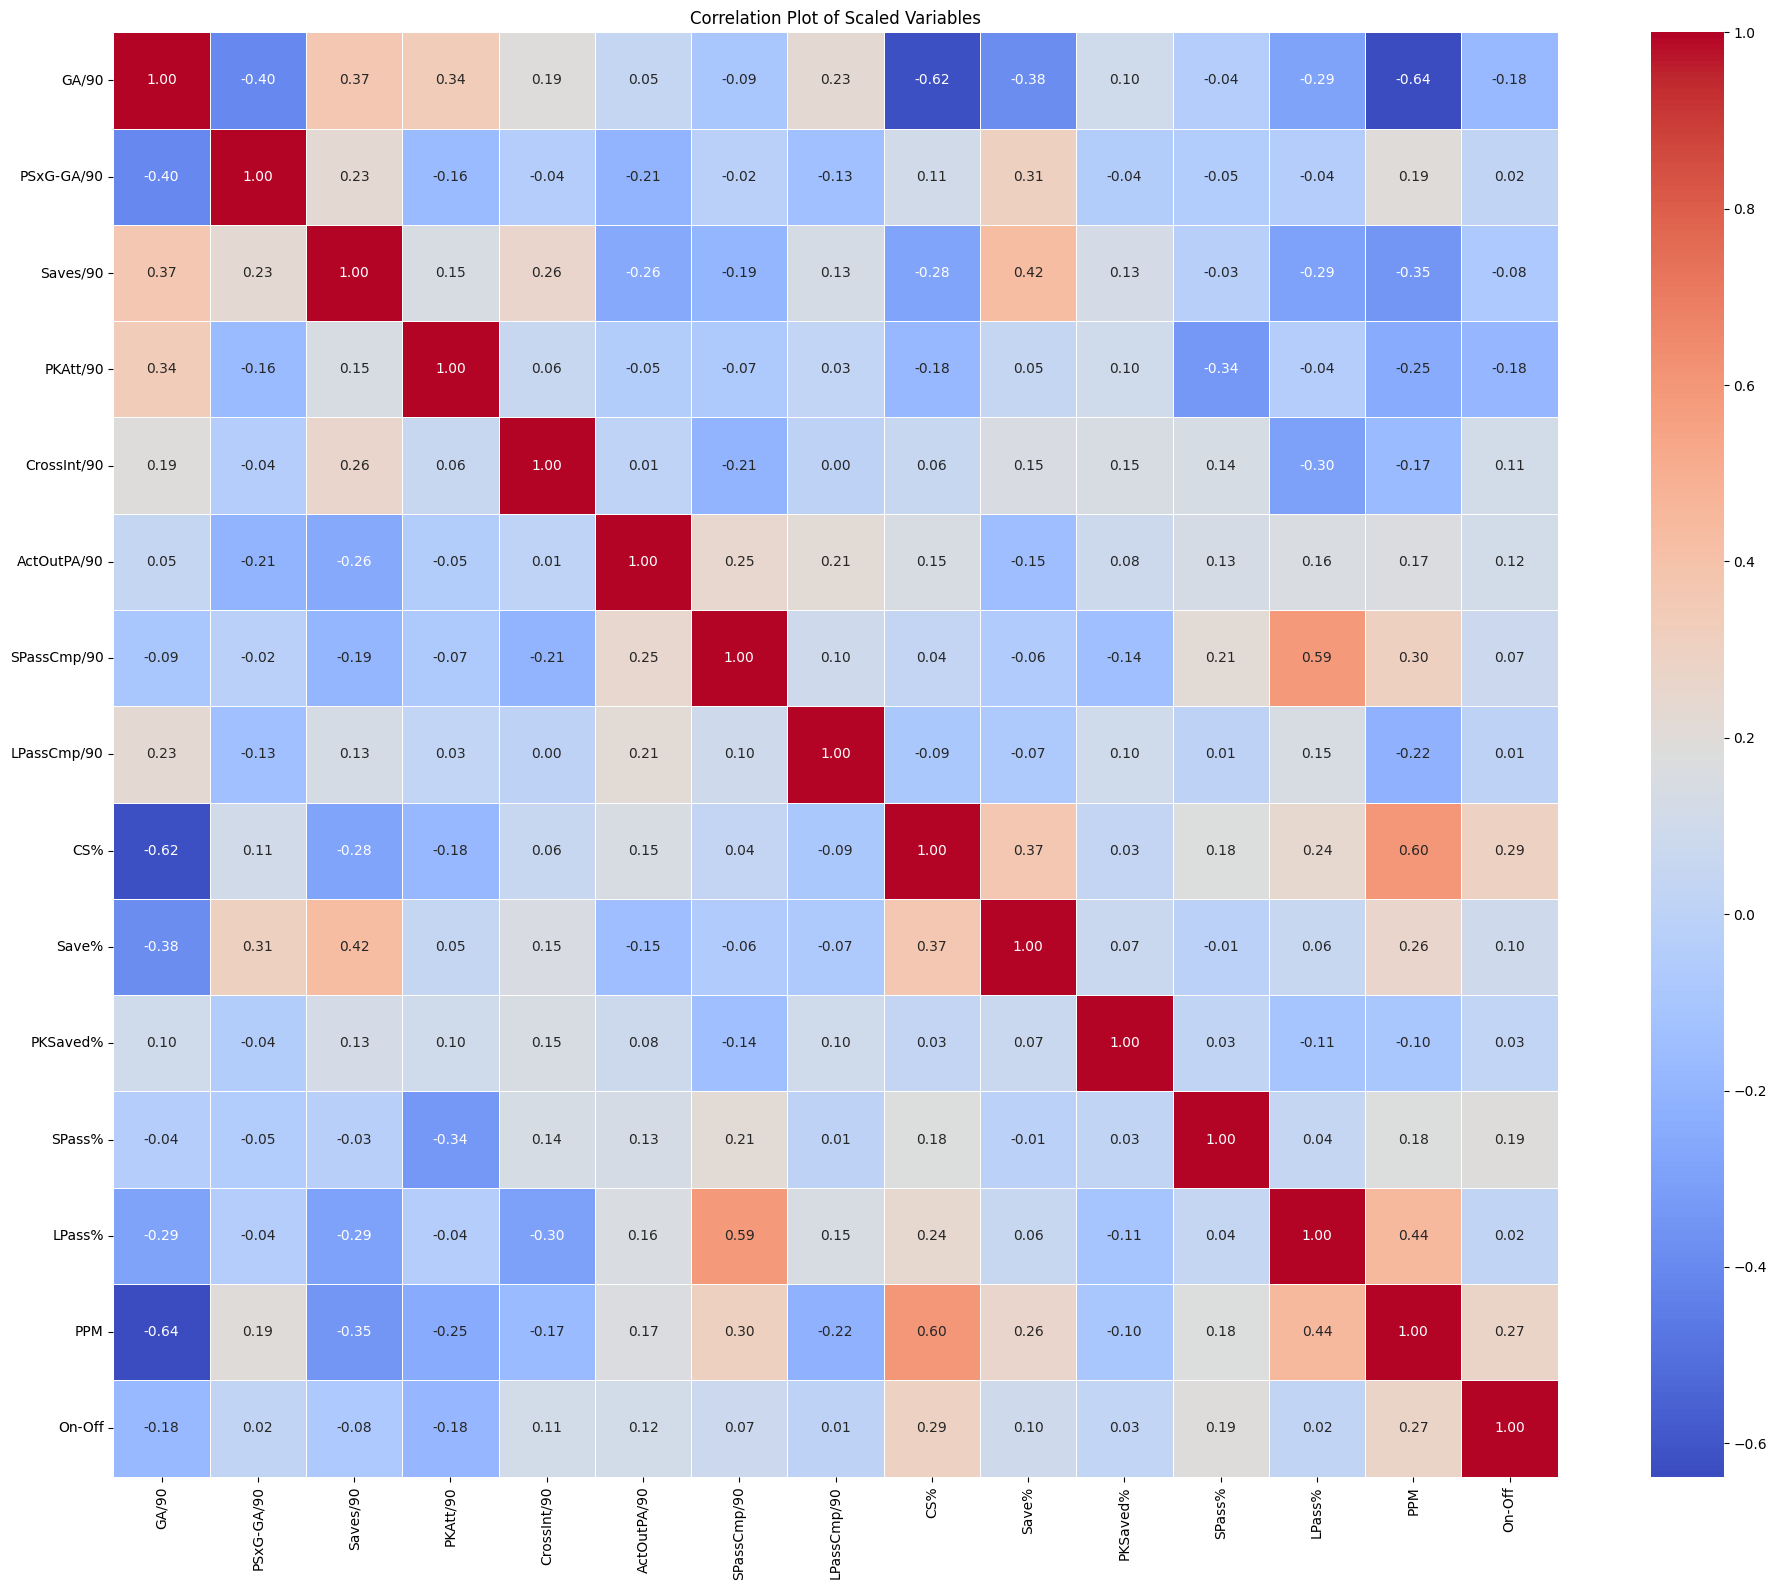

In [17]:
# Plot correlation matrix
plt.figure(figsize=(20, 16))
correlation_matrix_gk = X_scaled_gk.corr()
sns.heatmap(correlation_matrix_gk, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Correlation Plot of Scaled Variables')
plt.tight_layout()
plt.show()

In [18]:
# Variance Inflation Factor
vif_gk = pd.DataFrame()
vif_gk['VIF'] = [variance_inflation_factor(X_scaled_gk.values, i) for i in range(X_scaled_gk.shape[1])]
vif_gk['Variable'] = X_scaled_gk.columns
vif_gk

VIF     Variable
0   3.958390        GA/90
1   1.609046   PSxG-GA/90
2   2.962511     Saves/90
3   1.409383     PKAtt/90
4   1.306410  CrossInt/90
5   1.332783  ActOutPA/90
6   1.814181  SPassCmp/90
7   1.285302  LPassCmp/90
8   2.369037          CS%
9   2.546558        Save%
10  1.087525     PKSaved%
11  1.325985       SPass%
12  2.084788       LPass%
13  2.555473          PPM
14  1.183498       On-Off

KMO Model: 0.634690059746243
Bartlett's Test Chi-square: 1511.134, p-value: 0.000
[3.33005972 2.1622695  1.60403764 1.35977975 1.19382426 0.9237804
 0.83451495 0.75823584 0.71103045 0.58242706 0.50136534 0.33750413
 0.28461188 0.27436869 0.1421904 ]


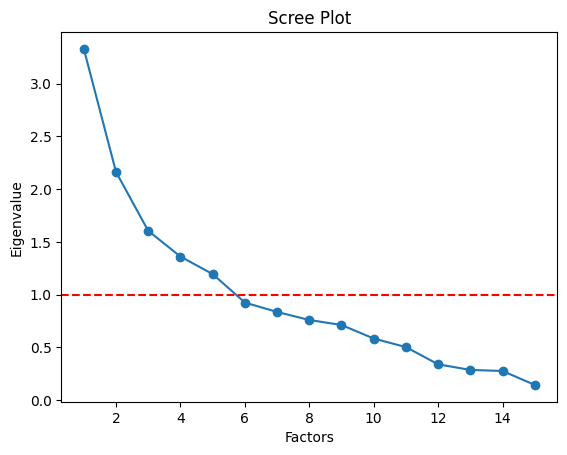

In [19]:
# Step 1: KMO and Bartlett's Test
kmo_all_gk, kmo_model_gk = calculate_kmo(X_scaled_gk)
print(f"KMO Model: {kmo_model_gk}")

chi_square_value_gk, p_value_gk = calculate_bartlett_sphericity(X_scaled_gk)
print(f"Bartlett's Test Chi-square: {chi_square_value_gk:.3f}, p-value: {p_value_gk:.3f}")  # p < 0.05

# Step 2: Scree Plot
fa_gk = FactorAnalyzer(rotation='varimax', method='principal')
fa_gk.fit(X_scaled_gk)
ev_gk, v_gk = fa_gk.get_eigenvalues()
print(ev_gk)

plt.scatter(range(1, len(ev_gk)+1), ev_gk)
plt.plot(range(1, len(ev_gk)+1), ev_gk)
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

In [20]:
n_factors_gk = sum(ev_gk > 1)
print(f"Number of factors: {n_factors_gk}")

Number of factors: 5


In [21]:
# Step 3: Factor Analysis with Varimax Rotation
fa_gk = FactorAnalyzer(n_factors=n_factors_gk, method='principal', rotation='varimax')
fa_gk.fit(X_scaled_gk)
loadings_gk = fa_gk.loadings_

# Step 4: Interpret Loadings
loading_df_gk = pd.DataFrame(loadings_gk, index=goalkeeper_model_metrics, columns=[f'Factor{i+1}' for i in range(n_factors_gk)])
loading_df_gk

Factor1   Factor2   Factor3   Factor4   Factor5
GA/90       -0.851030 -0.194235  0.229097  0.035634 -0.086668
PSxG-GA/90   0.230871  0.673542 -0.232546 -0.095037  0.092710
Saves/90    -0.466207  0.727979  0.319318 -0.007245 -0.014881
PKAtt/90    -0.188475 -0.026435  0.266897  0.069948 -0.734615
CrossInt/90 -0.124965  0.117627  0.624898 -0.245127  0.229773
ActOutPA/90  0.126362 -0.492762  0.307754  0.397697  0.130614
SPassCmp/90  0.091480 -0.057204 -0.260529  0.773750  0.177550
LPassCmp/90 -0.317472 -0.018862  0.294309  0.544558  0.003768
CS%          0.828811  0.007951  0.242902  0.037181  0.121597
Save%        0.397653  0.719252  0.316363  0.069964 -0.104012
PKSaved%     0.012779 -0.043636  0.605039 -0.024641 -0.127637
SPass%       0.012636 -0.029812  0.112431  0.158731  0.786472
LPass%       0.359106 -0.059693 -0.245361  0.748772 -0.095217
PPM          0.810264  0.015873 -0.122039  0.227907  0.168774
On-Off       0.325370 -0.060694  0.301566  0.011369  0.424111

In [23]:
# Get factor scores
factor_scores_gk = fa_gk.transform(X_scaled_gk)

# Create a DataFrame for factor scores
factor_columns_gk = [f'Factor{i+1}' for i in range(n_factors_gk)]
factor_df_gk = pd.DataFrame(factor_scores_gk, columns=factor_columns_gk, index=goalkeeper_data.index)

In [24]:
# Define the mapping of factors to indices
indices_mapping_gk = {
    'Passing_Ability': ['Factor4', 'Factor5'],
    'Shot-Stopping': ['Factor2'],
    'Territorial_Command': ['Factor3'],
    'Team_Impact': ['Factor1']
}

# Initialize the indices DataFrame
indices_df_gk = pd.DataFrame(index=goalkeeper_data.index)

# Compute each index as the average of its factor scores
for index_name, factors in indices_mapping_gk.items():
    # Compute the average of the specified factors
    indices_df_gk[index_name] = factor_df_gk[factors].mean(axis=1)

# Assign the indices to the wing_back_data DataFrame
goalkeeper_data = goalkeeper_data.join(indices_df_gk)

In [25]:
weights_gk = {
    'Passing_Ability': 0.25,
    'Shot-Stopping': 0.35,
    'Territorial_Command': 0.25,
    'Team_Impact': 0.15
}

# Compute the Overall Performance Index as a weighted sum of the indices
goalkeeper_data['Overall_Performance_Index'] = (
    goalkeeper_data['Passing_Ability'] * weights_gk['Passing_Ability'] + 
    goalkeeper_data['Shot-Stopping'] * weights_gk['Shot-Stopping'] + 
    goalkeeper_data['Territorial_Command'] * weights_gk['Territorial_Command'] + 
    goalkeeper_data['Team_Impact'] * weights_gk['Team_Impact']
)

In [26]:
goalkeeper_data[['Player','Passing_Ability', 'Shot-Stopping', 'Territorial_Command', 'Team_Impact', 'Overall_Performance_Index']].groupby('Player').mean().sort_values(by='Overall_Performance_Index', ascending=False).head(10)

Passing_Ability  Shot-Stopping  Territorial_Command  \
Player                                                                  
Alisson                  0.810611      -0.110425             0.312789   
Jan Oblak               -0.842078       0.682024             0.583097   
Hugo Lloris              0.014795       0.678165             0.295198   
Koen Casteels            0.743501      -0.036808             1.096813   
Yann Sommer              1.160131       0.703583            -0.224423   
Jessy Moulin            -0.125958       2.089019            -1.074067   
Yassine Bounou          -0.134063       0.464238             0.495638   
Antonio Mirante          0.445589       0.337123             0.219776   
Walter Benítez          -0.217594       1.006341            -0.100841   
Jasper Cillessen        -0.052933       0.545590             0.334825   

                  Team_Impact  Overall_Performance_Index  
Player                                                    
Alisson              1.465884                   0.462084  
Jan Oblak            1.764941                   0.438704  
Hugo Lloris          0.667668                   0.415006  
Koen Casteels       -0.330257                   0.397657  
Yann Sommer         -0.626116                   0.386264  
Jessy Moulin        -0.669716                   0.330693  
Yassine Bounou       0.455514                   0.321204  
Antonio Mirante      0.065286                   0.294127  
Walter Benítez       0.128396                   0.291870  
Jasper Cillessen     0.140600                   0.282520


Metric Contributions to Overall Performance Index:
             Contribution
Save%            0.381965
Saves/90         0.259160
SPass%           0.255870
CS%              0.227525
On-Off           0.211824
PSxG-GA/90       0.211652
PPM              0.195756
CrossInt/90      0.174811
SPassCmp/90      0.166394
LPassCmp/90      0.156437
LPass%           0.135022
PKSaved%         0.099834
ActOutPA/90      0.055504
PKAtt/90        -0.136966
GA/90           -0.151121


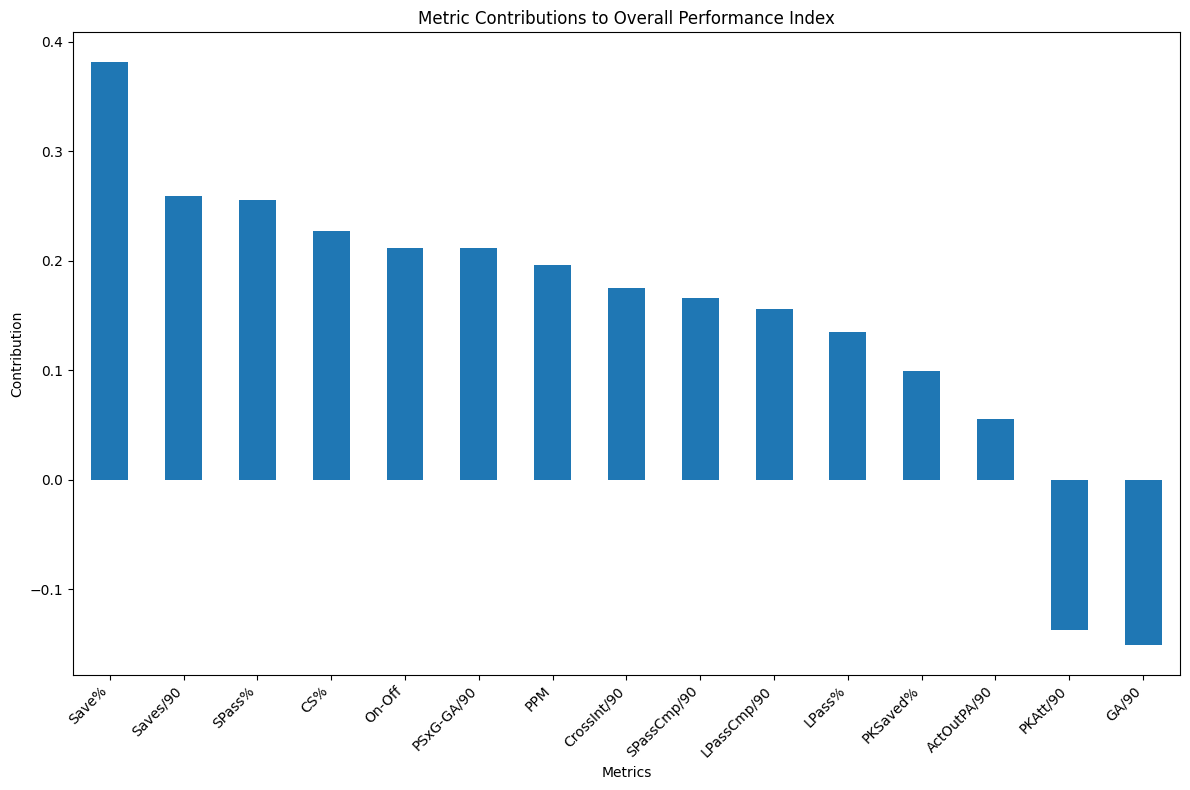

In [27]:
# Calculate the contribution of each metric to the Overall Performance Index
metric_contributions_gk = {}
for metric in goalkeeper_model_metrics:
    # Get the factor loadings for this metric
    loadings = loading_df_gk.loc[metric]
    
    # Calculate the contribution to each index
    index_contributions_gk = {}
    for index_name, factors in indices_mapping_gk.items():
        contribution = sum(loadings[factor] * weights_gk[index_name] for factor in factors)
        index_contributions_gk[index_name] = contribution
    
    # Calculate the total contribution to the Overall Performance Index
    total_contribution = sum(index_contributions_gk.values())
    metric_contributions_gk[metric] = total_contribution

# Create a DataFrame of metric contributions
metric_contributions_df_gk = pd.DataFrame.from_dict(metric_contributions_gk, orient='index', columns=['Contribution'])
metric_contributions_df_gk = metric_contributions_df_gk.sort_values('Contribution', ascending=False)

print("\nMetric Contributions to Overall Performance Index:")
print(metric_contributions_df_gk)

# Visualize the contributions
plt.figure(figsize=(12, 8))
metric_contributions_df_gk['Contribution'].plot(kind='bar')
plt.title('Metric Contributions to Overall Performance Index')
plt.xlabel('Metrics')
plt.ylabel('Contribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [28]:
# Define X for central-back
X_cb = position_df['Centre-Back'][outfield_model_metrics]

X_scaled_cb = scaler.fit_transform(X_cb)

X_scaled_cb = pd.DataFrame(X_scaled_cb, columns=X_cb.columns, index=X_cb.index)

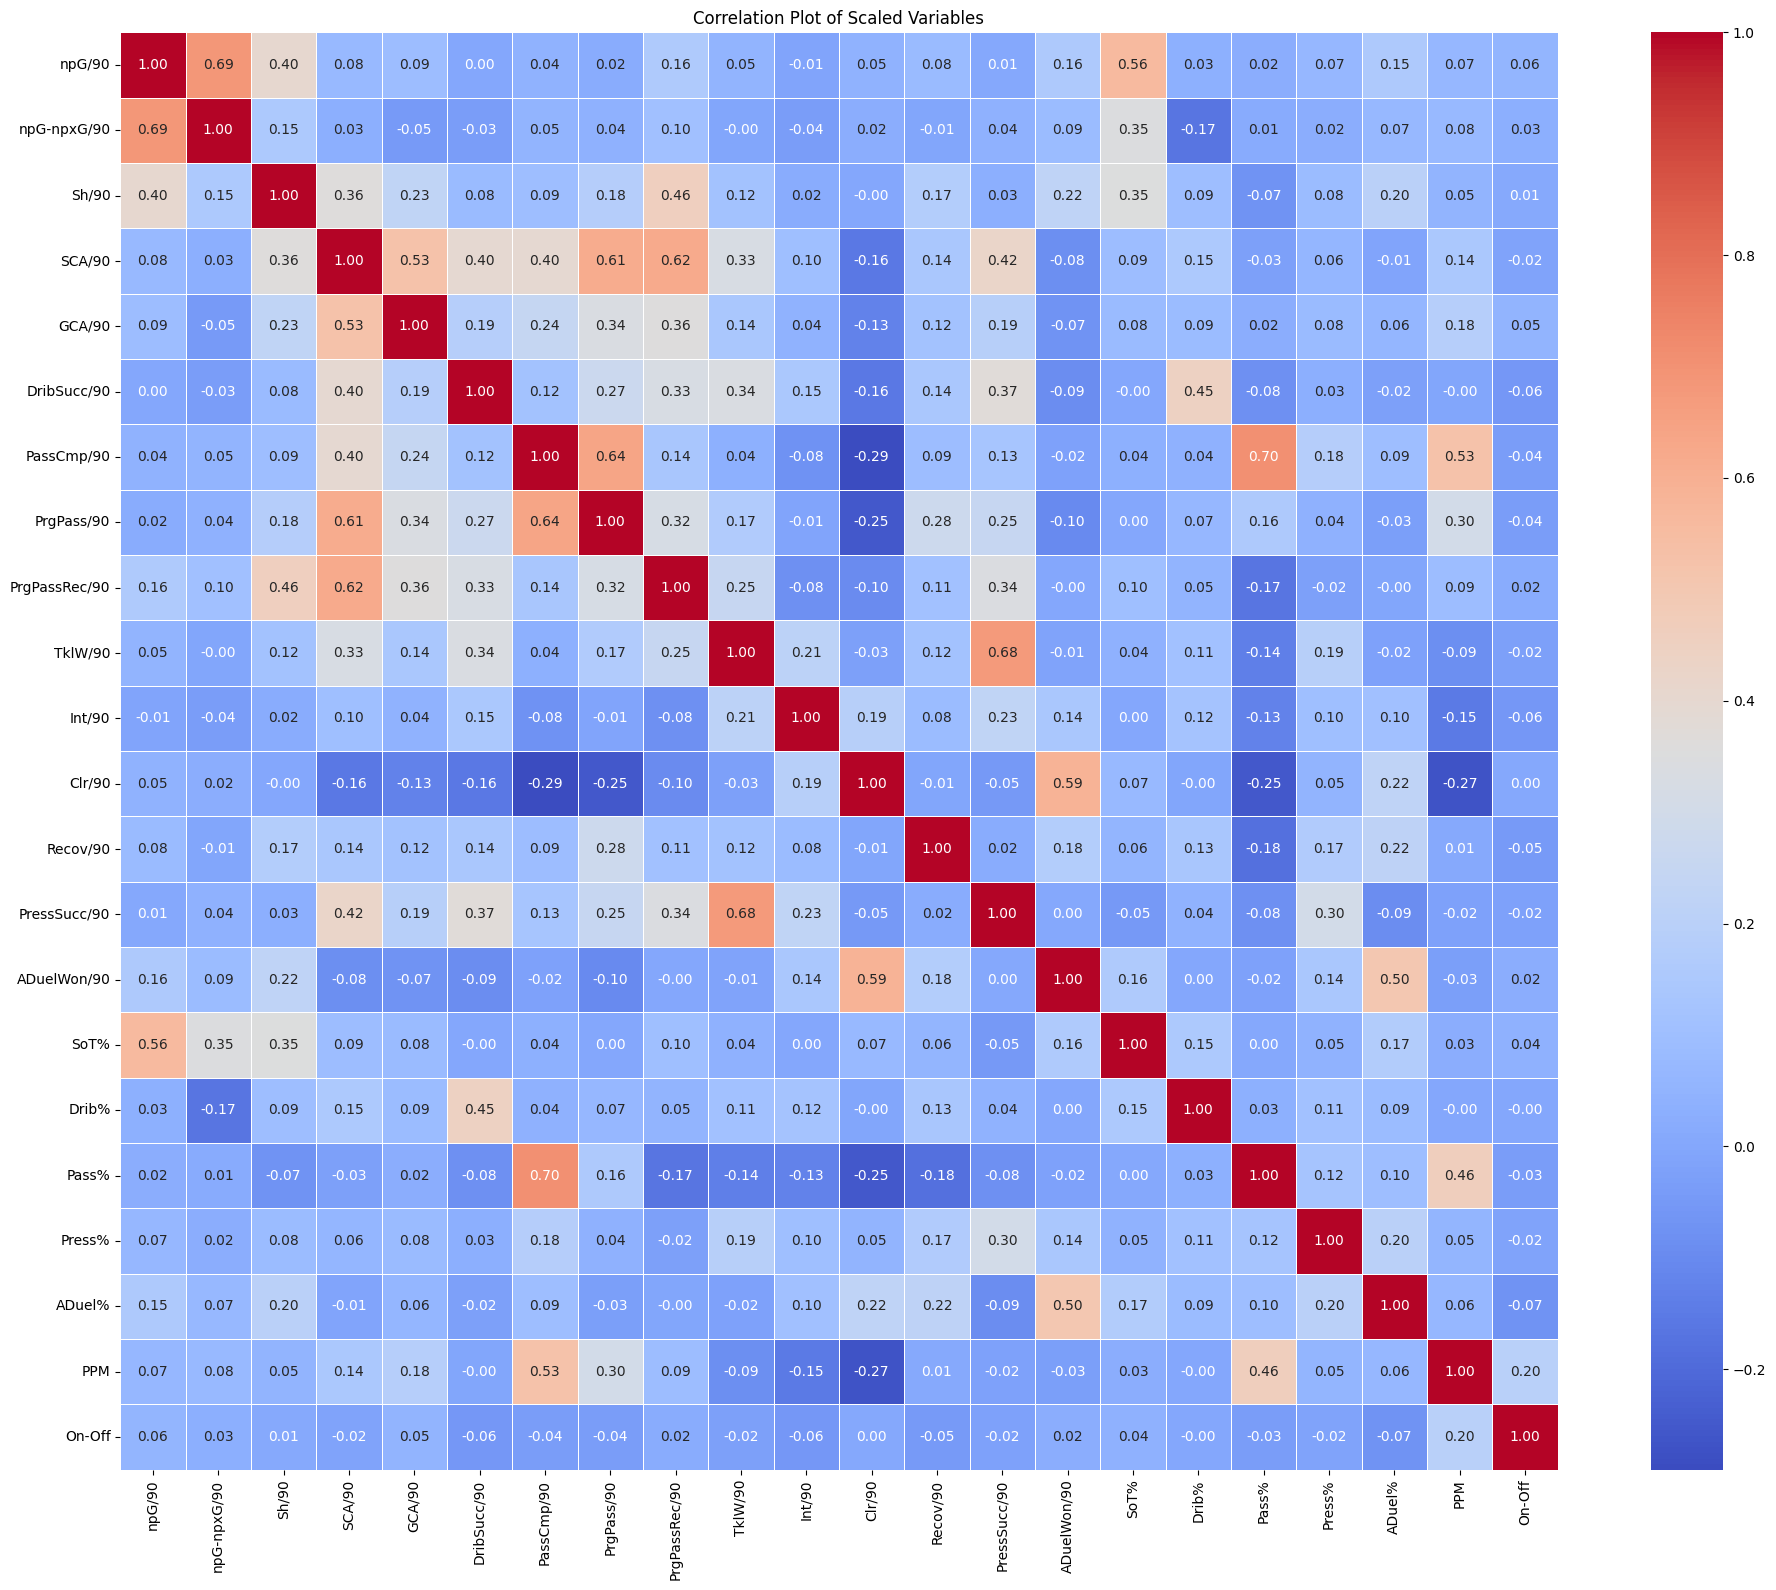

VIF       Variable
0   2.852572         npG/90
1   2.224433    npG-npxG/90
2   1.842678          Sh/90
3   3.240941         SCA/90
4   1.486649         GCA/90
5   1.742969    DribSucc/90
6   5.379582     PassCmp/90
7   2.985624     PrgPass/90
8   2.201367  PrgPassRec/90
9   2.007711        TklW/90
10  1.223759         Int/90
11  1.987281         Clr/90
12  1.401227       Recov/90
13  2.654059   PressSucc/90
14  2.312686    ADuelWon/90
15  1.573127           SoT%
16  1.502657          Drib%
17  3.554198          Pass%
18  1.335007         Press%
19  1.534167         ADuel%
20  1.618876            PPM
21  1.101509         On-Off

In [29]:
# Plot correlation matrix
plt.figure(figsize=(20, 16))
correlation_matrix_cb = X_scaled_cb.corr()
sns.heatmap(correlation_matrix_cb, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Correlation Plot of Scaled Variables')
plt.tight_layout()
plt.show()

# Variance Inflation Factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_scaled_cb.values, i) for i in range(X_scaled_cb.shape[1])]
vif['Variable'] = X_scaled_cb.columns
vif

KMO Model for Centre-Back: 0.6626341814154703
Bartlett's Test Chi-square for Centre-Back: 7386.105, p-value: 0.000
Eigenvalues for Centre-Back: [3.87197862 2.66223139 2.42558088 1.8077799  1.39991089 1.26441376
 1.09788946 0.98094038 0.89720728 0.8439825  0.68721599 0.67227477
 0.6146486  0.50556267 0.45589852 0.39982624 0.36302099 0.29612756
 0.22930246 0.2133525  0.19975389 0.11110078]


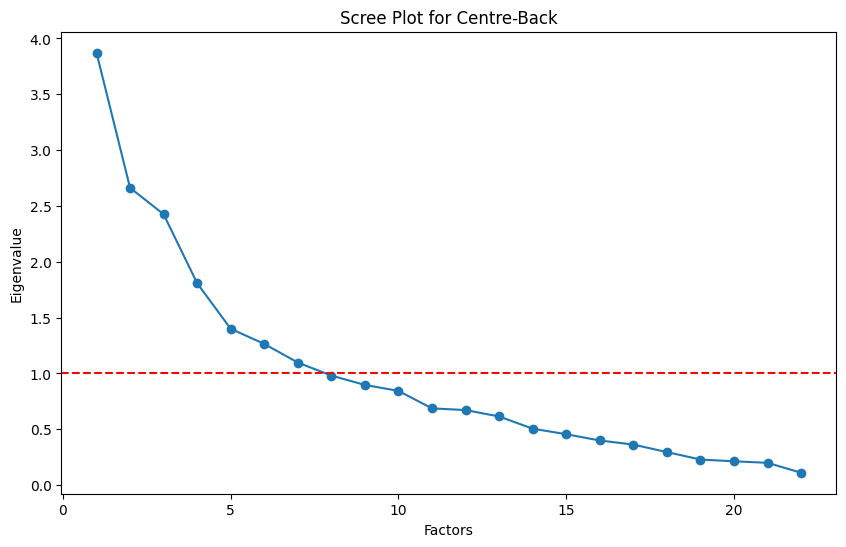

Number of factors: 7


In [30]:
# Step 1: KMO and Bartlett's Test
kmo_all_cb, kmo_model_cb = calculate_kmo(X_scaled_cb)
print(f"KMO Model for Centre-Back: {kmo_model_cb}")

# Calculate Bartlett's Test
chi_square_value_cb, p_value_cb = calculate_bartlett_sphericity(X_scaled_cb)
print(f"Bartlett's Test Chi-square for Centre-Back: {chi_square_value_cb:.3f}, p-value: {p_value_cb:.3f}")  # p < 0.05


# Step 2: Scree Plot
fa_cb = FactorAnalyzer(rotation='varimax', method='principal')
fa_cb.fit(X_scaled_cb)

ev_cb, v_cb = fa_cb.get_eigenvalues()
print(f"Eigenvalues for Centre-Back: {ev_cb}")

plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(ev_cb)+1), ev_cb)
plt.plot(range(1, len(ev_cb)+1), ev_cb)
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Scree Plot for Centre-Back')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

n_factors_cb = sum(ev_cb > 1)
print(f"Number of factors: {n_factors_cb}")

In [31]:
# Step 3: Factor Analysis with Varimax Rotation
fa_cb = FactorAnalyzer(n_factors=n_factors_cb, method='principal', rotation='varimax')
fa_cb.fit(X_scaled_cb)
loadings_cb = fa_cb.loadings_

# Step 4: Interpret Loadings
loading_df_cb = pd.DataFrame(loadings_cb, index=outfield_model_metrics, columns=[f'Factor{i+1}' for i in range(n_factors_cb)])
loading_df_cb

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
npG/90         0.085574  0.905023  0.024882  0.082628  0.015820  0.004554   
npG-npxG/90   -0.019748  0.807205  0.050519 -0.051222  0.086217 -0.250912   
Sh/90          0.549523  0.420013 -0.065941  0.257499 -0.098457  0.082832   
SCA/90         0.819401  0.020455  0.127652 -0.088824  0.259357  0.100461   
GCA/90         0.637008 -0.032834  0.141916  0.017845  0.047389  0.081817   
DribSucc/90    0.321762 -0.016359 -0.035370 -0.189691  0.341787  0.614768   
PassCmp/90     0.298388  0.002482  0.867965 -0.011363  0.072238 -0.005614   
PrgPass/90     0.632434 -0.054485  0.437881 -0.104187  0.103831  0.018343   
PrgPassRec/90  0.792253  0.145782 -0.121637 -0.068964  0.113942 -0.016530   
TklW/90        0.229683  0.043439 -0.101757 -0.072144  0.775903  0.082517   
Int/90        -0.068436 -0.063090 -0.142335  0.248898  0.450476  0.187811   
Clr/90        -0.149331 -0.007862 -0.359464  0.664584  0.089948 -0.127496   
Recov/90       0.310232 -0.010133 -0.017965  0.327329 -0.026737  0.215512   
PressSucc/90   0.280214 -0.018075  0.004230 -0.108651  0.860977 -0.036029   
ADuelWon/90   -0.000922  0.104019 -0.037151  0.856698  0.059665 -0.086170   
SoT%           0.066473  0.728191 -0.000523  0.145716 -0.069830  0.223781   
Drib%          0.020830  0.016638  0.031938  0.054363  0.050253  0.907375   
Pass%         -0.185354  0.027959  0.861637 -0.030334 -0.048320  0.007169   
Press%        -0.089633  0.053295  0.287219  0.305826  0.487778  0.068479   
ADuel%         0.026683  0.120256  0.163989  0.718747 -0.044005  0.109993   
PPM            0.185441  0.036683  0.709065 -0.022112 -0.124975 -0.018272   
On-Off         0.076889  0.018753  0.037971  0.032728 -0.049244  0.035459   

                Factor7  
npG/90         0.017773  
npG-npxG/90   -0.036670  
Sh/90         -0.016752  
SCA/90        -0.054731  
GCA/90         0.111752  
DribSucc/90   -0.089135  
PassCmp/90    -0.133769  
PrgPass/90    -0.240672  
PrgPassRec/90  0.052794  
TklW/90       -0.005910  
Int/90        -0.080170  
Clr/90         0.121771  
Recov/90      -0.387001  
PressSucc/90   0.038544  
ADuelWon/90    0.055840  
SoT%           0.052753  
Drib%          0.027278  
Pass%          0.000191  
Press%        -0.048708  
ADuel%        -0.148824  
PPM            0.287886  
On-Off         0.872615

In [32]:
# Step 4: Define Indices
factor_scores_cb = fa_cb.transform(X_scaled_cb)

# Create a DataFrame for factor scores
factor_columns_cb = [f'Factor{i+1}' for i in range(n_factors_cb)]
factor_df_cb = pd.DataFrame(factor_scores_cb, columns=factor_columns_cb, index=position_df['Centre-Back'].index)

# Define the mapping of factors to indices
indices_mapping_cb = {
    'Passing_Ability': ['Factor3'],
    'Defensive_Performance': ['Factor4', 'Factor5'],
    'Offensive_Contribution': ['Factor1', 'Factor2', 'Factor6'],
    'Team_Impact': ['Factor7']
}

# Initialize the indices DataFrame
indices_df_cb = pd.DataFrame(index=position_df['Centre-Back'].index)

# Compute each index as the average of its factor scores
for index_name, factors in indices_mapping_cb.items():
    # Compute the average of the specified factors
    indices_df_cb[index_name] = factor_df_cb[factors].mean(axis=1)

# Assign the indices to the central_defender_data DataFrame
position_df['Centre-Back'] = position_df['Centre-Back'].join(indices_df_cb)

In [33]:
# Define weights for each index (ensure they sum to 1)
weights_cb = {
    'Offensive_Contribution': 0.15,
    'Passing_Ability': 0.25,
    'Defensive_Performance': 0.5,
    'Team_Impact': 0.1
}

# Compute the Overall Performance Index as a weighted sum of the indices
position_df['Centre-Back']['Overall_Performance_Index'] = (
    position_df['Centre-Back']['Offensive_Contribution'] * weights_cb['Offensive_Contribution'] +
    position_df['Centre-Back']['Passing_Ability'] * weights_cb['Passing_Ability'] +
    position_df['Centre-Back']['Defensive_Performance'] * weights_cb['Defensive_Performance'] +
    position_df['Centre-Back']['Team_Impact'] * weights_cb['Team_Impact']
)

In [34]:
position_df['Centre-Back'][['Player','Offensive_Contribution', 'Passing_Ability', 'Defensive_Performance', 'Team_Impact', 'Overall_Performance_Index']].groupby('Player').mean().sort_values(by='Overall_Performance_Index', ascending=False).head(10)

Offensive_Contribution  Passing_Ability  \
Player                                                        
Mats Hummels                      0.662668         1.401944   
Joël Matip                       -0.073840         1.290659   
Nacho                             1.035149         0.476790   
José Luis Palomino               -0.116669         0.311386   
Willi Orban                       0.554493         0.267894   
John Stones                       0.127595         2.337973   
Dayot Upamecano                   0.522482         0.743172   
Virgil van Dijk                   0.387615         1.482507   
Shkodran Mustafi                  0.045336        -0.192126   
Thiago Silva                     -0.054711         2.238870   

                    Defensive_Performance  Team_Impact  \
Player                                                   
Mats Hummels                     0.978480    -0.961281   
Joël Matip                       1.001209     0.249987   
Nacho                            0.914867     0.805252   
José Luis Palomino               1.282366    -0.089806   
Willi Orban                      1.054411    -0.321080   
John Stones                      0.040881     0.115992   
Dayot Upamecano                  0.860430    -1.033122   
Virgil van Dijk                  0.324234    -0.187513   
Shkodran Mustafi                 1.185766     0.172355   
Thiago Silva                    -0.110547     0.279258   

                    Overall_Performance_Index  
Player                                         
Mats Hummels                         0.842998  
Joël Matip                           0.837192  
Nacho                                0.812429  
José Luis Palomino                   0.692549  
Willi Orban                          0.645245  
John Stones                          0.635672  
Dayot Upamecano                      0.591068  
Virgil van Dijk                      0.572134  
Shkodran Mustafi                     0.568887  
Thiago Silva                         0.524163


Metric Contributions to Overall Performance Index:
               Contribution
Press%             0.468557
ADuelWon/90        0.457017
PressSucc/90       0.414991
ADuel%             0.402025
TklW/90            0.379195
Int/90             0.314529
PassCmp/90         0.278340
Clr/90             0.256874
SCA/90             0.252754
Sh/90              0.219216
npG/90             0.206494
Drib%              0.204746
DribSucc/90        0.196318
SoT%               0.195854
Recov/90           0.184447
GCA/90             0.182170
PrgPass/90         0.174669
PPM                0.163089
Pass%              0.153567
PrgPassRec/90      0.135585
On-Off             0.108161
npG-npxG/90        0.106942


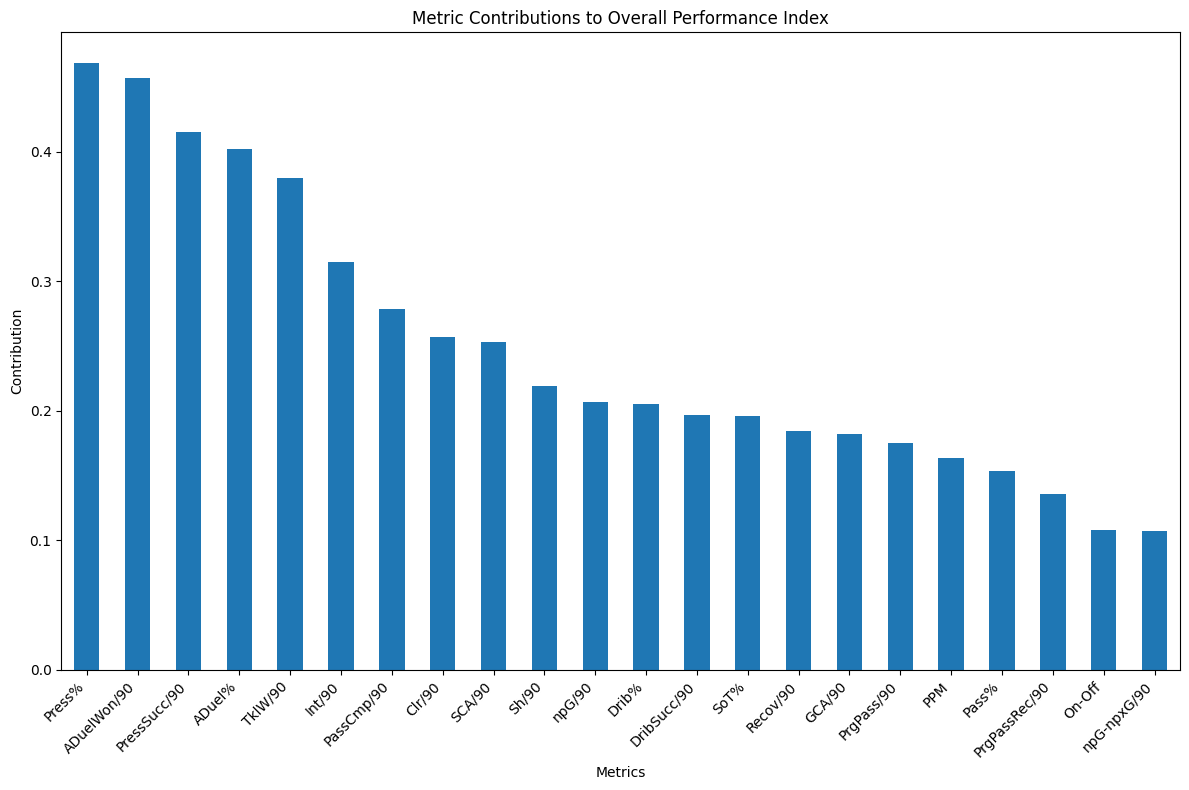

In [35]:
# Calculate the contribution of each metric to the Overall Performance Index
metric_contributions_cb = {}
for metric in outfield_model_metrics:
    # Get the factor loadings for this metric
    loadings = loading_df_cb.loc[metric]
    
    # Calculate the contribution to each index
    index_contributions_cb = {}
    for index_name, factors in indices_mapping_cb.items():
        contribution = sum(loadings[factor] * weights_cb[index_name] for factor in factors)
        index_contributions_cb[index_name] = contribution
    
    # Calculate the total contribution to the Overall Performance Index
    total_contribution = sum(index_contributions_cb.values())
    metric_contributions_cb[metric] = total_contribution

# Create a DataFrame of metric contributions
metric_contributions_df_cb = pd.DataFrame.from_dict(metric_contributions_cb, orient='index', columns=['Contribution'])
metric_contributions_df_cb = metric_contributions_df_cb.sort_values('Contribution', ascending=False)

print("\nMetric Contributions to Overall Performance Index:")
print(metric_contributions_df_cb)

# Visualize the contributions
plt.figure(figsize=(12, 8))
metric_contributions_df_cb['Contribution'].plot(kind='bar')
plt.title('Metric Contributions to Overall Performance Index')
plt.xlabel('Metrics')
plt.ylabel('Contribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
# Extract the relevant metrics for wing-backs
X_wb = position_df['Wing-Back'][outfield_model_metrics]

X_scaled_wb = StandardScaler().fit_transform(X_wb)

X_scaled_wb = pd.DataFrame(X_scaled_wb, columns=X_wb.columns, index=X_wb.index)

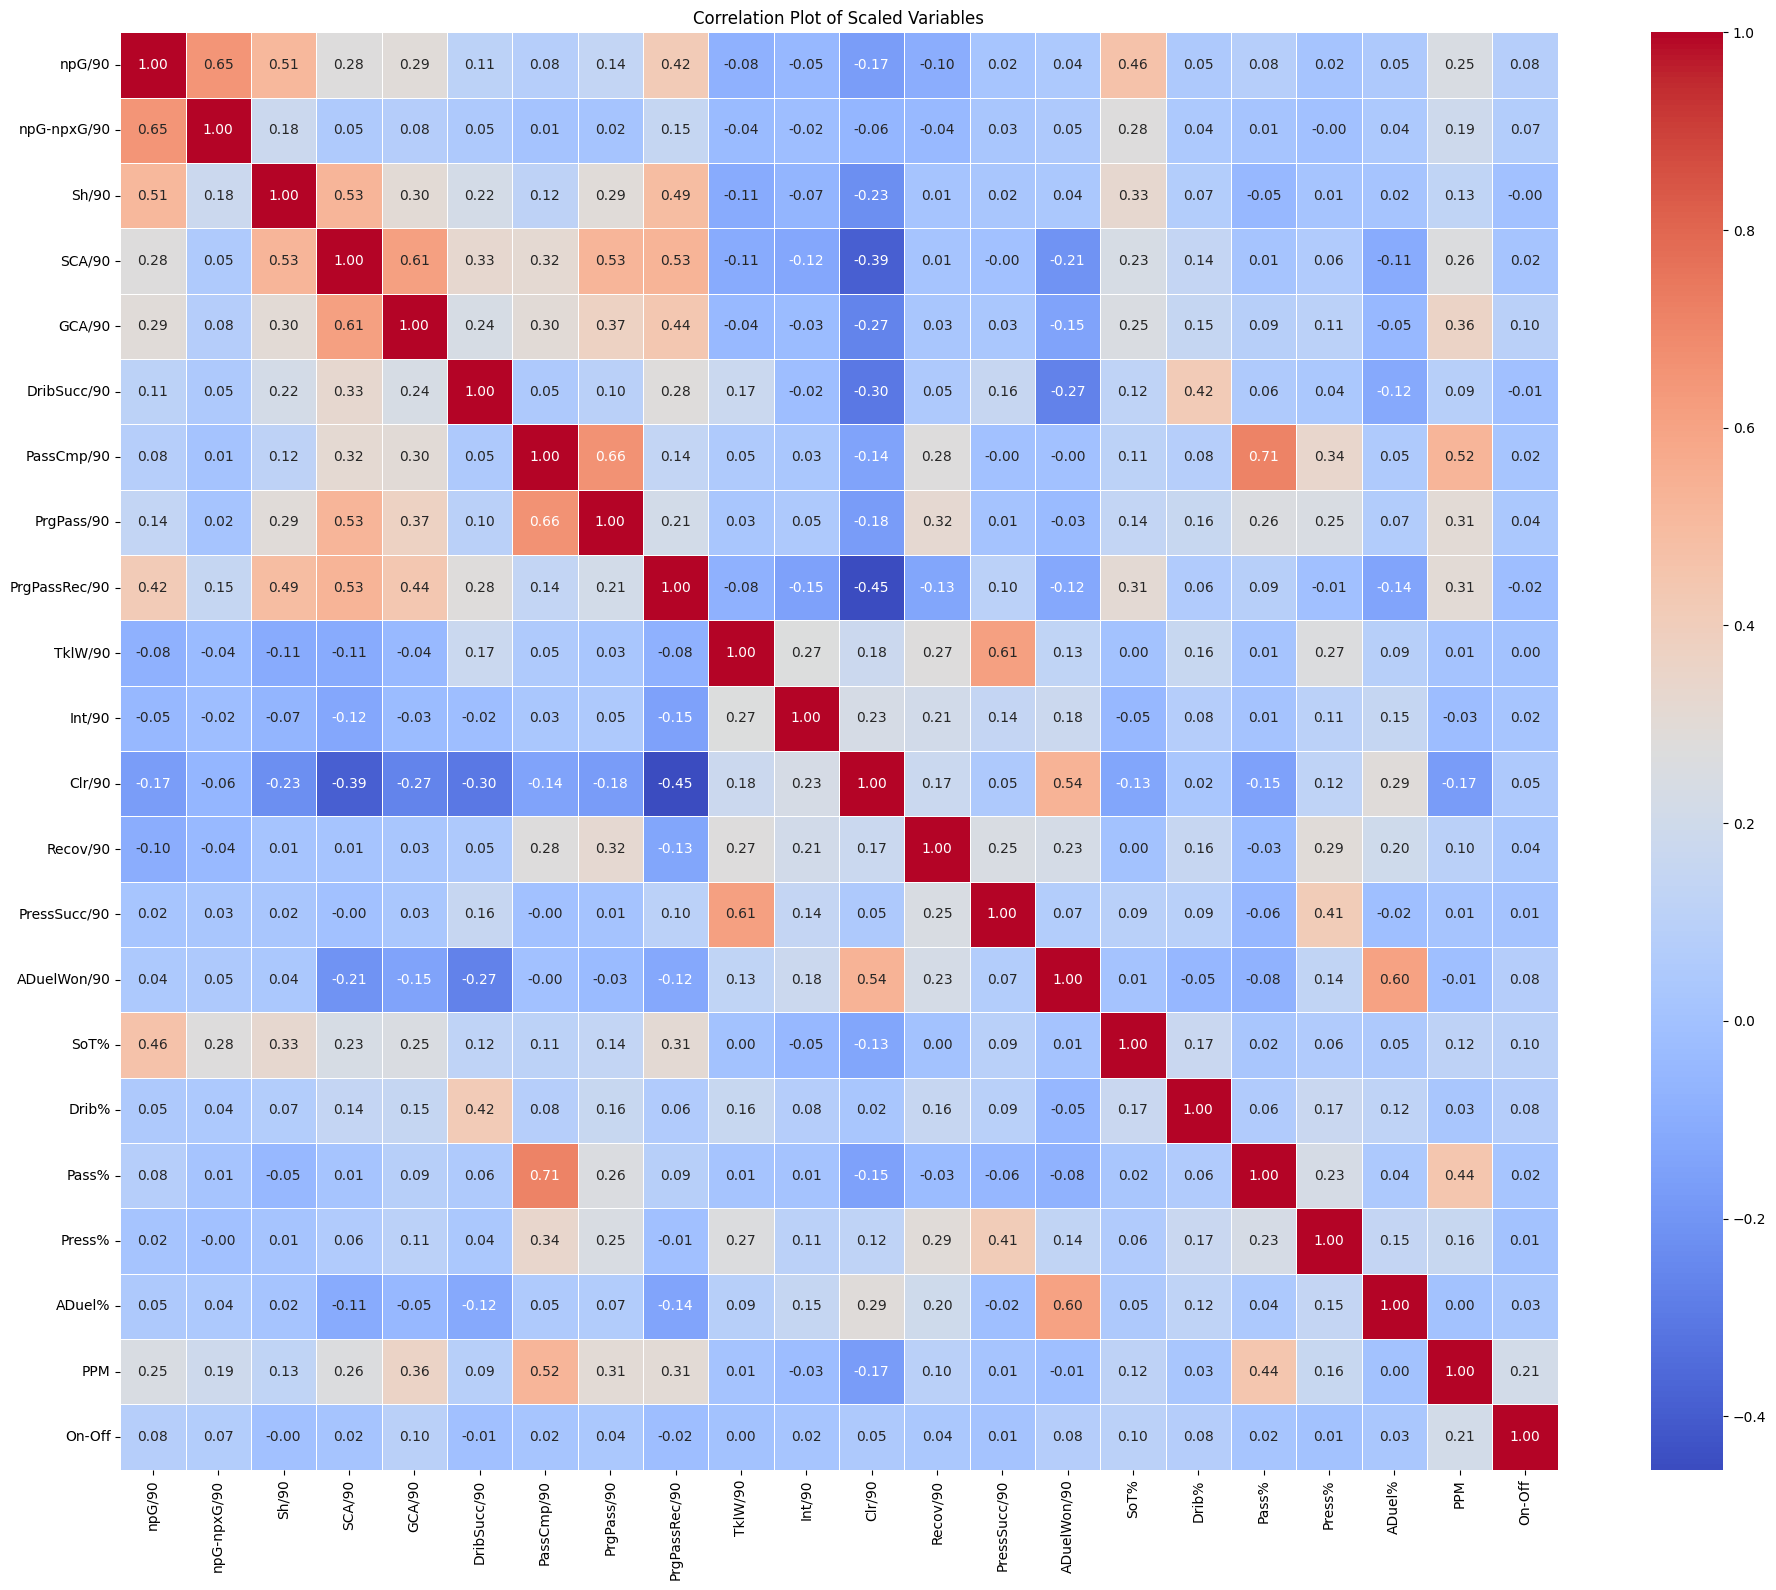

VIF       Variable
0   2.942327         npG/90
1   1.932786    npG-npxG/90
2   2.016573          Sh/90
3   2.909674         SCA/90
4   1.874236         GCA/90
5   1.607804    DribSucc/90
6   5.356819     PassCmp/90
7   2.717902     PrgPass/90
8   2.152119  PrgPassRec/90
9   1.870911        TklW/90
10  1.161780         Int/90
11  2.002152         Clr/90
12  1.569052       Recov/90
13  2.028725   PressSucc/90
14  2.430696    ADuelWon/90
15  1.394365           SoT%
16  1.409302          Drib%
17  3.264725          Pass%
18  1.510591         Press%
19  1.771613         ADuel%
20  1.779356            PPM
21  1.111649         On-Off

In [37]:
# Plot correlation matrix
plt.figure(figsize=(20, 16))
correlation_matrix_wb = X_scaled_wb.corr()
sns.heatmap(correlation_matrix_wb, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Correlation Plot of Scaled Variables')
plt.tight_layout()
plt.show()

# Variance Inflation Factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_scaled_wb.values, i) for i in range(X_scaled_wb.shape[1])]
vif['Variable'] = X_scaled_wb.columns
vif

KMO Model for Wing-backs: 0.6981239771337605
Bartlett's Test Chi-square for Wing-backs: 6716.622, p-value: 0.000
Eigenvalues for Wing-backs: [4.28499974 2.85681242 2.0727061  1.89502425 1.37257904 1.16039886
 1.04019427 0.91154858 0.8704186  0.74669555 0.6938393  0.6329095
 0.57845315 0.55744353 0.456584   0.37991294 0.37068372 0.2968211
 0.25622127 0.24621147 0.20647219 0.11307043]


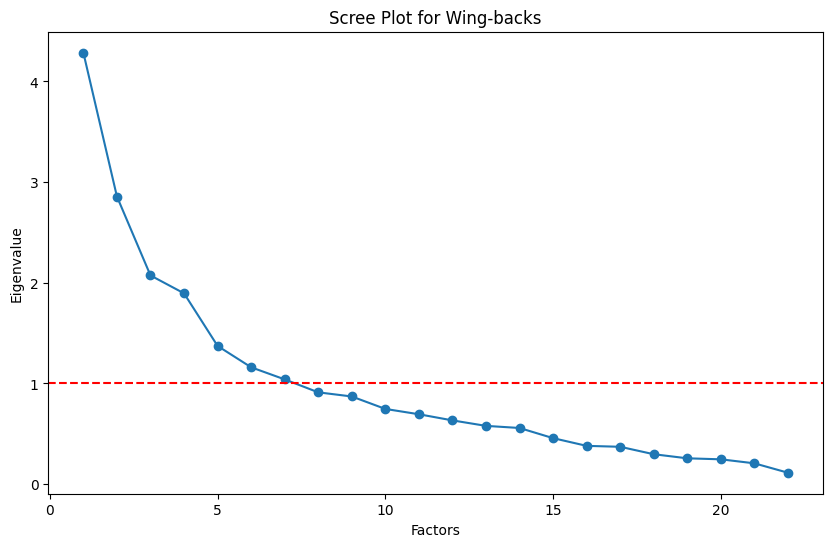

Number of factors: 7


In [38]:
# Step 1: KMO and Bartlett's Test
kmo_all_wb, kmo_model_wb = calculate_kmo(X_scaled_wb)
print(f"KMO Model for Wing-backs: {kmo_model_wb}")

# Calculate Bartlett's Test
chi_square_value_wb, p_value_wb = calculate_bartlett_sphericity(X_scaled_wb)
print(f"Bartlett's Test Chi-square for Wing-backs: {chi_square_value_wb:.3f}, p-value: {p_value_wb:.3f}")  # p < 0.05


# Step 2: Scree Plot
fa_wb = FactorAnalyzer(rotation='varimax', method='principal')
fa_wb.fit(X_scaled_wb)

ev_wb, v_wb = fa_wb.get_eigenvalues()
print(f"Eigenvalues for Wing-backs: {ev_wb}")

plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(ev_wb)+1), ev_wb)
plt.plot(range(1, len(ev_wb)+1), ev_wb)
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Scree Plot for Wing-backs')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

n_factors_wb = sum(ev_wb > 1)
print(f"Number of factors: {n_factors_wb}")

In [39]:
# Step 3: Factor Analysis with Varimax Rotation
fa_wb = FactorAnalyzer(n_factors=n_factors_wb, method='principal', rotation='varimax')
fa_wb.fit(X_scaled_wb)
loadings_wb = fa_wb.loadings_

# Step 4: Interpret Loadings
loading_df_wb = pd.DataFrame(loadings_wb, index=outfield_model_metrics, columns=[f'Factor{i+1}' for i in range(n_factors_wb)])
loading_df_wb

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
npG/90         0.275486  0.015762  0.857355 -0.045909  0.062119 -0.012875   
npG-npxG/90   -0.070528  0.021286  0.805672 -0.009410  0.068994  0.011819   
Sh/90          0.679898  0.059886  0.392520 -0.051816 -0.093599  0.022277   
SCA/90         0.855609 -0.165599  0.049360 -0.054251  0.100993  0.133394   
GCA/90         0.680015 -0.123118  0.098552  0.020008  0.169327  0.108997   
DribSucc/90    0.230026 -0.294290  0.089864  0.157636 -0.019927  0.721295   
PassCmp/90     0.284713  0.072375 -0.053330  0.075907  0.889364  0.012610   
PrgPass/90     0.616892  0.161617 -0.124076  0.057256  0.508970  0.084389   
PrgPassRec/90  0.612566 -0.310124  0.378491  0.027127  0.037265 -0.001222   
TklW/90       -0.119422  0.069630 -0.021736  0.808842 -0.008553  0.146967   
Int/90        -0.090826  0.320886 -0.075603  0.314209  0.013488  0.101394   
Clr/90        -0.349805  0.647491 -0.106494  0.135028 -0.142983 -0.096499   
Recov/90       0.198814  0.428271 -0.235459  0.415698  0.154027  0.103367   
PressSucc/90   0.037553 -0.072320  0.100495  0.890676 -0.090539 -0.014714   
ADuelWon/90   -0.050931  0.819663  0.126968  0.090459 -0.054975 -0.207494   
SoT%           0.280810  0.042377  0.566586  0.048551  0.000503  0.149984   
Drib%          0.057177  0.139131  0.049632  0.080630  0.057825  0.871499   
Pass%         -0.134419 -0.100507  0.087064 -0.029378  0.879836  0.065001   
Press%         0.077986  0.189270 -0.002602  0.558217  0.370415  0.027577   
ADuel%        -0.024016  0.775172  0.108103 -0.045772  0.072069  0.101356   
PPM            0.223011 -0.091870  0.220731  0.051459  0.631464 -0.077304   
On-Off         0.016233  0.065916  0.071556 -0.009761  0.016620  0.033416   

                Factor7  
npG/90         0.014078  
npG-npxG/90    0.057252  
Sh/90         -0.144652  
SCA/90         0.012016  
GCA/90         0.236572  
DribSucc/90   -0.040627  
PassCmp/90    -0.022314  
PrgPass/90    -0.024074  
PrgPassRec/90 -0.057443  
TklW/90        0.024469  
Int/90         0.089078  
Clr/90         0.100742  
Recov/90       0.048679  
PressSucc/90  -0.014285  
ADuelWon/90    0.022729  
SoT%           0.061348  
Drib%          0.060546  
Pass%         -0.056341  
Press%        -0.094564  
ADuel%        -0.076498  
PPM            0.361146  
On-Off         0.919933

In [40]:
# Step 7: Get Factor Scores for Wing-backs
factor_scores_wb = fa_wb.transform(X_scaled_wb)

# Create a DataFrame for factor scores
factor_columns_wb = [f'Factor{i+1}' for i in range(n_factors_wb)]
factor_df_wb = pd.DataFrame(factor_scores_wb, columns=factor_columns_wb, index=position_df['Wing-Back'].index)

# Step 4: Define Indices

# Define the mapping of factors to indices
indices_mapping_wb = {
    'Passing_Ability': ['Factor5'],
    'Defensive_Performance': ['Factor2', 'Factor4'],
    'Offensive_Contribution': ['Factor1', 'Factor3', 'Factor6'],
    'Team_Impact': ['Factor7']
}

# Initialize the indices DataFrame
indices_df_wb = pd.DataFrame(index=position_df['Wing-Back'].index)

# Compute each index as the average of its factor scores
for index_name, factors in indices_mapping_wb.items():
    # Compute the average of the specified factors
    indices_df_wb[index_name] = factor_df_wb[factors].mean(axis=1)

# Assign the indices to the wing_back_data DataFrame
position_df['Wing-Back'] = position_df['Wing-Back'].join(indices_df_wb)

In [41]:
weights_wb = {
    'Offensive_Contribution': 0.3,
    'Passing_Ability': 0.25,
    'Defensive_Performance': 0.35,
    'Team_Impact': 0.1
}

# Compute the Overall Performance Index as a weighted sum of the indices
position_df['Wing-Back']['Overall_Performance_Index'] = (
    position_df['Wing-Back']['Offensive_Contribution'] * weights_wb['Offensive_Contribution'] + 
    position_df['Wing-Back']['Passing_Ability'] * weights_wb['Passing_Ability'] + 
    position_df['Wing-Back']['Defensive_Performance'] * weights_wb['Defensive_Performance'] + 
    position_df['Wing-Back']['Team_Impact'] * weights_wb['Team_Impact']
)

In [42]:
position_df['Wing-Back'][['Player','Offensive_Contribution', 'Passing_Ability', 'Defensive_Performance', 'Team_Impact', 'Overall_Performance_Index']].groupby('Player').mean().sort_values(by='Overall_Performance_Index', ascending=False).head(10)

Offensive_Contribution  Passing_Ability  \
Player                                                         
Oleksandr Zinchenko               -0.204751         3.010598   
Marcel Halstenberg                 0.612684         0.858616   
Danilo                             0.325443         2.226462   
César Azpilicueta                 -0.194363         1.389175   
Kyle Walker                        0.049040         2.396514   
Łukasz Piszczek                   -0.221035         1.205937   
Alex Sandro                        0.431559         1.459953   
João Cancelo                       0.908686         1.168322   
Nordi Mukiele                      0.366669         0.101262   
Benjamin Pavard                   -0.251668         1.402571   

                     Defensive_Performance  Team_Impact  \
Player                                                    
Oleksandr Zinchenko               0.336392    -0.013740   
Marcel Halstenberg                0.991042    -0.166515   
Danilo                            0.264622    -0.346185   
César Azpilicueta                 1.109241     0.157850   
Kyle Walker                       0.094042    -0.060605   
Łukasz Piszczek                   0.784780     0.775638   
Alex Sandro                       0.139253     0.376538   
João Cancelo                      0.086219    -0.195037   
Nordi Mukiele                     1.121243     0.392425   
Benjamin Pavard                   0.750782     0.120875   

                     Overall_Performance_Index  
Player                                          
Oleksandr Zinchenko                   0.807588  
Marcel Halstenberg                    0.728673  
Danilo                                0.712247  
César Azpilicueta                     0.693004  
Kyle Walker                           0.640694  
Łukasz Piszczek                       0.587411  
Alex Sandro                           0.580849  
João Cancelo                          0.575359  
Nordi Mukiele                         0.566994  
Benjamin Pavard                       0.550004


Metric Contributions to Overall Performance Index:
               Contribution
Drib%              0.390919
Press%             0.375656
PrgPass/90         0.374602
Recov/90           0.358780
PassCmp/90         0.345206
npG/90             0.342376
SoT%               0.337300
ADuel%             0.321290
TklW/90            0.309517
PressSucc/90       0.299361
GCA/90             0.296169
Sh/90              0.293368
PPM                0.289768
ADuelWon/90        0.267635
SCA/90             0.261011
DribSucc/90        0.255482
npG-npxG/90        0.251219
Int/90             0.215053
PrgPassRec/90      0.201474
Pass%              0.174159
On-Off             0.152164
Clr/90             0.082371


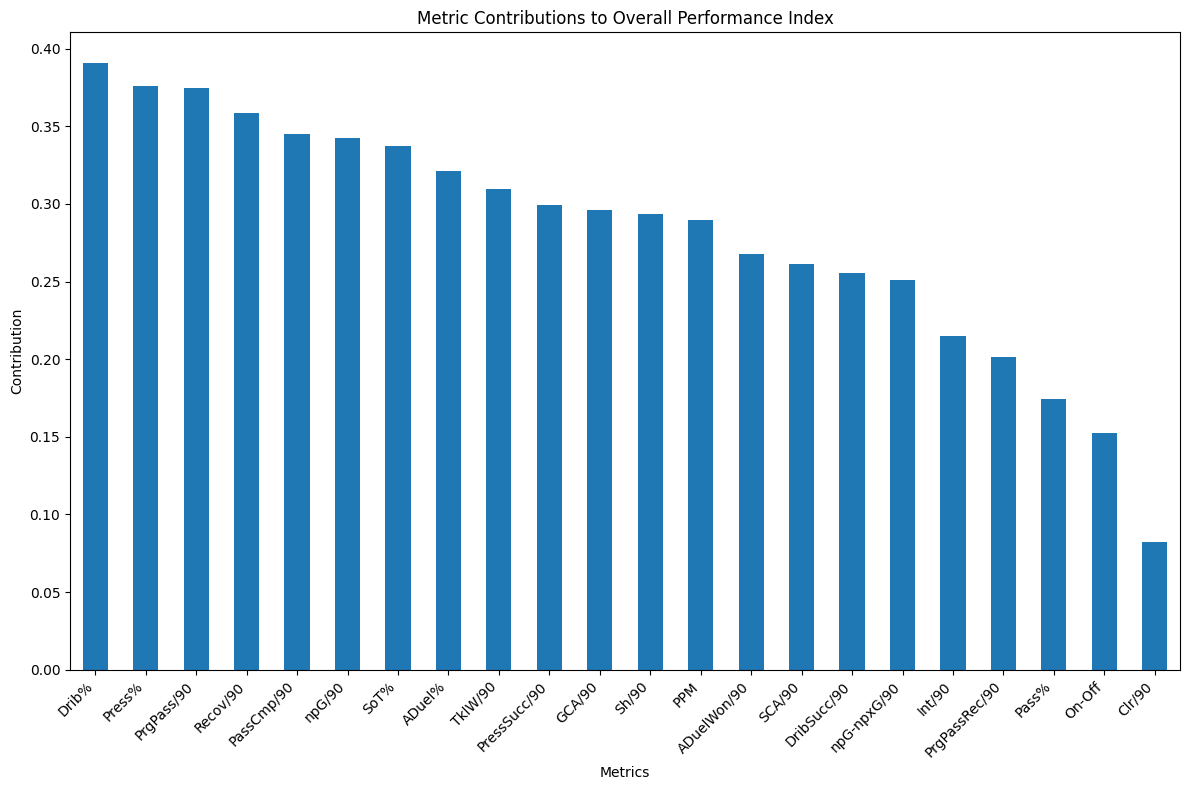

In [43]:
# Calculate the contribution of each metric to the Overall Performance Index
metric_contributions_wb = {}
for metric in outfield_model_metrics:
    # Get the factor loadings for this metric
    loadings = loading_df_wb.loc[metric]
    
    # Calculate the contribution to each index
    index_contributions_wb = {}
    for index_name, factors in indices_mapping_wb.items():
        contribution = sum(loadings[factor] * weights_wb[index_name] for factor in factors)
        index_contributions_wb[index_name] = contribution
    
    # Calculate the total contribution to the Overall Performance Index
    total_contribution = sum(index_contributions_wb.values())
    metric_contributions_wb[metric] = total_contribution

# Create a DataFrame of metric contributions
metric_contributions_df_wb = pd.DataFrame.from_dict(metric_contributions_wb, orient='index', columns=['Contribution'])
metric_contributions_df_wb = metric_contributions_df_wb.sort_values('Contribution', ascending=False)

print("\nMetric Contributions to Overall Performance Index:")
print(metric_contributions_df_wb)

# Visualize the contributions
plt.figure(figsize=(12, 8))
metric_contributions_df_wb['Contribution'].plot(kind='bar')
plt.title('Metric Contributions to Overall Performance Index')
plt.xlabel('Metrics')
plt.ylabel('Contribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [44]:
# Standardize the data
X_dm = position_df['Defensive Midfielder'][outfield_model_metrics]
X_cm = position_df['Central Midfielder'][outfield_model_metrics]
X_am = position_df['Attacking Midfielder'][outfield_model_metrics]

X_scaled_dm = scaler.fit_transform(X_dm)
X_scaled_dm = pd.DataFrame(X_scaled_dm, columns=X_dm.columns, index=X_dm.index)

X_scaled_cm = scaler.fit_transform(X_cm)
X_scaled_cm = pd.DataFrame(X_scaled_cm, columns=X_cm.columns, index=X_cm.index)

X_scaled_am = scaler.fit_transform(X_am)
X_scaled_am = pd.DataFrame(X_scaled_am, columns=X_am.columns, index=X_am.index)

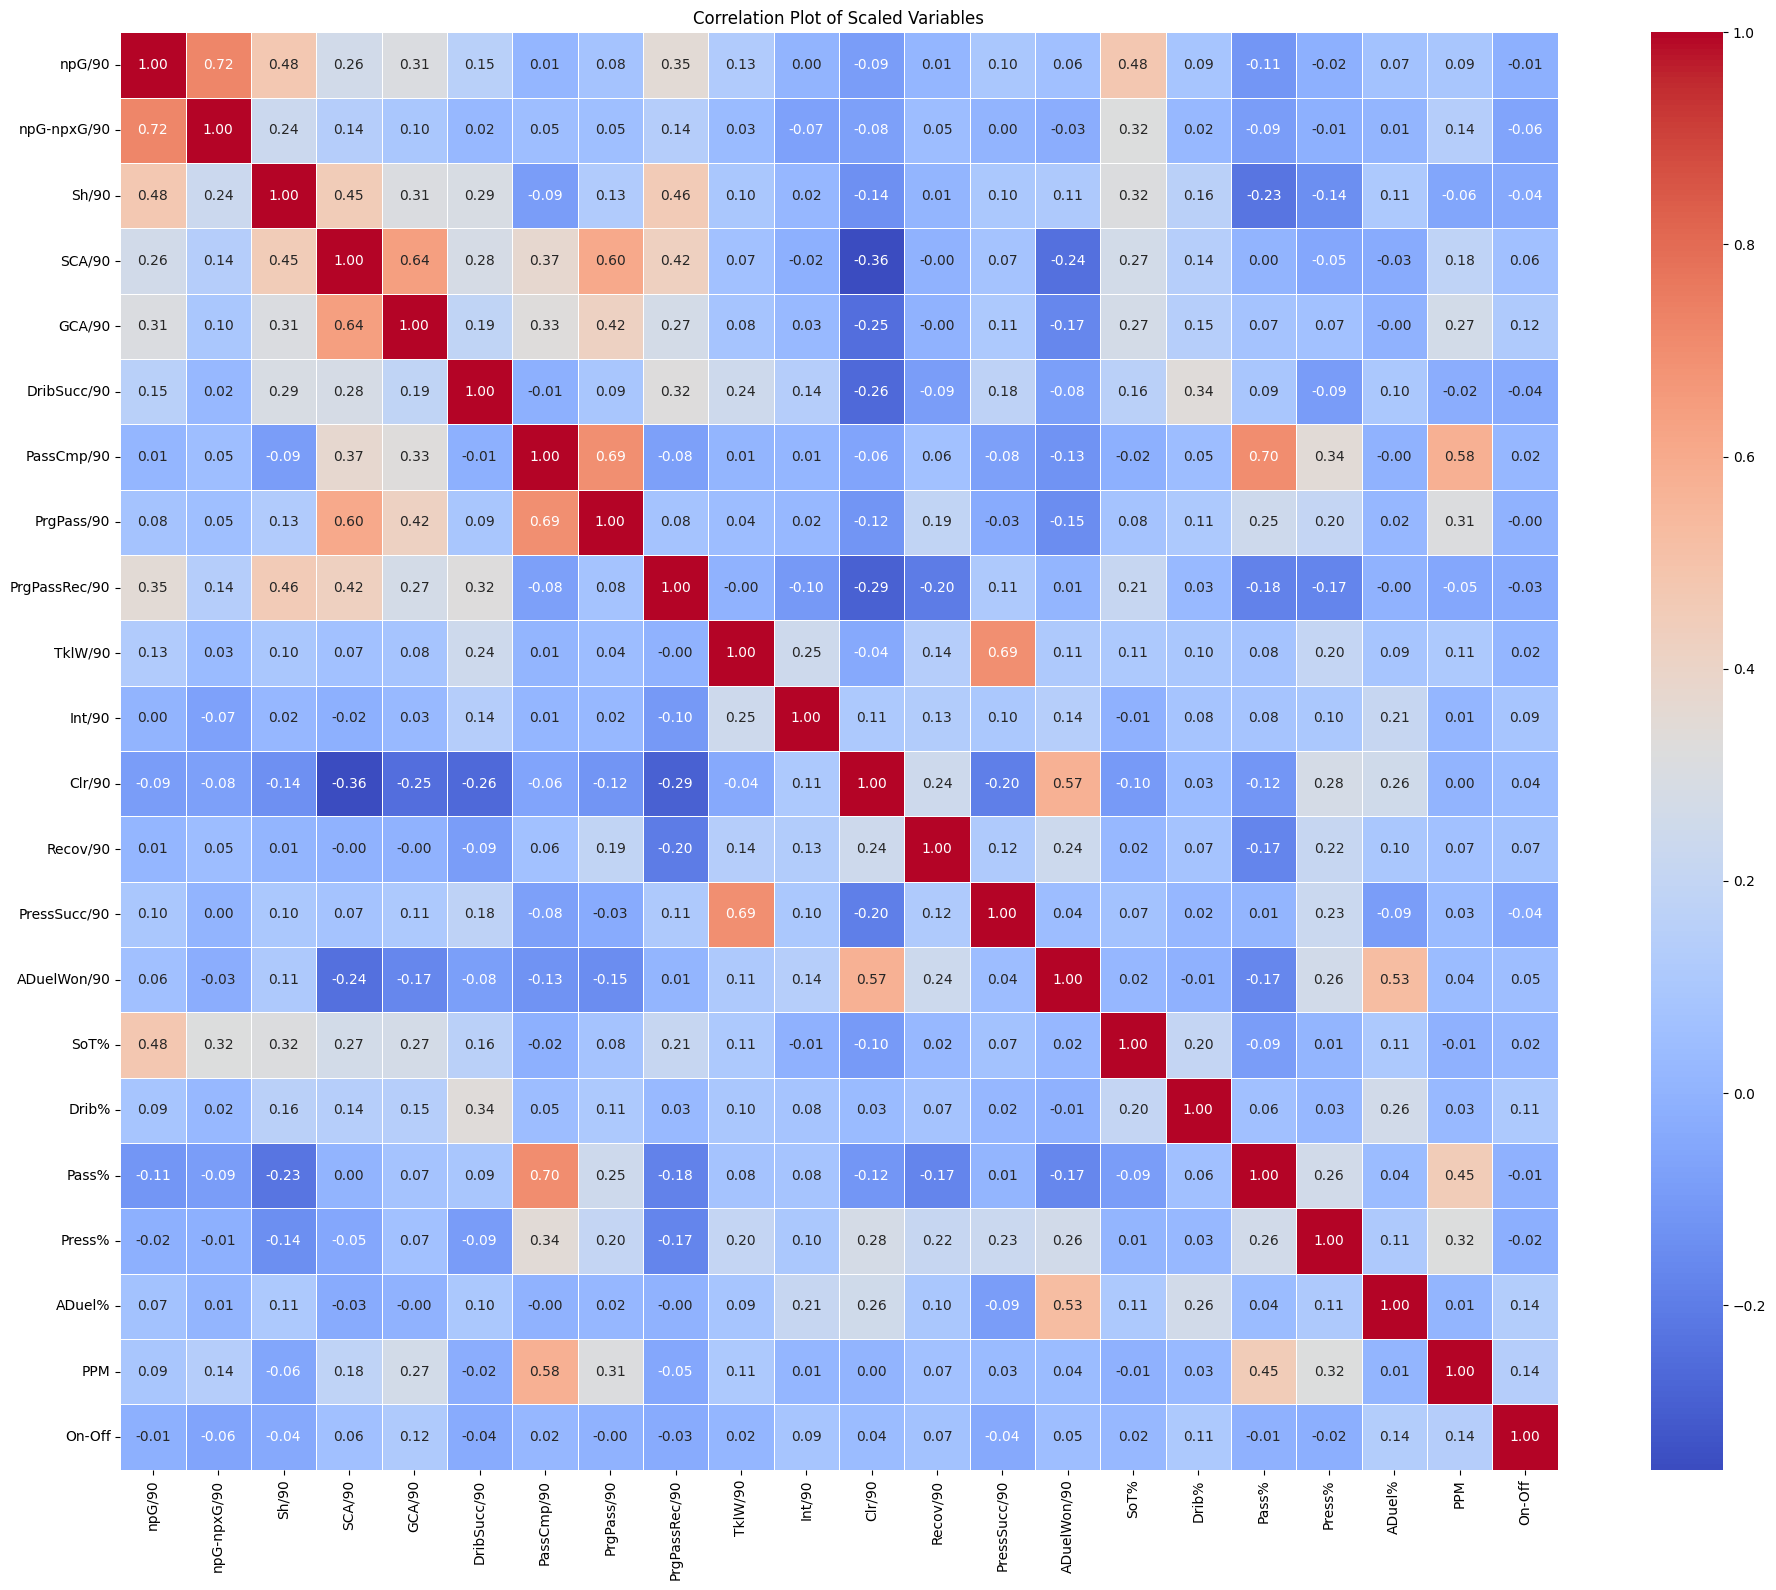

VIF       Variable
0   3.316725         npG/90
1   2.474472    npG-npxG/90
2   1.895408          Sh/90
3   3.421698         SCA/90
4   2.034941         GCA/90
5   1.553051    DribSucc/90
6   6.316295     PassCmp/90
7   3.286471     PrgPass/90
8   1.812004  PrgPassRec/90
9   2.295054        TklW/90
10  1.175510         Int/90
11  2.086707         Clr/90
12  1.386604       Recov/90
13  2.482671   PressSucc/90
14  2.650525    ADuelWon/90
15  1.415898           SoT%
16  1.325892          Drib%
17  3.623923          Pass%
18  1.576519         Press%
19  1.782947         ADuel%
20  1.770606            PPM
21  1.113807         On-Off

In [45]:
# Plot correlation matrix
plt.figure(figsize=(20, 16))
correlation_matrix_dm = X_scaled_dm.corr()
sns.heatmap(correlation_matrix_dm, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Correlation Plot of Scaled Variables')
plt.tight_layout()
plt.show()

# Variance Inflation Factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_scaled_dm.values, i) for i in range(X_scaled_dm.shape[1])]
vif['Variable'] = X_scaled_dm.columns
vif

KMO Model for Defensive Midfielders: 0.6630823153594935
Bartlett's Test Chi-square for Defensive Midfielders: 3409.392, p-value: 0.000
Eigenvalues for Defensive Midfielders: [3.78567521 2.87419167 2.47567766 1.81272547 1.53094519 1.26132583
 1.09194147 1.01340957 0.88713501 0.74116003 0.64230505 0.57446072
 0.53757911 0.50693858 0.4758377  0.44443919 0.3835316  0.25852322
 0.23421593 0.20294251 0.16790016 0.09713913]


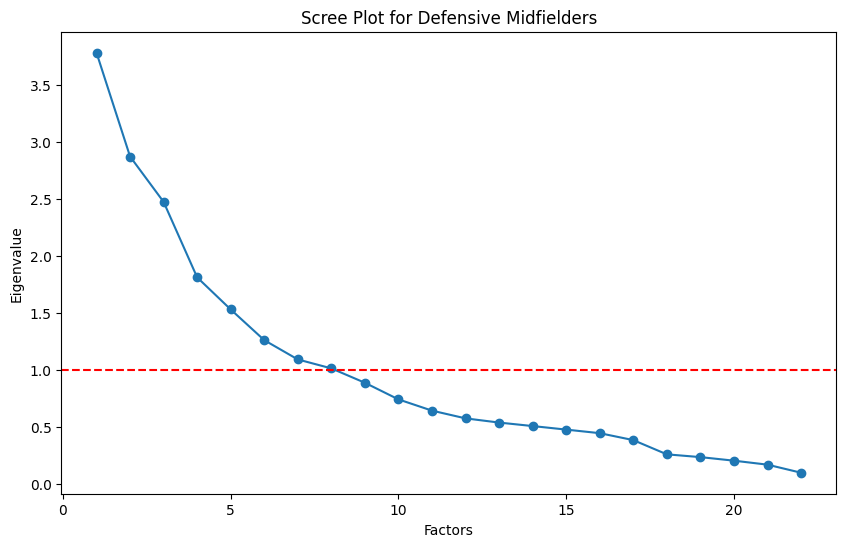

Number of factors: 8


In [46]:
# Step 1: KMO and Bartlett's Test
kmo_all_dm, kmo_model_dm = calculate_kmo(X_scaled_dm)
print(f"KMO Model for Defensive Midfielders: {kmo_model_dm}")

# Calculate Bartlett's Test
chi_square_value_dm, p_value_dm = calculate_bartlett_sphericity(X_scaled_dm)
print(f"Bartlett's Test Chi-square for Defensive Midfielders: {chi_square_value_dm:.3f}, p-value: {p_value_dm:.3f}")  # p < 0.05


# Step 2: Scree Plot
fa_dm = FactorAnalyzer(rotation='varimax', method='principal')
fa_dm.fit(X_scaled_dm)

ev_dm, v_dm = fa_dm.get_eigenvalues()
print(f"Eigenvalues for Defensive Midfielders: {ev_dm}")

plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(ev_dm)+1), ev_dm)
plt.plot(range(1, len(ev_dm)+1), ev_dm)
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Scree Plot for Defensive Midfielders')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

n_factors_dm = sum(ev_dm > 1)
print(f"Number of factors: {n_factors_dm}")

In [47]:
# Step 3: Factor Analysis with Varimax Rotation
fa_dm = FactorAnalyzer(n_factors=n_factors_dm, method='principal', rotation='varimax')
fa_dm.fit(X_scaled_dm)
loadings_dm = fa_dm.loadings_

# Step 4: Interpret Loadings
loading_df_dm = pd.DataFrame(loadings_dm, index=outfield_model_metrics, columns=[f'Factor{i+1}' for i in range(n_factors_dm)])
loading_df_dm

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
npG/90         0.254959 -0.003400  0.062753  0.081449  0.875731 -0.065526   
npG-npxG/90   -0.011497  0.070618 -0.051289 -0.030746  0.886252  0.027967   
Sh/90          0.637503 -0.234056  0.155103  0.067996  0.346871 -0.085117   
SCA/90         0.843495  0.196024 -0.227824 -0.013677  0.100343  0.101857   
GCA/90         0.670409  0.267581 -0.151610  0.056608  0.155346  0.080285   
DribSucc/90    0.317508 -0.041976 -0.089119  0.240230  0.033008 -0.287815   
PassCmp/90     0.213060  0.900917 -0.075786 -0.104413 -0.033742  0.121841   
PrgPass/90     0.544751  0.546845 -0.118465 -0.107877 -0.049114  0.385887   
PrgPassRec/90  0.672448 -0.193324  0.057300  0.068866  0.168004 -0.426157   
TklW/90        0.017446  0.070315  0.041300  0.864045  0.069193  0.063136   
Int/90        -0.069045  0.041667  0.186770  0.278014 -0.088245  0.114084   
Clr/90        -0.294450 -0.004020  0.688642 -0.145015 -0.047132  0.312682   
Recov/90       0.012539 -0.031832  0.177171  0.144066  0.039470  0.824043   
PressSucc/90   0.085009 -0.024056 -0.081051  0.909089  0.026329  0.024781   
ADuelWon/90   -0.021504 -0.074989  0.911528  0.110363  0.017890  0.053825   
SoT%           0.214884 -0.057544 -0.010487  0.039348  0.612886  0.047924   
Drib%          0.058191  0.024090  0.021694 -0.056157  0.123841  0.108344   
Pass%         -0.179428  0.814132 -0.108212  0.037938 -0.109250 -0.270986   
Press%        -0.088661  0.510740  0.355692  0.312374 -0.008048  0.255378   
ADuel%         0.043698  0.049629  0.686374 -0.065317  0.038219 -0.080664   
PPM            0.071826  0.745231  0.074108  0.084846  0.133355 -0.022192   
On-Off         0.040118  0.023059  0.053696 -0.013156 -0.030029  0.022445   

                Factor7   Factor8  
npG/90        -0.003959 -0.002628  
npG-npxG/90   -0.082002 -0.057393  
Sh/90          0.120937 -0.096850  
SCA/90         0.106935  0.043373  
GCA/90         0.067729  0.220523  
DribSucc/90    0.615289 -0.160047  
PassCmp/90     0.030575 -0.050697  
PrgPass/90     0.095908 -0.108448  
PrgPassRec/90 -0.075680 -0.081123  
TklW/90        0.170240  0.020077  
Int/90         0.401375  0.156222  
Clr/90        -0.059935 -0.011189  
Recov/90       0.043341  0.025395  
PressSucc/90  -0.031857 -0.038422  
ADuelWon/90   -0.058139  0.004363  
SoT%           0.237978  0.043472  
Drib%          0.789075  0.050637  
Pass%          0.190527 -0.047827  
Press%        -0.099879 -0.111560  
ADuel%         0.416908  0.122568  
PPM           -0.120492  0.215316  
On-Off         0.061046  0.940416

In [48]:
# Step 7: Get Factor Scores for Defensive Midfielders
factor_scores_dm = fa_dm.transform(X_scaled_dm)

# Create a DataFrame for factor scores
factor_columns_dm = [f'Factor{i+1}' for i in range(n_factors_dm)]
factor_df_dm = pd.DataFrame(factor_scores_dm, columns=factor_columns_dm, index=position_df['Defensive Midfielder'].index)

# Step 4: Define Indices

# Define the mapping of factors to indices
indices_mapping_dm = {
    'Passing_Ability': ['Factor2'],
    'Defensive_Performance': ['Factor3', 'Factor4', 'Factor6'],
    'Offensive_Contribution': ['Factor1', 'Factor5', 'Factor7'],
    'Team_Impact': ['Factor8']
}

# Initialize the indices DataFrame
indices_df_dm = pd.DataFrame(index=position_df['Defensive Midfielder'].index)

# Compute each index as the average of its factor scores
for index_name, factors in indices_mapping_dm.items():
    # Compute the average of the specified factors
    indices_df_dm[index_name] = factor_df_dm[factors].mean(axis=1)

# Assign the indices to the wing_back_data DataFrame
position_df['Defensive Midfielder'] = position_df['Defensive Midfielder'].join(indices_df_dm)

In [49]:
# Define weights for each index 
weights_dm = {
    'Offensive_Contribution': 0.25,
    'Passing_Ability': 0.35,
    'Defensive_Performance': 0.3,
    'Team_Impact': 0.1
}

# Compute the Overall Performance Index as a weighted sum of the indices
position_df['Defensive Midfielder']['Overall_Performance_Index'] = (
    position_df['Defensive Midfielder']['Offensive_Contribution'] * weights_dm['Offensive_Contribution'] + 
    position_df['Defensive Midfielder']['Passing_Ability'] * weights_dm['Passing_Ability'] +  
    position_df['Defensive Midfielder']['Defensive_Performance'] * weights_dm['Defensive_Performance'] + 
    position_df['Defensive Midfielder']['Team_Impact'] * weights_dm['Team_Impact']
)

In [50]:
position_df['Defensive Midfielder'][['Player','Offensive_Contribution', 'Passing_Ability', 'Defensive_Performance', 'Team_Impact', 'Overall_Performance_Index']].groupby('Player').mean().sort_values(by='Overall_Performance_Index', ascending=False).head(10)

Offensive_Contribution  Passing_Ability  \
Player                                                        
Fernandinho                       0.188130         2.077766   
Rodri                             0.443617         1.419841   
Joshua Kimmich                    0.956412         1.727209   
Sergio Busquets                   0.067918         1.881605   
Idrissa Gana Gueye                0.249110         1.061806   
Casemiro                          0.452687         0.731819   
Lucas Leiva                      -0.043654         0.893682   
Emre Can                          0.603202         1.020904   
Jorginho                         -0.039762         1.743344   
Sven Bender                      -0.423128         1.337571   

                    Defensive_Performance  Team_Impact  \
Player                                                   
Fernandinho                      0.422133    -0.480133   
Rodri                            0.439800    -0.035338   
Joshua Kimmich                  -0.542410     0.155888   
Sergio Busquets                 -0.250394     0.603257   
Idrissa Gana Gueye               0.586719     0.213698   
Casemiro                         0.658982     0.613894   
Lucas Leiva                      0.951436     0.006188   
Emre Can                         0.212605    -0.253493   
Jorginho                        -0.086009    -0.299720   
Sven Bender                      0.570163    -0.096769   

                    Overall_Performance_Index  
Player                                         
Fernandinho                          0.852877  
Rodri                                0.736255  
Joshua Kimmich                       0.696492  
Sergio Busquets                      0.660749  
Idrissa Gana Gueye                   0.631295  
Casemiro                             0.628393  
Lucas Leiva                          0.587925  
Emre Can                             0.546549  
Jorginho                             0.544455  
Sven Bender                          0.523740


Metric Contributions to Overall Performance Index:
               Contribution
Press%             0.395489
TklW/90            0.381382
PrgPass/90         0.376301
Recov/90           0.358819
PassCmp/90         0.345217
PPM                0.344564
GCA/90             0.334662
ADuel%             0.316451
npG/90             0.303833
SCA/90             0.293746
ADuelWon/90        0.281467
Drib%              0.278436
SoT%               0.273680
Int/90             0.264887
PressSucc/90       0.263454
Sh/90              0.226118
npG-npxG/90        0.200945
DribSucc/90        0.169744
Clr/90             0.153987
Pass%              0.153247
On-Off             0.138791
PrgPassRec/90      0.025420


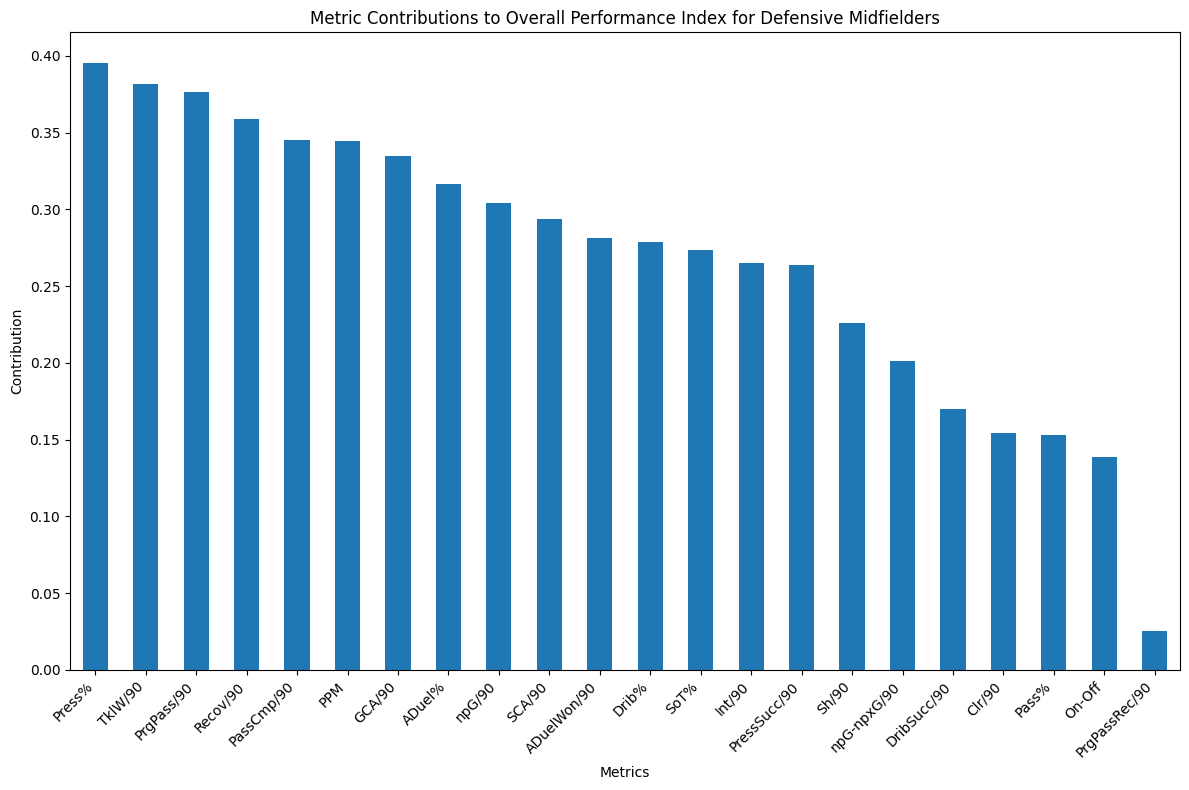

In [51]:
# Calculate the contribution of each metric to the Overall Performance Index
metric_contributions_dm = {}
for metric in outfield_model_metrics:
    # Get the factor loadings for this metric
    loadings = loading_df_dm.loc[metric]
    
    # Calculate the contribution to each index
    index_contributions_dm = {}
    for index_name, factors in indices_mapping_dm.items():
        contribution = sum(loadings[factor] * weights_dm[index_name] for factor in factors)
        index_contributions_dm[index_name] = contribution
    
    # Calculate the total contribution to the Overall Performance Index
    total_contribution = sum(index_contributions_dm.values())
    metric_contributions_dm[metric] = total_contribution

# Create a DataFrame of metric contributions
metric_contributions_df_dm = pd.DataFrame.from_dict(metric_contributions_dm, orient='index', columns=['Contribution'])
metric_contributions_df_dm = metric_contributions_df_dm.sort_values('Contribution', ascending=False)

print("\nMetric Contributions to Overall Performance Index:")
print(metric_contributions_df_dm)

# Visualize the contributions
plt.figure(figsize=(12, 8))
metric_contributions_df_dm['Contribution'].plot(kind='bar')
plt.title('Metric Contributions to Overall Performance Index for Defensive Midfielders')
plt.xlabel('Metrics')
plt.ylabel('Contribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

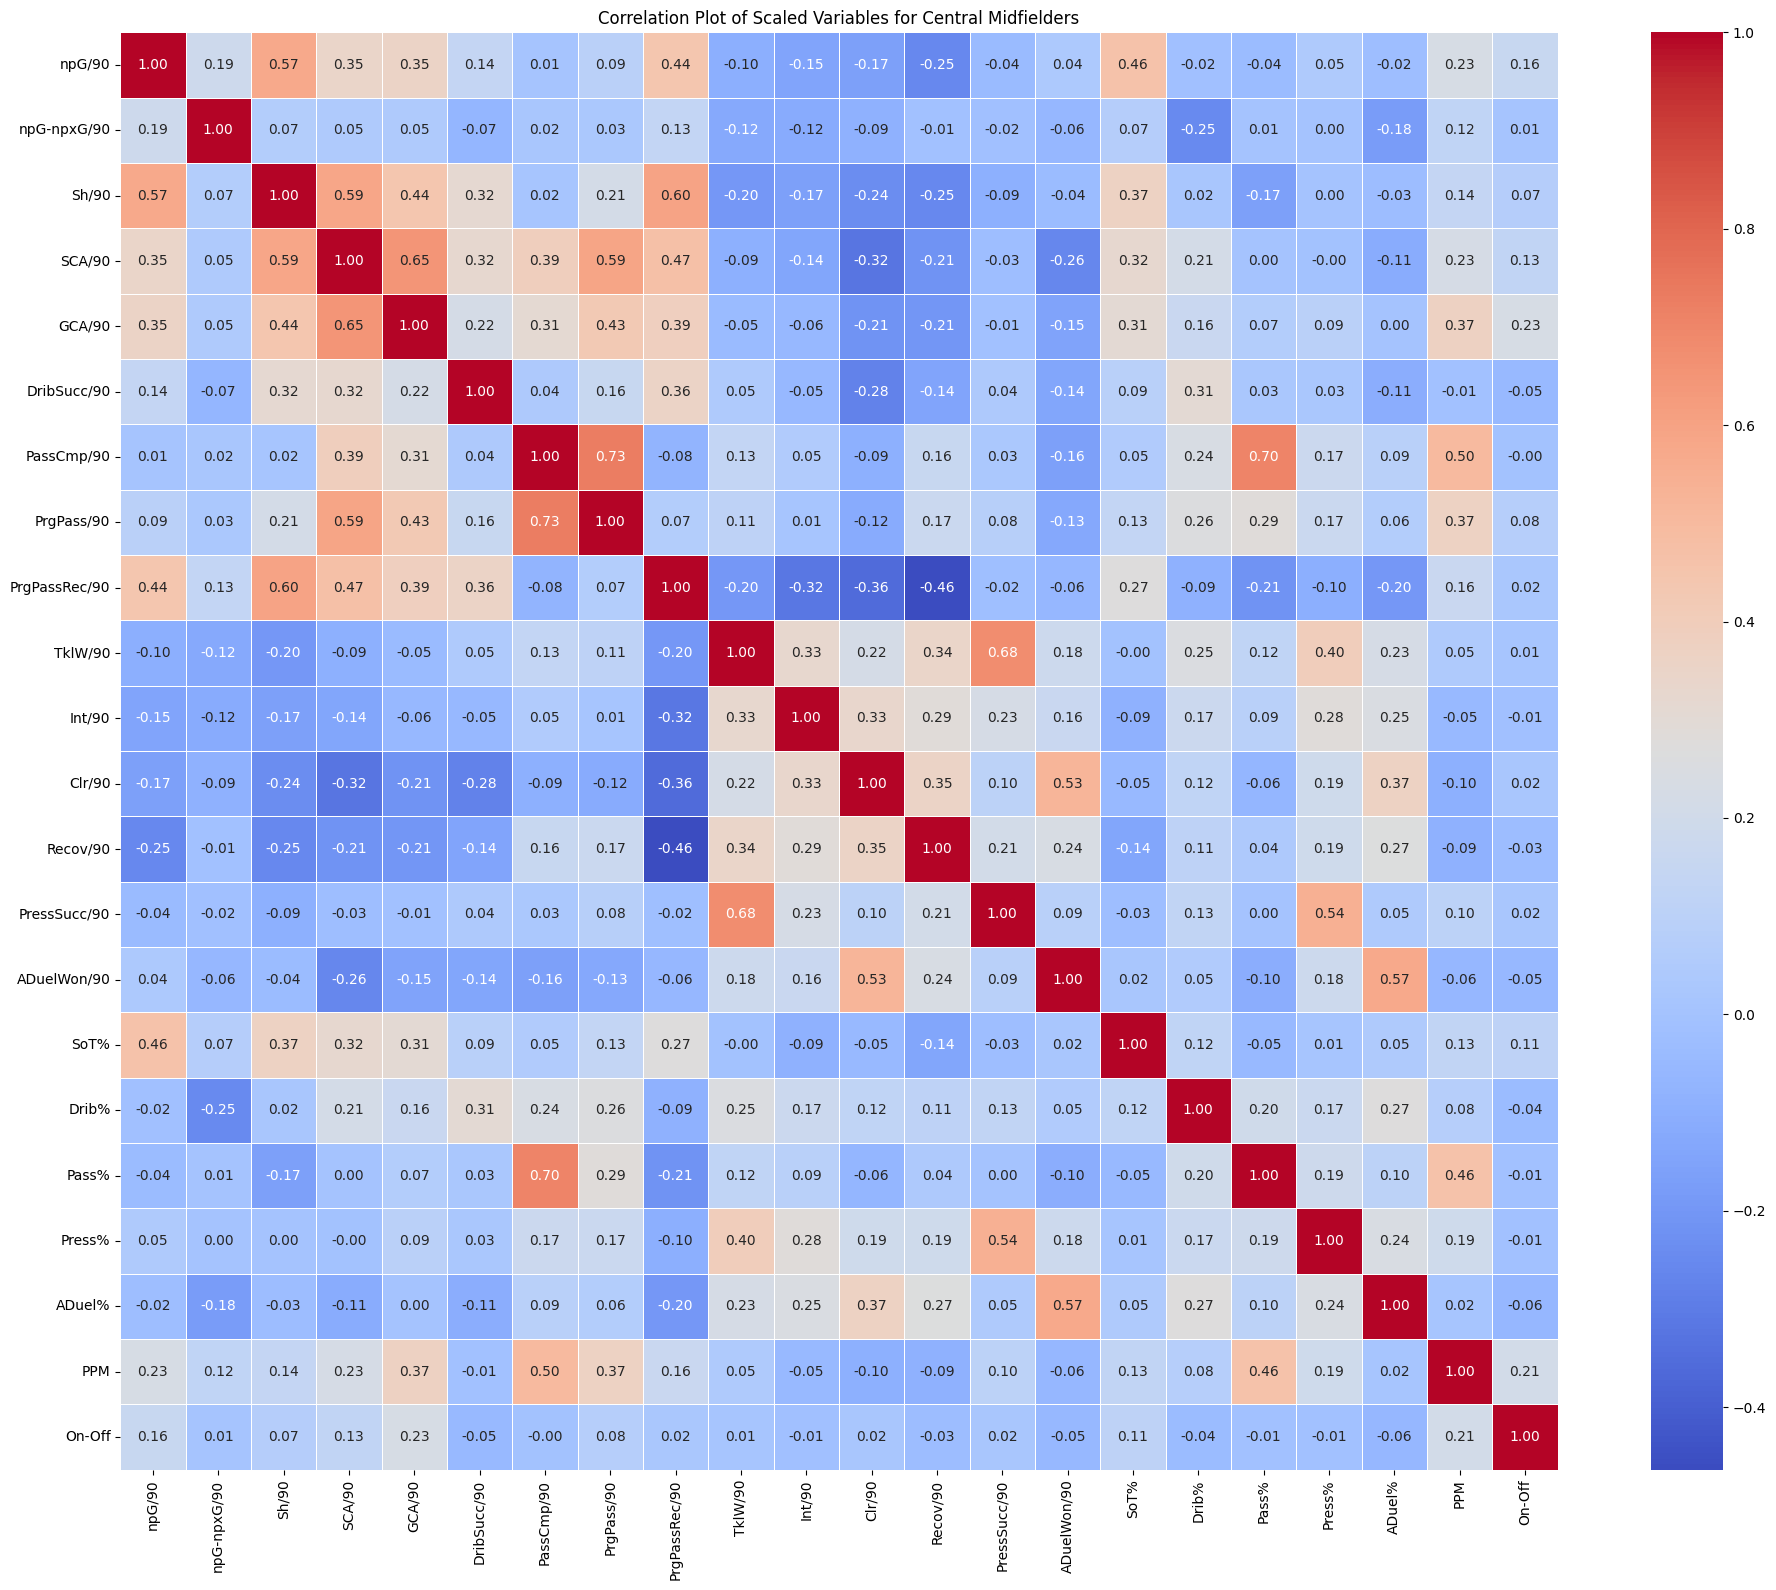

         VIF       Variable
0   3.316725         npG/90
1   2.474472    npG-npxG/90
2   1.895408          Sh/90
3   3.421698         SCA/90
4   2.034941         GCA/90
5   1.553051    DribSucc/90
6   6.316295     PassCmp/90
7   3.286471     PrgPass/90
8   1.812004  PrgPassRec/90
9   2.295054        TklW/90
10  1.175510         Int/90
11  2.086707         Clr/90
12  1.386604       Recov/90
13  2.482671   PressSucc/90
14  2.650525    ADuelWon/90
15  1.415898           SoT%
16  1.325892          Drib%
17  3.623923          Pass%
18  1.576519         Press%
19  1.782947         ADuel%
20  1.770606            PPM
21  1.113807         On-Off
KMO Model for Creative Midfielders: 0.738224747727835
Bartlett's Test Chi-square for Creative Midfielders: 5983.650, p-value: 0.000
Eigenvalues for Central Midfielders: [4.38527476 3.40860769 2.15586091 1.58858369 1.47863856 1.09999073
 1.03983143 0.8446751  0.78113198 0.75080701 0.62217154 0.57182655
 0.54218453 0.47221063 0.45000771 0.39297339 0.338598

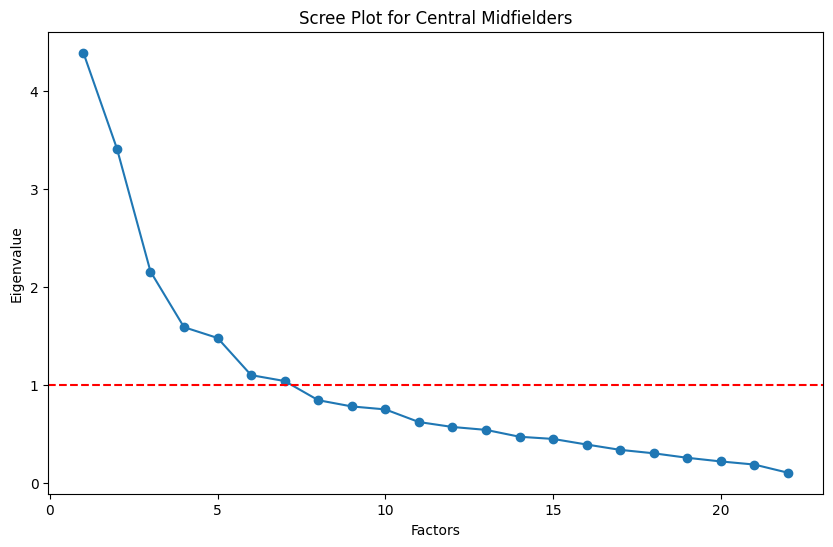

Number of factors: 7


In [52]:
# Overall Performance Index for Central Midfielders
# Plot correlation matrix
plt.figure(figsize=(20, 16))
correlation_matrix_cm = X_scaled_cm.corr()
sns.heatmap(correlation_matrix_cm, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Correlation Plot of Scaled Variables for Central Midfielders')
plt.tight_layout()
plt.show()

# Variance Inflation Factor
vif_cm = pd.DataFrame()
vif_cm['VIF'] = [variance_inflation_factor(X_scaled_cm.values, i) for i in range(X_scaled_cm.shape[1])]
vif_cm['Variable'] = X_scaled_cm.columns
print(vif)

# Step 1: KMO and Bartlett's Test
kmo_all_cm, kmo_model_cm = calculate_kmo(X_scaled_cm)
print(f"KMO Model for Creative Midfielders: {kmo_model_cm}")

# Calculate Bartlett's Test
chi_square_value_cm, p_value_cm = calculate_bartlett_sphericity(X_scaled_cm)
print(f"Bartlett's Test Chi-square for Creative Midfielders: {chi_square_value_cm:.3f}, p-value: {p_value_cm:.3f}")  # p < 0.05

# Factor Analysis with Varimax Rotation for Central Midfielders
fa_cm = FactorAnalyzer(rotation='varimax', method='principal')
fa_cm.fit(X_scaled_cm)

ev_cm, v_cm = fa_cm.get_eigenvalues()
print(f"Eigenvalues for Central Midfielders: {ev_cm}")

plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(ev_cm)+1), ev_cm)
plt.plot(range(1, len(ev_cm)+1), ev_cm)
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Scree Plot for Central Midfielders')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

n_factors_cm = sum(ev_cm > 1)
print(f"Number of factors: {n_factors_cm}")

In [53]:
# Factor Analysis with Varimax Rotation for Central Midfielders
fa_cm = FactorAnalyzer(n_factors=n_factors_cm, method='principal', rotation='varimax')
fa_cm.fit(X_scaled_cm)
loadings_cm = fa_cm.loadings_

# Create a DataFrame for better readability
loading_df_cm = pd.DataFrame(loadings_cm, index=outfield_model_metrics, columns=[f'Factor{i+1}' for i in range(n_factors_cm)])
print("Factor Loadings for Central Midfielders:")
loading_df_cm

Factor Loadings for Central Midfielders:


Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
npG/90         0.763774  0.099226  0.062511 -0.004218 -0.161229  0.085016   
npG-npxG/90    0.155136  0.048172 -0.090361  0.030389 -0.765743 -0.140290   
Sh/90          0.812906 -0.102300 -0.058797 -0.088217  0.020380 -0.071127   
SCA/90         0.623591  0.063162 -0.276619 -0.054529  0.152438  0.038268   
GCA/90         0.601942  0.199028 -0.132993  0.006972  0.129075  0.249891   
DribSucc/90    0.353427 -0.072158 -0.325180  0.133157  0.476643 -0.334940   
PassCmp/90    -0.011474  0.732405 -0.045105  0.038856  0.056666 -0.051890   
PrgPass/90     0.196919  0.349618 -0.065881  0.077032  0.063582  0.003097   
PrgPassRec/90  0.765254 -0.068085 -0.284471 -0.046891 -0.032794 -0.161132   
TklW/90       -0.141149  0.021856  0.138841  0.801430  0.161501  0.036711   
Int/90        -0.243560 -0.056441  0.314276  0.375443  0.177001  0.121614   
Clr/90        -0.235237 -0.121588  0.718660  0.140724 -0.008676  0.160817   
Recov/90      -0.417938 -0.142719  0.394944  0.272782 -0.122841 -0.010302   
PressSucc/90  -0.011147 -0.018612 -0.052674  0.914017 -0.018407  0.014068   
ADuelWon/90    0.088645 -0.072633  0.821754  0.106257 -0.024797 -0.114721   
SoT%           0.593443  0.011711  0.145511 -0.018689  0.013381  0.159694   
Drib%          0.067084  0.139327  0.164238  0.171691  0.681822 -0.096118   
Pass%         -0.184879  0.873327 -0.012025  0.043091  0.103449 -0.082071   
Press%         0.077218  0.230931  0.201881  0.713232 -0.019690 -0.065268   
ADuel%         0.035187  0.133450  0.781300  0.071430  0.236708 -0.103632   
PPM            0.267797  0.752022 -0.037648  0.120850 -0.111052  0.216556   
On-Off         0.145288  0.035655 -0.059663  0.031146  0.014363  0.878240   

                Factor7  
npG/90        -0.088657  
npG-npxG/90    0.126584  
Sh/90          0.152402  
SCA/90         0.569968  
GCA/90         0.368855  
DribSucc/90    0.088516  
PassCmp/90     0.586211  
PrgPass/90     0.796591  
PrgPassRec/90 -0.130405  
TklW/90        0.085843  
Int/90         0.163074  
Clr/90         0.007807  
Recov/90       0.497496  
PressSucc/90  -0.020483  
ADuelWon/90   -0.173550  
SoT%           0.070810  
Drib%          0.256680  
Pass%          0.089058  
Press%         0.020067  
ADuel%         0.045305  
PPM            0.049397  
On-Off         0.011517

In [54]:
# Get Factor Scores for Central Midfielders
factor_scores_cm = fa_cm.transform(X_scaled_cm)

# Create a DataFrame for factor scores
factor_columns_cm = [f'Factor{i+1}' for i in range(7)]
factor_df_cm = pd.DataFrame(factor_scores_cm, columns=factor_columns_cm, index=position_df['Central Midfielder'].index)

# Define Indices
indices_mapping_cm = {
    'Passing_Ability': ['Factor2', 'Factor7'],
    'Defensive_Performance': ['Factor3', 'Factor4'],
    'Offensive_Contribution': ['Factor1'],
    'Team_Impact': ['Factor6']
}

# Initialize the indices DataFrame
indices_df_cm = pd.DataFrame(index=position_df['Central Midfielder'].index)

# Compute each index as the average of its factor scores
for index_name, factors in indices_mapping_cm.items():
    # Compute the average of the specified factors
    indices_df_cm[index_name] = factor_df_cm[factors].mean(axis=1)

# Assign the indices to the creative_midfielder_data DataFrame
position_df['Central Midfielder'] = position_df['Central Midfielder'].join(indices_df_cm)

# Define weights for each index 
weights_cm = {
    'Offensive_Contribution': 0.3,
    'Passing_Ability': 0.35,
    'Defensive_Performance': 0.25,
    'Team_Impact': 0.1
}

# Compute the Overall Performance Index as a weighted sum of the indices
position_df['Central Midfielder']['Overall_Performance_Index'] = (
    position_df['Central Midfielder']['Offensive_Contribution'] * weights_cm['Offensive_Contribution'] + 
    position_df['Central Midfielder']['Passing_Ability'] * weights_cm['Passing_Ability'] +  
    position_df['Central Midfielder']['Defensive_Performance'] * weights_cm['Defensive_Performance'] + 
    position_df['Central Midfielder']['Team_Impact'] * weights_cm['Team_Impact']
)

In [55]:
position_df['Central Midfielder'][['Player','Offensive_Contribution', 'Passing_Ability', 'Defensive_Performance', 'Team_Impact', 'Overall_Performance_Index']].groupby('Player').mean().sort_values(by='Overall_Performance_Index', ascending=False).head(10)

Offensive_Contribution  Passing_Ability  \
Player                                                             
Paul Pogba                             1.712408         0.834827   
Arturo Vidal                           1.282760         0.437570   
Sergej Milinković-Savić                2.570856        -0.238133   
Luis Alberto                           2.234216         0.609062   
Corentin Tolisso                       1.359825         1.389493   
Leon Goretzka                          1.478977         0.217927   
Thiago Alcántara                       0.018239         1.686416   
Aaron Ramsey                           2.148009         0.027032   
İlkay Gündoğan                         1.022251         1.300686   
Marcel Sabitzer                        1.694666        -0.122977   

                         Defensive_Performance  Team_Impact  \
Player                                                        
Paul Pogba                            0.395827    -0.168062   
Arturo Vidal                          1.216922     0.314190   
Sergej Milinković-Savić               0.810532    -0.721422   
Luis Alberto                         -0.603204     0.285904   
Corentin Tolisso                     -0.108187    -1.325242   
Leon Goretzka                         0.629120     0.455368   
Thiago Alcántara                      0.618478    -0.370860   
Aaron Ramsey                         -0.113945     0.612391   
İlkay Gündoğan                       -0.355615    -0.435818   
Marcel Sabitzer                       0.180431     0.575623   

                         Overall_Performance_Index  
Player                                              
Paul Pogba                                0.888062  
Arturo Vidal                              0.873627  
Sergej Milinković-Savić                   0.818401  
Luis Alberto                              0.761226  
Corentin Tolisso                          0.734699  
Leon Goretzka                             0.722784  
Thiago Alcántara                          0.713251  
Aaron Ramsey                              0.686617  
İlkay Gündoğan                            0.629430  
Marcel Sabitzer                           0.568028


Metric Contributions to Overall Performance Index:
               Contribution
PrgPass/90         0.463347
PassCmp/90         0.451322
PPM                0.403292
GCA/90             0.372826
Press%             0.333266
SCA/90             0.329713
Pass%              0.280931
ADuel%             0.275940
npG/90             0.255906
SoT%               0.254590
TklW/90            0.234089
Drib%              0.233098
Sh/90              0.217541
PressSucc/90       0.199715
Recov/90           0.164692
ADuelWon/90        0.160960
Int/90             0.148845
On-Off             0.140792
Clr/90             0.120533
npG-npxG/90        0.078683
PrgPassRec/90      0.061151
DribSucc/90        0.030254


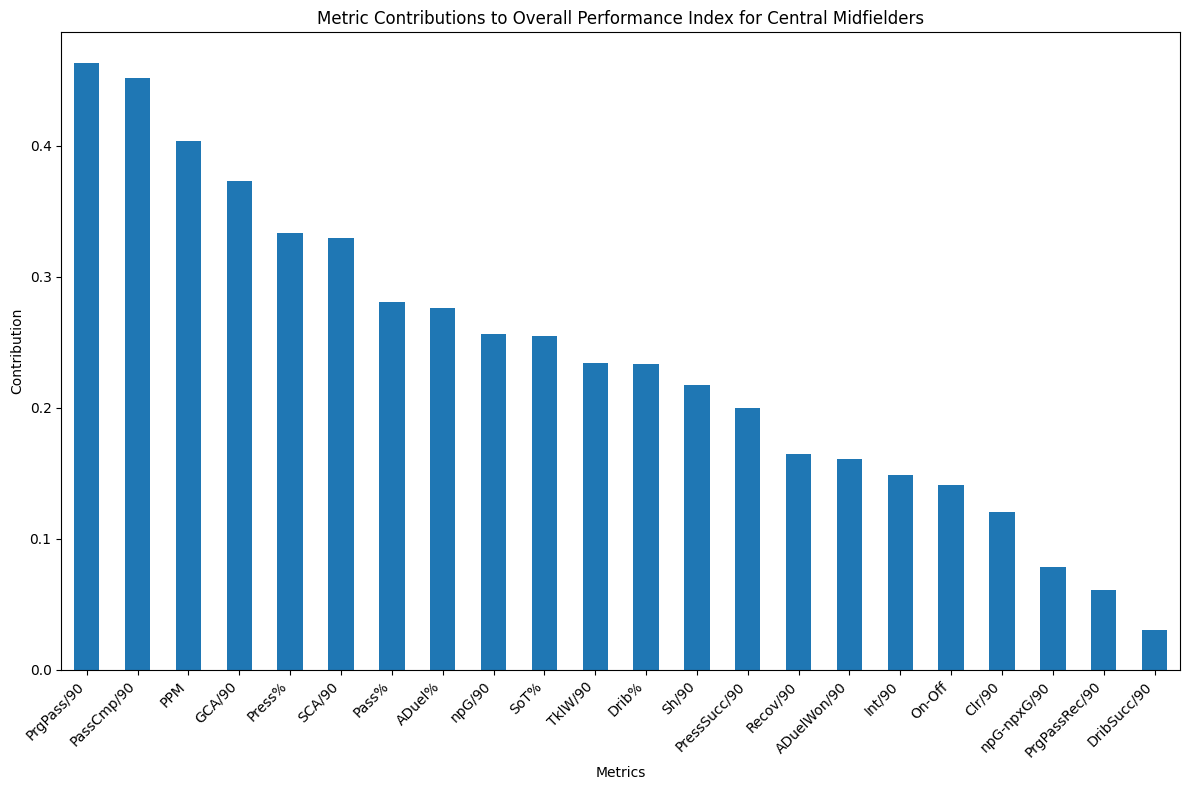

In [56]:
# Calculate the contribution of each metric to the Overall Performance Index
metric_contributions_cm = {}
for metric in outfield_model_metrics:
    # Get the factor loadings for this metric
    loadings = loading_df_cm.loc[metric]

    # Calculate the contribution to each index
    index_contributions_cm = {}
    for index_name, factors in indices_mapping_cm.items():
        contribution = sum(loadings[factor] * weights_cm[index_name] for factor in factors)
        index_contributions_cm[index_name] = contribution
    
    # Calculate the total contribution to the Overall Performance Index
    total_contribution = sum(index_contributions_cm.values())
    metric_contributions_cm[metric] = total_contribution

# Create a DataFrame of metric contributions
metric_contributions_df_cm = pd.DataFrame.from_dict(metric_contributions_cm, orient='index', columns=['Contribution'])
metric_contributions_df_cm = metric_contributions_df_cm.sort_values('Contribution', ascending=False)

print("\nMetric Contributions to Overall Performance Index:")
print(metric_contributions_df_cm)

# Visualize the contributions
plt.figure(figsize=(12, 8))
metric_contributions_df_cm['Contribution'].plot(kind='bar')
plt.title('Metric Contributions to Overall Performance Index for Central Midfielders')
plt.xlabel('Metrics')
plt.ylabel('Contribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

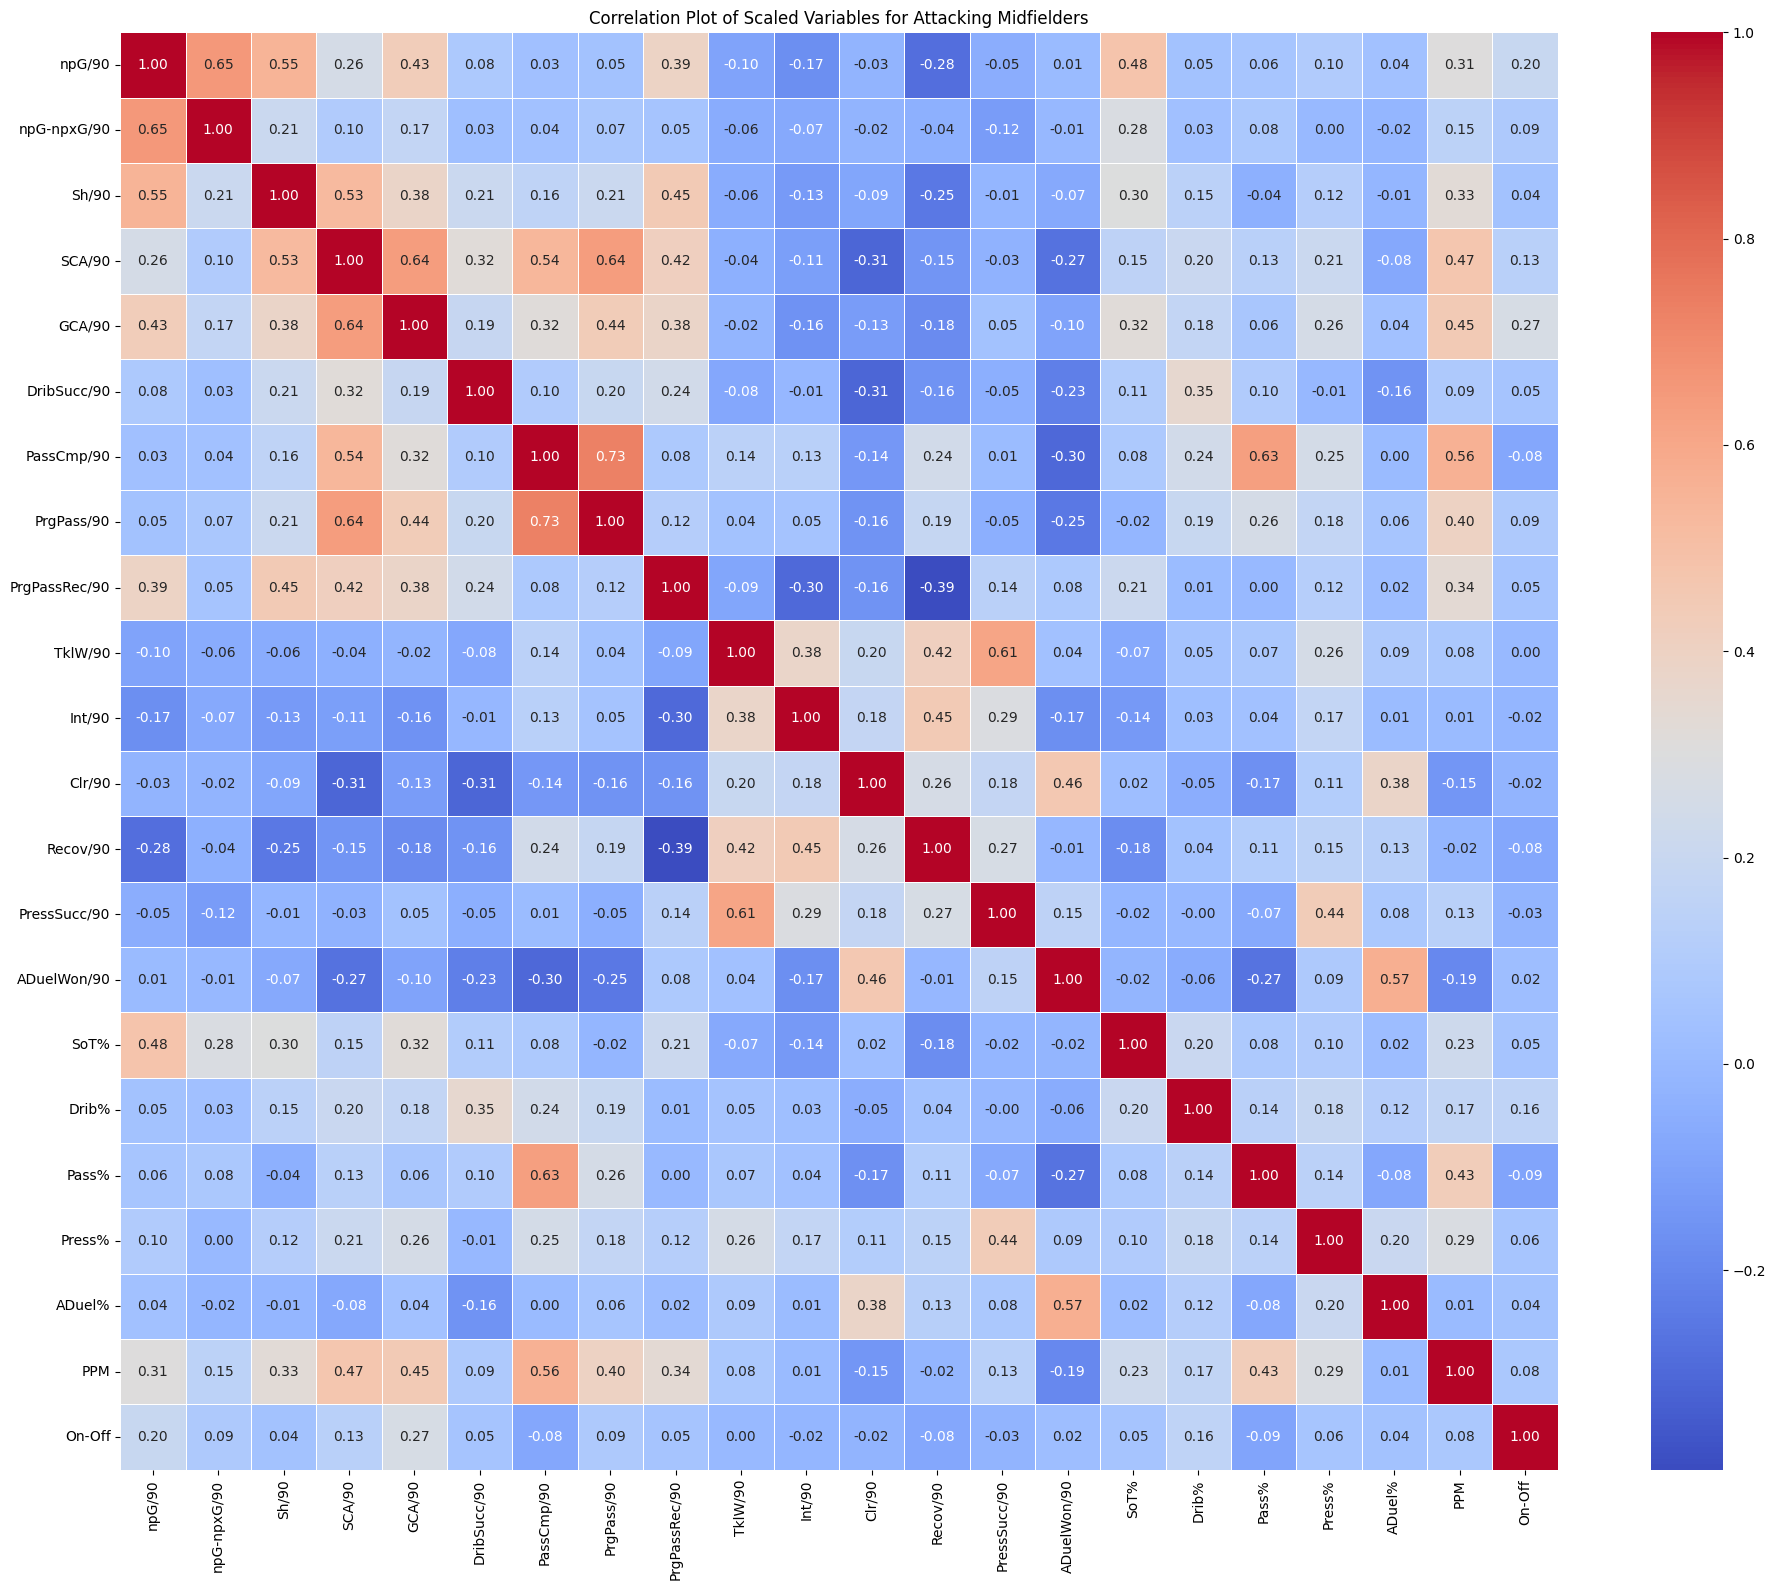

         VIF       Variable
0   3.820924         npG/90
1   2.146341    npG-npxG/90
2   2.217475          Sh/90
3   3.762850         SCA/90
4   2.379236         GCA/90
5   1.518498    DribSucc/90
6   5.538887     PassCmp/90
7   3.464638     PrgPass/90
8   1.977903  PrgPassRec/90
9   1.913738        TklW/90
10  1.593700         Int/90
11  1.636863         Clr/90
12  1.884953       Recov/90
13  2.289645   PressSucc/90
14  2.242352    ADuelWon/90
15  1.484493           SoT%
16  1.397531          Drib%
17  2.472356          Pass%
18  1.516734         Press%
19  1.794097         ADuel%
20  2.044277            PPM
21  1.250797         On-Off
KMO Model for Attacking Midfielders: 0.7130243408131919
Bartlett's Test Chi-square for Attacking Midfielders: 2907.970, p-value: 0.000
Eigenvalues for Attacking Midfielders: [4.54290307 2.96178769 2.43145167 1.49307993 1.44063476 1.26694435
 1.10622506 0.94427784 0.76207904 0.66931832 0.65504338 0.57208447
 0.50111986 0.44550502 0.43035014 0.38116959 0.3

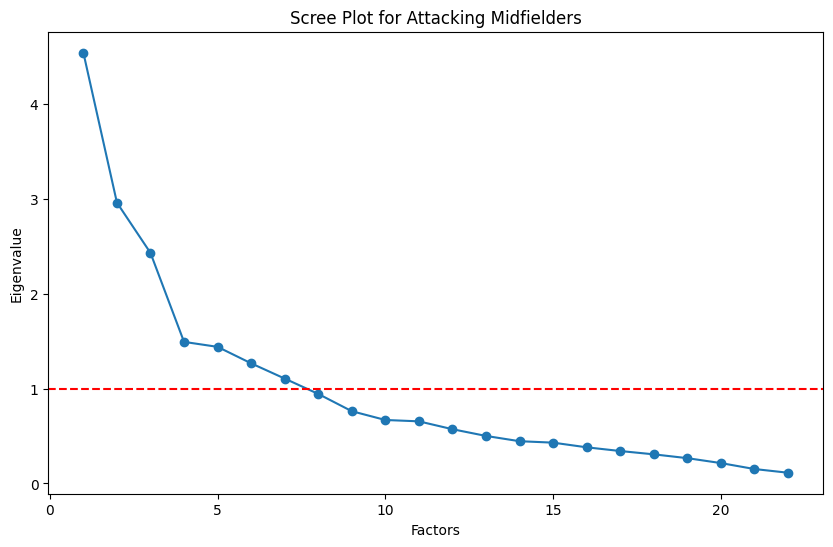

Number of factors: 7


In [57]:
# Overall Performance Index for Attacking Midfielders
# Plot correlation matrix
plt.figure(figsize=(20, 16))
correlation_matrix_am = X_scaled_am.corr()
sns.heatmap(correlation_matrix_am, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Correlation Plot of Scaled Variables for Attacking Midfielders')
plt.tight_layout()
plt.show()

# Variance Inflation Factor
vif_am = pd.DataFrame()
vif_am['VIF'] = [variance_inflation_factor(X_scaled_am.values, i) for i in range(X_scaled_am.shape[1])]
vif_am['Variable'] = X_scaled_am.columns
print(vif_am)

# Step 1: KMO and Bartlett's Test
kmo_all_am, kmo_model_am = calculate_kmo(X_scaled_am)
print(f"KMO Model for Attacking Midfielders: {kmo_model_am}")

# Calculate Bartlett's Test
chi_square_value_am, p_value_am = calculate_bartlett_sphericity(X_scaled_am)
print(f"Bartlett's Test Chi-square for Attacking Midfielders: {chi_square_value_am:.3f}, p-value: {p_value_am:.3f}")  # p < 0.05

# Factor Analysis with Varimax Rotation for Central Midfielders
fa_am = FactorAnalyzer(rotation='varimax', method='principal')
fa_am.fit(X_scaled_am)

ev_am, v_am = fa_am.get_eigenvalues()
print(f"Eigenvalues for Attacking Midfielders: {ev_am}")

plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(ev_am)+1), ev_am)
plt.plot(range(1, len(ev_am)+1), ev_am)
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Scree Plot for Attacking Midfielders')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

n_factors_am = sum(ev_am > 1)
print(f"Number of factors: {n_factors_am}")

In [58]:
# Factor Analysis with Varimax Rotation for Attacking Midfielders
fa_am = FactorAnalyzer(n_factors=n_factors_am, method='principal', rotation='varimax')
fa_am.fit(X_scaled_am)
loadings_am = fa_am.loadings_

# Create a DataFrame for better readability
loading_df_am = pd.DataFrame(loadings_am, index=outfield_model_metrics, columns=[f'Factor{i+1}' for i in range(n_factors_am)])
print("Factor Loadings for Attacking Midfielders:")
loading_df_am

Factor Loadings for Attacking Midfielders:


Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
npG/90         0.113315 -0.013047  0.012660  0.856012  0.312968 -0.036310   
npG-npxG/90    0.059743 -0.112913 -0.031720  0.818225 -0.114500 -0.082626   
Sh/90          0.275678  0.079985 -0.071725  0.400441  0.506006  0.072048   
SCA/90         0.743168  0.018469 -0.195890  0.062996  0.392366  0.127865   
GCA/90         0.573515  0.067687  0.009939  0.278380  0.390170  0.091461   
DribSucc/90    0.079854 -0.008254 -0.329884 -0.021710  0.224377  0.694757   
PassCmp/90     0.859925  0.083416 -0.069729  0.026812 -0.142033  0.105977   
PrgPass/90     0.876640 -0.028693 -0.044585 -0.069807 -0.069129  0.072690   
PrgPassRec/90  0.183238  0.119025  0.004668  0.127184  0.804412  0.030644   
TklW/90        0.039526  0.780778  0.032607 -0.028619 -0.223605 -0.027530   
Int/90         0.024568  0.517293 -0.140836 -0.025893 -0.541297  0.031475   
Clr/90        -0.164981  0.219085  0.643473  0.088025 -0.241755 -0.160540   
Recov/90       0.177933  0.385430  0.124069 -0.108936 -0.674352 -0.060564   
PressSucc/90  -0.063526  0.885761  0.080257 -0.079850  0.114222 -0.037357   
ADuelWon/90   -0.257937  0.033063  0.819078 -0.039069  0.163352 -0.080273   
SoT%          -0.003840  0.017034  0.063911  0.645612  0.213820  0.282295   
Drib%          0.172046  0.034474  0.117711  0.088909 -0.087665  0.851638   
Pass%          0.456759 -0.026366 -0.128155  0.152331 -0.187072  0.148839   
Press%         0.281238  0.561519  0.240923  0.060508  0.109129  0.149162   
ADuel%         0.107841  0.025726  0.846551 -0.022127 -0.024638  0.082393   
PPM            0.634712  0.198087 -0.056178  0.277907  0.219693  0.039287   
On-Off         0.124452 -0.033637  0.040985  0.158455 -0.056308  0.155658   

                Factor7  
npG/90         0.124078  
npG-npxG/90    0.080986  
Sh/90          0.154030  
SCA/90         0.222696  
GCA/90         0.316653  
DribSucc/90    0.082996  
PassCmp/90    -0.329542  
PrgPass/90     0.128322  
PrgPassRec/90 -0.013296  
TklW/90       -0.000596  
Int/90         0.087576  
Clr/90         0.044626  
Recov/90      -0.031084  
PressSucc/90  -0.015367  
ADuelWon/90    0.052494  
SoT%          -0.133947  
Drib%          0.035967  
Pass%         -0.648240  
Press%        -0.060954  
ADuel%         0.043210  
PPM           -0.238238  
On-Off         0.693107

In [59]:
# Get Factor Scores for Creative Midfielders
factor_scores_am = fa_am.transform(X_scaled_am)

# Create a DataFrame for factor scores
factor_columns_am = [f'Factor{i+1}' for i in range(7)]
factor_df_am = pd.DataFrame(factor_scores_am, columns=factor_columns_am, index=position_df['Attacking Midfielder'].index)

# Define Indices
indices_mapping_am = {
    'Passing_Ability': ['Factor1'],
    'Defensive_Performance': ['Factor2', 'Factor3'],
    'Offensive_Contribution': ['Factor4', 'Factor5', 'Factor6'],
    'Team_Impact': ['Factor7']
}

# Initialize the indices DataFrame
indices_df_am = pd.DataFrame(index=position_df['Attacking Midfielder'].index)

# Compute each index as the average of its factor scores
for index_name, factors in indices_mapping_am.items():
    # Compute the average of the specified factors
    indices_df_am[index_name] = factor_df_am[factors].mean(axis=1)

# Assign the indices to the creative_midfielder_data DataFrame
position_df['Attacking Midfielder'] = position_df['Attacking Midfielder'].join(indices_df_am)

# Define weights for each index 
weights_am = {
    'Offensive_Contribution': 0.35,
    'Passing_Ability': 0.3,
    'Defensive_Performance': 0.25,
    'Team_Impact': 0.1
}

# Compute the Overall Performance Index as a weighted sum of the indices
position_df['Attacking Midfielder']['Overall_Performance_Index'] = (
    position_df['Attacking Midfielder']['Offensive_Contribution'] * weights_am['Offensive_Contribution'] + 
    position_df['Attacking Midfielder']['Passing_Ability'] * weights_am['Passing_Ability'] +  
    position_df['Attacking Midfielder']['Defensive_Performance'] * weights_am['Defensive_Performance'] + 
    position_df['Attacking Midfielder']['Team_Impact'] * weights_am['Team_Impact']
)

In [60]:
position_df['Attacking Midfielder'][['Player','Offensive_Contribution', 'Passing_Ability', 'Defensive_Performance', 'Team_Impact', 'Overall_Performance_Index']].groupby('Player').mean().sort_values(by='Overall_Performance_Index', ascending=False).head(10)

Offensive_Contribution  Passing_Ability  \
Player                                                        
Kevin De Bruyne                  -0.033817         2.650887   
Thomas Müller                     0.549154         0.811137   
Josip Iličić                      1.197035         1.428783   
David Silva                      -0.119691         2.603336   
Julian Brandt                     0.429573         0.876881   
Christopher Nkunku                0.578979         0.551936   
Papu Gómez                        0.367719         1.198278   
Hakan Çalhanoğlu                 -0.130622         1.117403   
Philippe Coutinho                 0.697796         1.019379   
James Rodríguez                  -0.338454         1.802421   

                    Defensive_Performance  Team_Impact  \
Player                                                   
Kevin De Bruyne                  0.498673     1.303083   
Thomas Müller                    1.307464     0.794731   
Josip Iličić                    -0.854043     1.457834   
David Silva                      0.221434    -0.242322   
Julian Brandt                    0.265365     0.026215   
Christopher Nkunku               0.523522    -0.498786   
Papu Gómez                      -0.554540     0.920495   
Hakan Çalhanoğlu                 0.079448     0.666430   
Philippe Coutinho               -0.257587    -1.169773   
James Rodríguez                 -0.184505    -0.294453   

                    Overall_Performance_Index  
Player                                         
Kevin De Bruyne                      1.038406  
Thomas Müller                        0.841884  
Josip Iličić                         0.779870  
David Silva                          0.770235  
Julian Brandt                        0.482377  
Christopher Nkunku                   0.449225  
Papu Gómez                           0.441599  
Hakan Çalhanoğlu                     0.376008  
Philippe Coutinho                    0.368668  
James Rodríguez                      0.346696


Metric Contributions to Overall Performance Index:
               Contribution
GCA/90             0.489130
npG/90             0.442740
Sh/90              0.442644
PrgPassRec/90      0.421349
SoT%               0.405294
SCA/90             0.404995
Drib%              0.391766
Press%             0.390466
PPM                0.389977
ADuel%             0.267212
DribSucc/90        0.261820
PrgPass/90         0.234319
PassCmp/90         0.225210
PressSucc/90       0.219866
npG-npxG/90        0.207248
On-Off             0.198715
ADuelWon/90        0.156307
TklW/90            0.117230
Pass%              0.073507
Clr/90             0.060613
Int/90            -0.077258
Recov/90          -0.117702


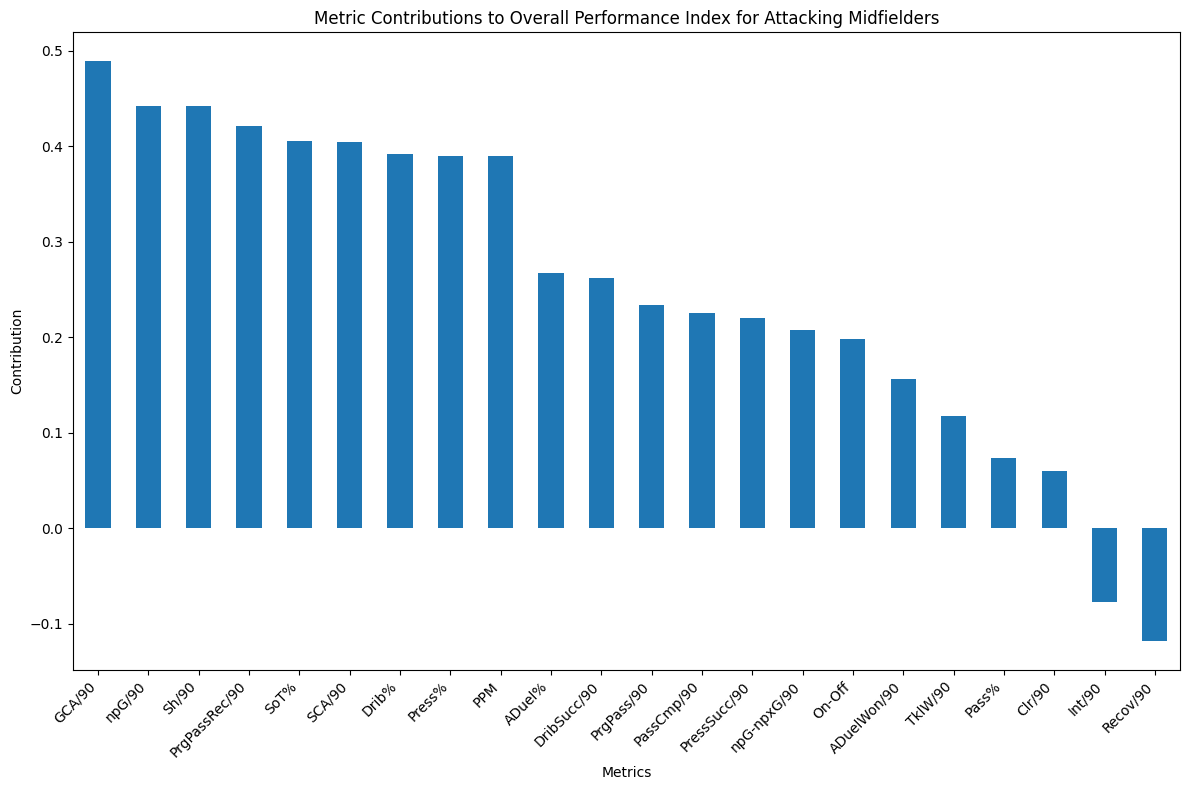

In [61]:
# Calculate the contribution of each metric to the Overall Performance Index
metric_contributions_am = {}
for metric in outfield_model_metrics:
    # Get the factor loadings for this metric
    loadings = loading_df_am.loc[metric]

    # Calculate the contribution to each index
    index_contributions_am = {}
    for index_name, factors in indices_mapping_am.items():
        contribution = sum(loadings[factor] * weights_am[index_name] for factor in factors)
        index_contributions_am[index_name] = contribution
    
    # Calculate the total contribution to the Overall Performance Index
    total_contribution = sum(index_contributions_am.values())
    metric_contributions_am[metric] = total_contribution

# Create a DataFrame of metric contributions
metric_contributions_df_am = pd.DataFrame.from_dict(metric_contributions_am, orient='index', columns=['Contribution'])
metric_contributions_df_am = metric_contributions_df_am.sort_values('Contribution', ascending=False)

print("\nMetric Contributions to Overall Performance Index:")
print(metric_contributions_df_am)

# Visualize the contributions
plt.figure(figsize=(12, 8))
metric_contributions_df_am['Contribution'].plot(kind='bar')
plt.title('Metric Contributions to Overall Performance Index for Attacking Midfielders')
plt.xlabel('Metrics')
plt.ylabel('Contribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [62]:
# Standardize the data
X_cf = position_df['Centre-Forward'][outfield_model_metrics]
X_w = position_df['Winger'][outfield_model_metrics]

X_scaled_cf = scaler.fit_transform(X_cf)
X_scaled_w = scaler.fit_transform(X_w)

X_scaled_cf = pd.DataFrame(X_scaled_cf, columns=X_cf.columns, index=X_cf.index)
X_scaled_w = pd.DataFrame(X_scaled_w, columns=X_w.columns, index=X_w.index)

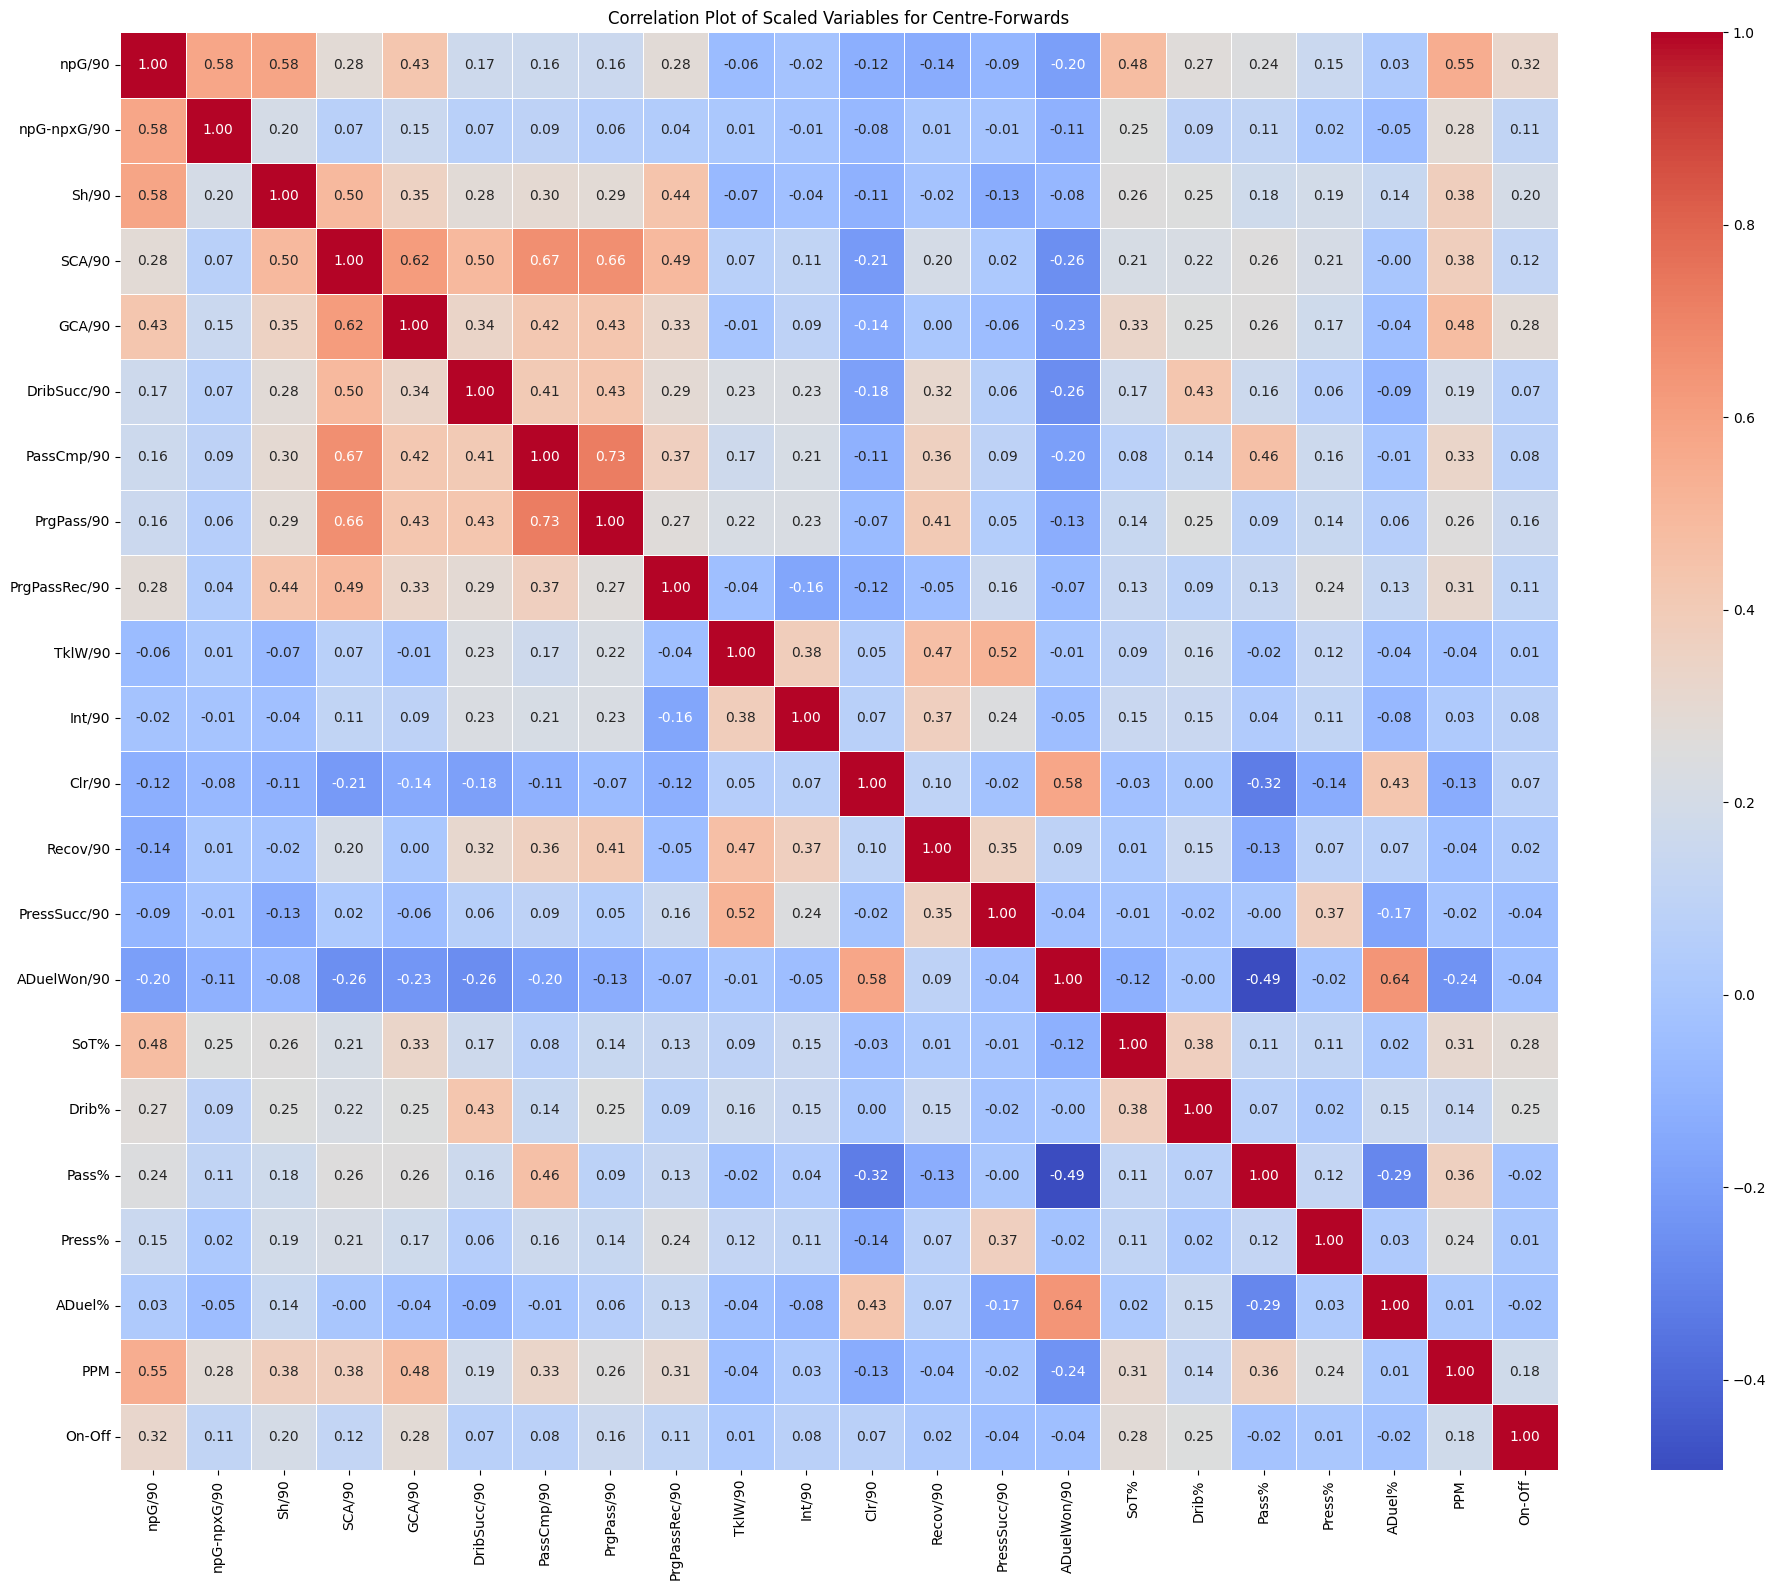

         VIF       Variable
0   3.450325         npG/90
1   1.687558    npG-npxG/90
2   2.198315          Sh/90
3   3.542530         SCA/90
4   2.123492         GCA/90
5   1.909516    DribSucc/90
6   4.399540     PassCmp/90
7   3.277219     PrgPass/90
8   1.996161  PrgPassRec/90
9   1.760679        TklW/90
10  1.423898         Int/90
11  1.657278         Clr/90
12  2.026474       Recov/90
13  2.072703   PressSucc/90
14  2.769813    ADuelWon/90
15  1.526025           SoT%
16  1.603301          Drib%
17  2.436883          Pass%
18  1.390874         Press%
19  2.151624         ADuel%
20  1.816095            PPM
21  1.293236         On-Off
KMO Model for Centre-Forwards: 0.7487526998215106
Bartlett's Test Chi-square for Centre-Forwards: 5663.042, p-value: 0.000
Eigenvalues for Centre-Forwards: [5.13433707 2.67762203 2.31809003 1.70213713 1.42444531 1.0498391
 0.96509508 0.8811812  0.73049606 0.6498197  0.62239401 0.56892272
 0.51279808 0.48541996 0.44903559 0.39145842 0.3806229  0.26555115


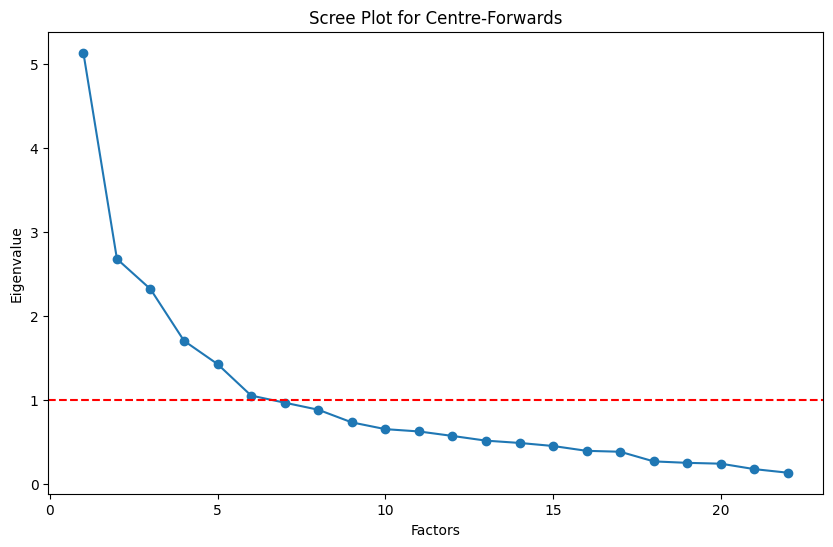

Number of factors: 6


In [63]:
# Overall Performance Index for Central Midfielders
# Plot correlation matrix
plt.figure(figsize=(20, 16))
correlation_matrix_cf = X_scaled_cf.corr()
sns.heatmap(correlation_matrix_cf, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Correlation Plot of Scaled Variables for Centre-Forwards')
plt.tight_layout()
plt.show()

# Variance Inflation Factor
vif_cf = pd.DataFrame()
vif_cf['VIF'] = [variance_inflation_factor(X_scaled_cf.values, i) for i in range(X_scaled_cf.shape[1])]
vif_cf['Variable'] = X_scaled_cf.columns
print(vif_cf)

# Step 1: KMO and Bartlett's Test
kmo_all_cf, kmo_model_cf = calculate_kmo(X_scaled_cf)
print(f"KMO Model for Centre-Forwards: {kmo_model_cf}")

# Calculate Bartlett's Test
chi_square_value_cf, p_value_cf = calculate_bartlett_sphericity(X_scaled_cf)
print(f"Bartlett's Test Chi-square for Centre-Forwards: {chi_square_value_cf:.3f}, p-value: {p_value_cf:.3f}")  # p < 0.05

# Factor Analysis with Varimax Rotation for Central Midfielders
fa_cf = FactorAnalyzer(rotation='varimax', method='principal')
fa_cf.fit(X_scaled_cf)

ev_cf, v_cf = fa_cf.get_eigenvalues()
print(f"Eigenvalues for Centre-Forwards: {ev_cf}")

plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(ev_cf)+1), ev_cf)
plt.plot(range(1, len(ev_cf)+1), ev_cf)
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Scree Plot for Centre-Forwards')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

n_factors_cf = sum(ev_cf > 1)
print(f"Number of factors: {n_factors_cf}")

In [64]:
# Factor Analysis with Varimax Rotation for Strikers
fa_cf = FactorAnalyzer(n_factors=n_factors_cf, method='principal', rotation='varimax')
fa_cf.fit(X_scaled_cf)
loadings_cf = fa_cf.loadings_

# Create a DataFrame for better readability
loading_df_cf = pd.DataFrame(loadings_cf, index=outfield_model_metrics, columns=[f'Factor{i+1}' for i in range(n_factors_cf)])
print('Factor Loadings for Centre-Forwards:')
loading_df_cf

Factor Loadings for Centre-Forwards:


Factor1   Factor2   Factor3   Factor4   Factor5   Factor6
npG/90         0.171513 -0.166641 -0.061717  0.427864  0.140116  0.747494
npG-npxG/90   -0.031102  0.086453 -0.040513  0.090680 -0.065786  0.773747
Sh/90          0.472754 -0.270772  0.061067  0.346249  0.241141  0.304455
SCA/90         0.849718  0.005944 -0.128546  0.161357  0.152498  0.067673
GCA/90         0.568215 -0.078703 -0.144807  0.330102  0.079029  0.278803
DribSucc/90    0.548179  0.242491 -0.225853  0.416626  0.002154 -0.164009
PassCmp/90     0.846208  0.251149 -0.100675 -0.131109  0.007558  0.163488
PrgPass/90     0.798851  0.301392  0.035846  0.084062 -0.047460  0.035944
PrgPassRec/90  0.519209 -0.293101  0.028892  0.134901  0.552751 -0.002945
TklW/90        0.011658  0.761272 -0.006755  0.110731  0.229601 -0.052379
Int/90         0.087360  0.690609 -0.040029  0.118849 -0.078216  0.070901
Clr/90        -0.116030  0.145283  0.741370 -0.036046 -0.157054  0.041940
Recov/90       0.297733  0.735360  0.170400 -0.010404 -0.006435 -0.104206
PressSucc/90  -0.112158  0.573693 -0.103011 -0.084821  0.652078 -0.061286
ADuelWon/90   -0.151842  0.004742  0.877885 -0.063207  0.032702 -0.109174
SoT%           0.031912  0.076431 -0.045468  0.637445  0.081629  0.376910
Drib%          0.197328  0.144213  0.045664  0.759880 -0.055083 -0.055834
Pass%          0.313955 -0.054420 -0.553952 -0.133205  0.006307  0.333042
Press%         0.109962  0.100642 -0.025992 -0.033134  0.764658  0.137005
ADuel%         0.141815 -0.134237  0.825036  0.054351  0.050203  0.008112
PPM            0.376390 -0.106038 -0.120712  0.118334  0.199277  0.611490
On-Off         0.044235  0.012944  0.044218  0.564536 -0.037308  0.184241

In [65]:
# Get Factor Scores for Strikers
factor_scores_cf = fa_cf.transform(X_scaled_cf)

# Create a DataFrame for factor scores
factor_columns_cf = [f'Factor{i+1}' for i in range(n_factors_cf)]
factor_df_cf = pd.DataFrame(factor_scores_cf, columns=factor_columns_cf, index=position_df['Centre-Forward'].index)

# Define Indices
indices_mapping_cf = {
    'Passing_Ability': ['Factor1'],
    'Defensive_Performance': ['Factor2', 'Factor3', 'Factor5'],
    'Offensive_Contribution': ['Factor6'],
    'Team_Impact': ['Factor4']
}

# Initialize the indices DataFrame
indices_df_cf = pd.DataFrame(index=position_df['Centre-Forward'].index)

# Compute each index as the average of its factor scores
for index_name, factors in indices_mapping_cf.items():
    # Compute the average of the specified factors
    indices_df_cf[index_name] = factor_df_cf[factors].mean(axis=1)

# Assign the indices to the striker_data DataFrame
position_df['Centre-Forward'] = position_df['Centre-Forward'].join(indices_df_cf)

# Define weights for each index 
weights_cf = {
    'Offensive_Contribution': 0.45,
    'Passing_Ability': 0.25,
    'Defensive_Performance': 0.2,
    'Team_Impact': 0.1
}

# Compute the Overall Performance Index as a weighted sum of the indices
position_df['Centre-Forward']['Overall_Performance_Index'] = (
    position_df['Centre-Forward']['Offensive_Contribution'] * weights_cf['Offensive_Contribution'] + 
    position_df['Centre-Forward']['Passing_Ability'] * weights_cf['Passing_Ability'] +  
    position_df['Centre-Forward']['Defensive_Performance'] * weights_cf['Defensive_Performance'] +
    position_df['Centre-Forward']['Team_Impact'] * weights_cf['Team_Impact']
)

In [66]:
position_df['Centre-Forward'][['Player','Offensive_Contribution', 'Passing_Ability', 'Defensive_Performance', 'Team_Impact', 'Overall_Performance_Index']].groupby('Player').mean().sort_values(by='Overall_Performance_Index', ascending=False).head(10)

Offensive_Contribution  Passing_Ability  \
Player                                                        
Robert Lewandowski                1.676089         0.762477   
Cristiano Ronaldo                 1.152137         2.397036   
Kylian Mbappé                     0.838974         2.427486   
Sergio Agüero                     1.478867         0.864701   
Dries Mertens                     1.084739         1.236071   
Karim Benzema                     1.089717         1.989506   
Luis Suárez                       1.311050         1.149598   
Alexis Sánchez                   -0.316807         3.139786   
Memphis Depay                     0.136970         2.882792   
Luis Muriel                       0.596441         1.359980   

                    Defensive_Performance  Team_Impact  \
Player                                                   
Robert Lewandowski               0.169819     0.511665   
Cristiano Ronaldo               -0.660303     0.260917   
Kylian Mbappé                   -0.711356     0.949914   
Sergio Agüero                   -0.393019     0.093815   
Dries Mertens                    0.143116    -0.573980   
Karim Benzema                   -0.930571    -0.397304   
Luis Suárez                     -0.548642    -0.074705   
Alexis Sánchez                   0.337701     0.443642   
Memphis Depay                   -0.425837     0.221498   
Luis Muriel                      0.127446     0.624360   

                    Overall_Performance_Index  
Player                                         
Robert Lewandowski                   1.029990  
Cristiano Ronaldo                    1.011752  
Kylian Mbappé                        0.937130  
Sergio Agüero                        0.812443  
Dries Mertens                        0.768376  
Karim Benzema                        0.761905  
Luis Suárez                          0.760173  
Alexis Sánchez                       0.754288  
Memphis Depay                        0.719317  
Luis Muriel                          0.696319


Metric Contributions to Overall Performance Index:
               Contribution
npG/90             0.404389
PPM                0.375607
npG-npxG/90        0.345510
PassCmp/90         0.303617
Sh/90              0.296105
PrgPass/90         0.282249
GCA/90             0.271629
SCA/90             0.264997
SoT%               0.263851
Press%             0.253691
Recov/90           0.206365
PrgPassRec/90      0.199676
ADuel%             0.192740
TklW/90            0.187241
Int/90             0.180103
PressSucc/90       0.160451
On-Off             0.154392
Clr/90             0.132181
Drib%              0.127153
DribSucc/90        0.108662
Pass%              0.094624
ADuelWon/90        0.089657


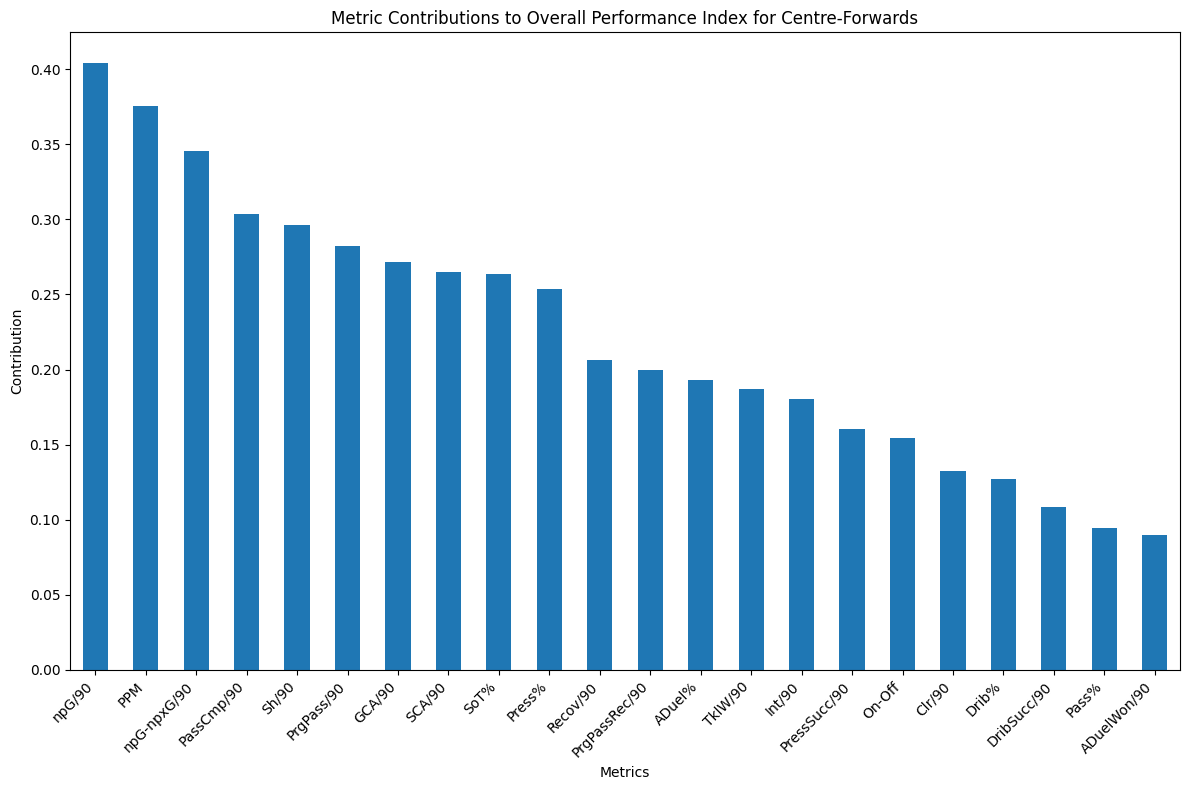

In [67]:
# Calculate the contribution of each metric to the Overall Performance Index
metric_contributions_cf = {}
for metric in outfield_model_metrics:
    # Get the factor loadings for this metric
    loadings = loading_df_cf.loc[metric]

    # Calculate the contribution to each index
    index_contributions_cf = {}
    for index_name, factors in indices_mapping_cf.items():
        contribution = sum(loadings[factor] * weights_cf[index_name] for factor in factors)
        index_contributions_cf[index_name] = contribution
    
    # Calculate the total contribution to the Overall Performance Index
    total_contribution = sum(index_contributions_cf.values())
    metric_contributions_cf[metric] = total_contribution

# Create a DataFrame of metric contributions
metric_contributions_df_cf = pd.DataFrame.from_dict(metric_contributions_cf, orient='index', columns=['Contribution'])
metric_contributions_df_cf = metric_contributions_df_cf.sort_values('Contribution', ascending=False)

print("\nMetric Contributions to Overall Performance Index:")
print(metric_contributions_df_cf)

# Visualize the contributions
plt.figure(figsize=(12, 8))
metric_contributions_df_cf['Contribution'].plot(kind='bar')
plt.title('Metric Contributions to Overall Performance Index for Centre-Forwards')
plt.xlabel('Metrics')
plt.ylabel('Contribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

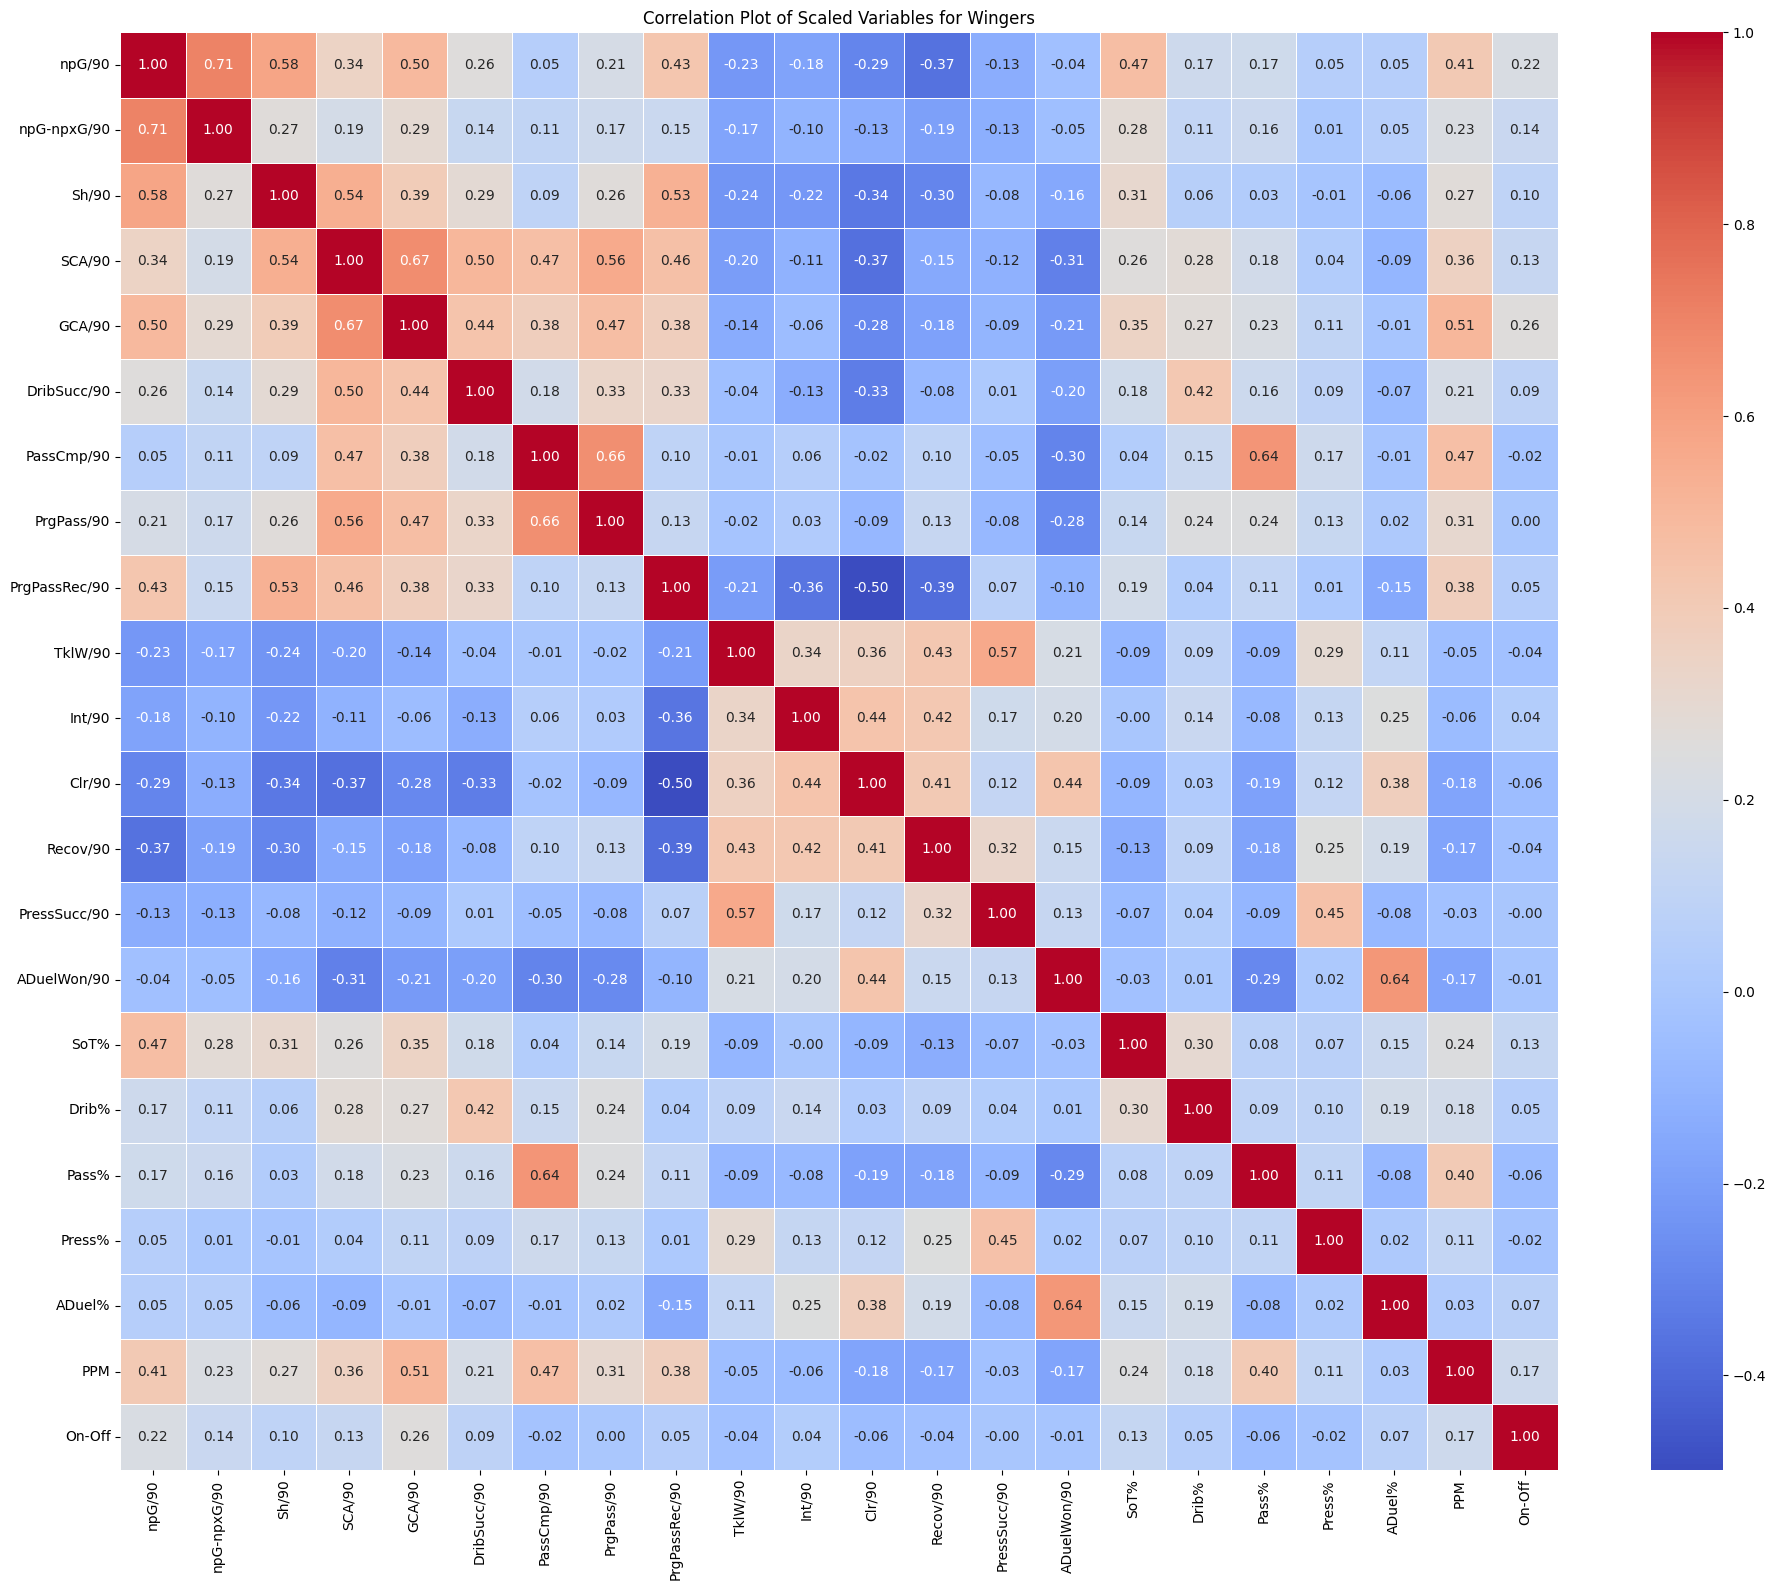

         VIF       Variable
0   4.672369         npG/90
1   2.333379    npG-npxG/90
2   2.307765          Sh/90
3   3.413131         SCA/90
4   2.586693         GCA/90
5   1.736007    DribSucc/90
6   4.656591     PassCmp/90
7   2.688726     PrgPass/90
8   2.294551  PrgPassRec/90
9   1.851608        TklW/90
10  1.486509         Int/90
11  2.162116         Clr/90
12  1.881366       Recov/90
13  2.058015   PressSucc/90
14  2.547229    ADuelWon/90
15  1.458056           SoT%
16  1.482849          Drib%
17  2.512738          Pass%
18  1.416246         Press%
19  2.199841         ADuel%
20  1.943138            PPM
21  1.170309         On-Off
KMO Model for Wingers: 0.7526335983944876
Bartlett's Test Chi-square for Wingers: 5655.551, p-value: 0.000
Eigenvalues for Wingers: [5.33699697 2.83079301 2.13094845 1.66399209 1.30635943 1.08099444
 0.99724884 0.94783778 0.76215722 0.67976494 0.57960164 0.52553475
 0.48483293 0.47967375 0.42988906 0.3802205  0.33309793 0.28937889
 0.27360083 0.22436537 

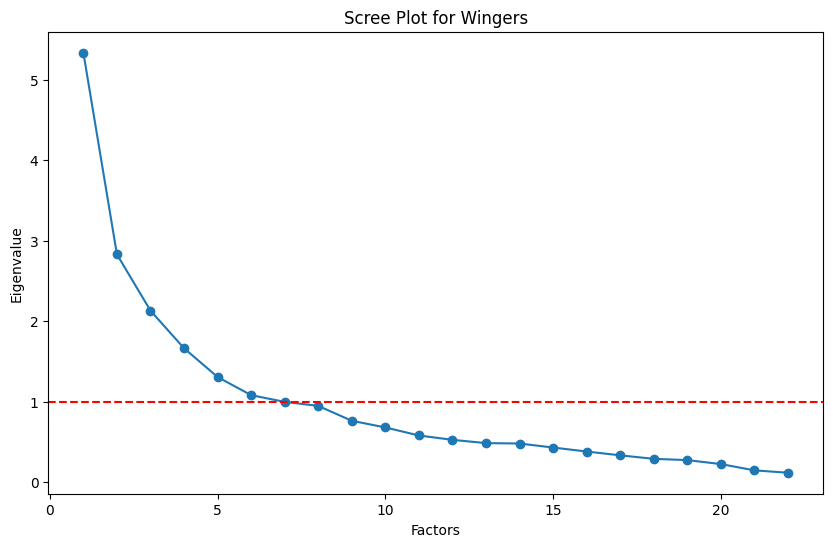

Number of factors: 6


In [68]:
# Plot correlation matrix
plt.figure(figsize=(20, 16))
correlation_matrix_w = X_scaled_w.corr()
sns.heatmap(correlation_matrix_w, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Correlation Plot of Scaled Variables for Wingers')
plt.tight_layout()
plt.show()

# Variance Inflation Factor
vif_w = pd.DataFrame()
vif_w['VIF'] = [variance_inflation_factor(X_scaled_w.values, i) for i in range(X_scaled_w.shape[1])]
vif_w['Variable'] = X_scaled_w.columns
print(vif_w)

# Step 1: KMO and Bartlett's Test
kmo_all_w, kmo_model_w = calculate_kmo(X_scaled_w)
print(f"KMO Model for Wingers: {kmo_model_w}")

# Calculate Bartlett's Test
chi_square_value_w, p_value_w = calculate_bartlett_sphericity(X_scaled_w)
print(f"Bartlett's Test Chi-square for Wingers: {chi_square_value_w:.3f}, p-value: {p_value_w:.3f}")  # p < 0.05

# Factor Analysis with Varimax Rotation for Wingers
fa_w = FactorAnalyzer(rotation='varimax', method='principal')
fa_w.fit(X_scaled_w)

ev_w, v_w = fa_w.get_eigenvalues()
print(f"Eigenvalues for Wingers: {ev_w}")

plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(ev_w)+1), ev_w)
plt.plot(range(1, len(ev_w)+1), ev_w)
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Scree Plot for Wingers')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

n_factors_w = sum(ev_w > 1)
print(f"Number of factors: {n_factors_w}")

In [69]:
# Factor Analysis with Varimax Rotation for Wingers
fa_w = FactorAnalyzer(n_factors=n_factors_w, method='principal', rotation='varimax')
fa_w.fit(X_scaled_w)
loadings_w = fa_w.loadings_

# Create a DataFrame for better readability
loading_df_w = pd.DataFrame(loadings_w, index=outfield_model_metrics, columns=[f'Factor{i+1}' for i in range(n_factors_w)])
print('Factor Loadings for Wingers:')
loading_df_w

Factor Loadings for Wingers:


Factor1   Factor2   Factor3   Factor4   Factor5   Factor6
npG/90         0.159822 -0.407723  0.095771 -0.031343  0.143097  0.786119
npG-npxG/90   -0.025751 -0.118063  0.033553 -0.081014  0.192870  0.741595
Sh/90          0.388081 -0.551472  0.004708 -0.028422  0.019953  0.329611
SCA/90         0.757771 -0.266534 -0.154224 -0.085184  0.254146  0.146656
GCA/90         0.598586 -0.174499 -0.092204 -0.013364  0.290448  0.424151
DribSucc/90    0.720484 -0.221858 -0.116875  0.063913  0.005068  0.051040
PassCmp/90     0.319944  0.120990 -0.094860  0.016700  0.862778 -0.053421
PrgPass/90     0.610558  0.108682 -0.081467 -0.027490  0.515487  0.028273
PrgPassRec/90  0.293814 -0.787715  0.000667  0.127392  0.074428  0.115921
TklW/90       -0.011482  0.331261  0.130576  0.704817 -0.050084 -0.117825
Int/90         0.085824  0.663090  0.183321  0.201794 -0.008142  0.058905
Clr/90        -0.200575  0.617458  0.460814  0.147353 -0.007837 -0.072521
Recov/90       0.145530  0.636667  0.078706  0.374223 -0.055095 -0.213769
PressSucc/90  -0.023675  0.002577 -0.033828  0.885116 -0.120390 -0.080347
ADuelWon/90   -0.163709  0.061302  0.838014  0.125759 -0.258334 -0.017344
SoT%           0.284682 -0.095774  0.167215 -0.011317  0.018306  0.550630
Drib%          0.617019  0.160531  0.194416  0.060008  0.008714  0.132631
Pass%         -0.041843 -0.104577 -0.109076 -0.017924  0.820759  0.050268
Press%         0.046491  0.042193  0.000847  0.711511  0.204474  0.079540
ADuel%         0.089765  0.215695  0.852188 -0.069259  0.019514  0.100423
PPM            0.201558 -0.226392  0.038965  0.104072  0.582545  0.350052
On-Off         0.118807  0.201068 -0.197384 -0.013335 -0.187529  0.584664

In [70]:
# Get Factor Scores for Wingers
factor_scores_w = fa_w.transform(X_scaled_w)

# Create a DataFrame for factor scores
factor_columns_w = [f'Factor{i+1}' for i in range(n_factors_w)]
factor_df_w = pd.DataFrame(factor_scores_w, columns=factor_columns_w, index=position_df['Winger'].index)

# Define Indices
indices_mapping_w = {
    'Passing_Ability': ['Factor5'],
    'Defensive_Performance': ['Factor2', 'Factor3', 'Factor4'],
    'Offensive_Contribution': ['Factor1', 'Factor6'],
    'Team_Impact': ['Factor6']
}

# Initialize the indices DataFrame
indices_df_w = pd.DataFrame(index=position_df['Winger'].index)

# Compute each index as the average of its factor scores
for index_name, factors in indices_mapping_w.items():
    # Compute the average of the specified factors
    indices_df_w[index_name] = factor_df_w[factors].mean(axis=1)

# Assign the indices to the winger_data DataFrame
# Add suffixes to avoid column name conflicts
position_df['Winger'] = position_df['Winger'].join(indices_df_w)

# Define weights for each index 
weights_w = {
    'Offensive_Contribution': 0.4,
    'Passing_Ability': 0.3,
    'Defensive_Performance': 0.2,
    'Team_Impact': 0.1
}

# Assign the indices to the winger_data DataFrame
position_df['Winger']['Overall_Performance_Index'] = (
    position_df['Winger']['Offensive_Contribution'] * weights_w['Offensive_Contribution'] + 
    position_df['Winger']['Passing_Ability'] * weights_w['Passing_Ability'] +  
    position_df['Winger']['Defensive_Performance'] * weights_w['Defensive_Performance'] +
    position_df['Winger']['Team_Impact'] * weights_w['Team_Impact']
)

In [71]:
position_df['Winger'][['Player','Offensive_Contribution', 'Passing_Ability', 'Defensive_Performance', 'Team_Impact', 'Overall_Performance_Index']].groupby('Player').mean().sort_values(by='Overall_Performance_Index', ascending=False).head(10)

Offensive_Contribution  Passing_Ability  \
Player                                                    
Lionel Messi                  2.618370         1.719557   
Neymar                        1.826632         1.611288   
Julian Draxler                0.179740         2.711894   
Riyad Mahrez                  0.844547         1.303548   
Jadon Sancho                  0.958047         1.169175   
Serge Gnabry                  0.881579         0.456921   
Phil Foden                    0.304555         1.438164   
Eden Hazard                   0.762693         1.451558   
Lucas Vázquez                -0.053392         1.602927   
Gareth Bale                   0.515625         0.312674   

                Defensive_Performance  Team_Impact  Overall_Performance_Index  
Player                                                                         
Lionel Messi                -0.625685     2.465653                   1.684644  
Neymar                      -0.502648     0.042441                   1.117754  
Julian Draxler               0.221499    -0.085388                   0.921225  
Riyad Mahrez                -0.055544     1.282616                   0.846036  
Jadon Sancho                -0.380458     0.803189                   0.738199  
Serge Gnabry                 0.080313     1.620123                   0.667783  
Phil Foden                   0.155867     0.674166                   0.651861  
Eden Hazard                 -0.576086     0.151573                   0.640485  
Lucas Vázquez                0.534169    -0.186567                   0.547698  
Gareth Bale                  0.057741     1.574432                   0.469044


Metric Contributions to Overall Performance Index:
               Contribution
GCA/90             0.482631
npG/90             0.431258
PPM                0.413742
PrgPass/90         0.412951
SoT%               0.406705
Drib%              0.398728
npG-npxG/90        0.385253
PassCmp/90         0.368667
SCA/90             0.351492
ADuel%             0.291696
On-Off             0.281666
Int/90             0.270980
Press%             0.270619
DribSucc/90        0.260270
Sh/90              0.210986
Pass%              0.208309
TklW/90            0.154801
Recov/90           0.152718
Clr/90             0.126284
PressSucc/90       0.085013
PrgPassRec/90      0.065883
ADuelWon/90        0.053359


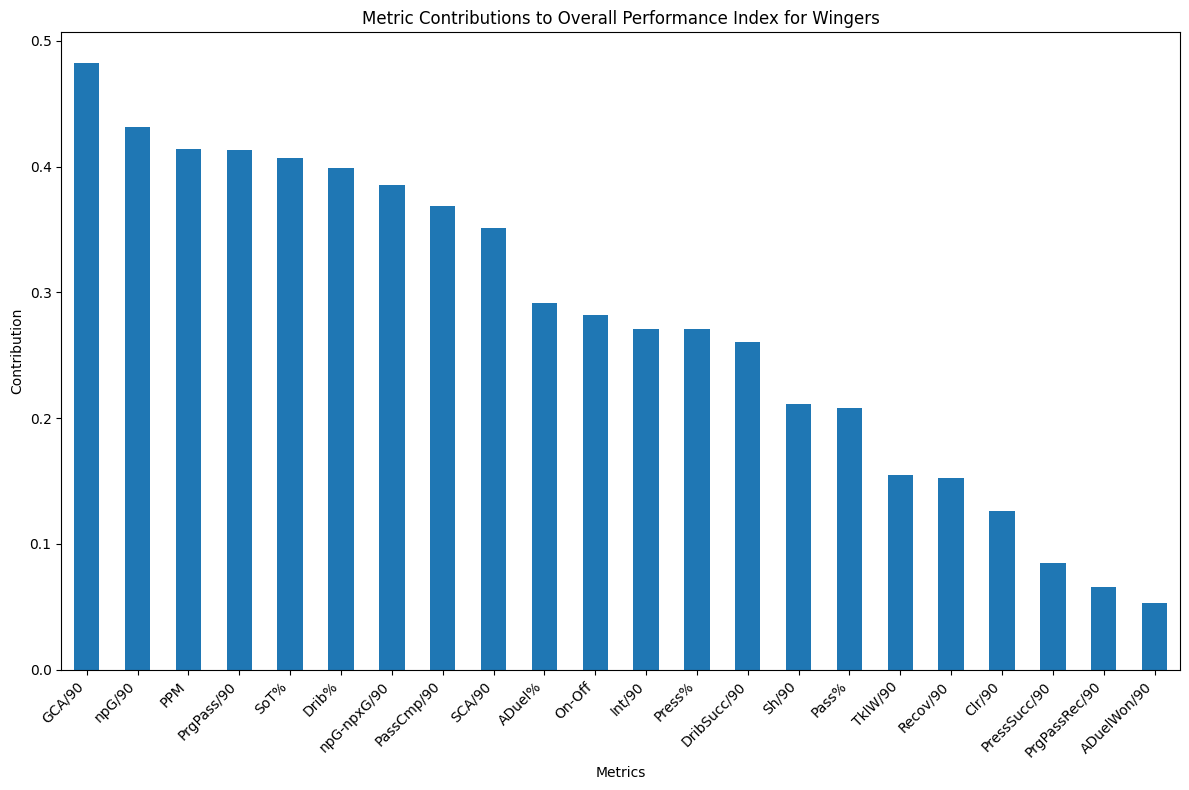

In [72]:
# Calculate the contribution of each metric to the Overall Performance Index
metric_contributions_w = {}
for metric in outfield_model_metrics:
    # Get the factor loadings for this metric
    loadings = loading_df_w.loc[metric]

    # Calculate the contribution to each index
    index_contributions_w = {}
    for index_name, factors in indices_mapping_w.items():
        contribution = sum(loadings[factor] * weights_w[index_name] for factor in factors)
        index_contributions_w[index_name] = contribution
    
    # Calculate the total contribution to the Overall Performance Index
    total_contribution = sum(index_contributions_w.values())
    metric_contributions_w[metric] = total_contribution

# Create a DataFrame of metric contributions
metric_contributions_df_w = pd.DataFrame.from_dict(metric_contributions_w, orient='index', columns=['Contribution'])
metric_contributions_df_w = metric_contributions_df_w.sort_values('Contribution', ascending=False)

print("\nMetric Contributions to Overall Performance Index:")
print(metric_contributions_df_w)

# Visualize the contributions
plt.figure(figsize=(12, 8))
metric_contributions_df_w['Contribution'].plot(kind='bar')
plt.title('Metric Contributions to Overall Performance Index for Wingers')
plt.xlabel('Metrics')
plt.ylabel('Contribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [73]:
position_df.keys()
# Define the common columns that are present in all position dataframes

dict_keys(['Wing-Back', 'Central Midfielder', 'Centre-Back', 'Defensive Midfielder', 'Attacking Midfielder', 'Winger', 'Centre-Forward'])

In [74]:
position_df['Winger']

ID          Player       Team  Age Nationality     Season  \
40    239802    Adam Marušić      Lazio   24  Montenegro  2017/2018   
41    239802    Adam Marušić      Lazio   25  Montenegro  2018/2019   
42    239802    Adam Marušić      Lazio   26  Montenegro  2019/2020   
43    239802    Adam Marušić      Lazio   27  Montenegro  2020/2021   
44    400485      Adam Ounas     Napoli   20     Algeria  2017/2018   
...      ...             ...        ...  ...         ...        ...   
4155   45320  Ángel Di María  Paris S-G   32   Argentina  2020/2021   
4164  111630     Érik Lamela  Tottenham   25   Argentina  2017/2018   
4165  111630     Érik Lamela  Tottenham   26   Argentina  2018/2019   
4166  111630     Érik Lamela  Tottenham   27   Argentina  2019/2020   
4167  111630     Érik Lamela  Tottenham   28   Argentina  2020/2021   

             MV1         MV2 Position    Pos                Comp  MP  Starts  \
40     2500000.0  10000000.0   Winger  DF,MF          it Serie A  32      28   
41    10000000.0   7000000.0   Winger  DF,MF          it Serie A  26      24   
42     7000000.0   5500000.0   Winger     DF          it Serie A  15      10   
43     5500000.0  10000000.0   Winger     DF          it Serie A  36      33   
44     4000000.0   4500000.0   Winger  FW,MF          it Serie A   7       0   
...          ...         ...      ...    ...                 ...  ..     ...   
4155  32000000.0  20000000.0   Winger  FW,MF          fr Ligue 1  27      23   
4164  25000000.0  20000000.0   Winger  FW,MF  eng Premier League  25       7   
4165  20000000.0  18000000.0   Winger  FW,MF  eng Premier League  19       9   
4166  22000000.0  16000000.0   Winger  MF,FW  eng Premier League  25      12   
4167  16000000.0  16000000.0   Winger  FW,MF  eng Premier League  23       5   

         Min   90s   PPM  On-Off   SoT%  Drib%  Pass%  Press%  ADuel%  npG/90  \
40    2523.0  28.0  1.91    0.75  35.38  50.80  77.31   28.07   60.16    0.13   
41    2111.0  23.5  1.58   -0.35  37.72  56.17  81.46   27.96   48.00    0.08   
42     942.0  10.5  2.40    0.50  41.95  54.75  83.88   27.39   43.01    0.20   
43    2966.0  33.0  1.72    0.18  40.65  53.09  83.27   28.78   59.09    0.09   
44      96.0   1.1  1.43   -0.34  34.38  58.78  75.64   25.75   41.17    0.00   
...      ...   ...   ...     ...    ...    ...    ...     ...     ...     ...   
4155  1853.0  20.6  2.04    0.27  32.21  53.17  73.05   28.12    0.00    0.24   
4164   843.0   9.4  2.12   -0.05  34.05  62.67  79.15   31.24   28.20    0.21   
4165   974.0  10.8  2.00   -0.26  37.46  59.28  81.37   26.78   39.17    0.31   
4166  1215.0  13.5  1.52    0.58  32.18  64.15  78.41   27.48   26.16    0.17   
4167   717.0   8.0  1.52   -0.92  38.71  62.09  78.12   26.64   27.68    0.16   

      npG-npxG/90  Sh/90  SCA/90  GCA/90  DribSucc/90  PassCmp/90  PrgPass/90  \
40           0.00   1.39    2.57    0.40         1.19       33.01        2.61   
41           0.00   0.83    1.92    0.17         1.61       34.12        3.00   
42           0.04   1.16    1.75    0.39         1.27       32.14        0.98   
43           0.00   0.86    1.82    0.21         0.90       40.88        2.75   
44           0.00   3.34    5.37    0.72         3.25       36.56        3.08   
...           ...    ...     ...     ...          ...         ...         ...   
4155         0.00   2.87    6.02    0.84         2.50       42.98        6.17   
4164         0.00   2.13    3.76    0.35         2.88       39.51        3.21   
4165         0.05   2.64    4.55    0.52         2.14       34.16        3.34   
4166         0.00   2.15    3.53    0.55         2.42       34.65        3.13   
4167         0.00   2.68    3.26    0.56         2.14       35.92        3.59   

      PrgPassRec/90  TklW/90  Int/90  Clr/90  Recov/90  PressSucc/90  \
40             5.23     0.73    0.65    0.64      8.70          3.48   
41             3.56     1.01    0.72    1.11      7.45          4.40   
42             3.32     0.79    0.

In [75]:
# Define the common columns that are present in all position dataframes
common_columns = ['Player', 'Team', 'Age', 'Nationality', 'Season', 'MV1', 'MV2', 'Position', 'Comp', 'MP', 'Starts', 'Min', '90s']

# Define the performance index columns
performance_columns = ['Offensive_Contribution', 'Passing_Ability', 'Defensive_Performance', 'Team_Impact', 'Overall_Performance_Index']

# Concatenate all position dataframes and keep only the defined columns
outfielder_data = pd.concat(position_df.values(), ignore_index=True)[common_columns + performance_columns]

In [76]:
# Save the concatenated data to a CSV file
outfielder_data.to_csv('../data/processed/outfielder_opi.csv', index=False)


In [77]:
# For goalkeeper data, we need to handle it separately as it has different performance columns
goalkeeper_columns = common_columns + ['Passing_Ability', 'Shot-Stopping', 'Territorial_Command', 'Team_Impact', 'Overall_Performance_Index']
goalkeeper_data = goalkeeper_data[goalkeeper_columns]
goalkeeper_data.to_csv('../data/processed/goalkeeper_opi.csv', index=False)
